# Exploring the radial properties of the hot-ICM density

We can infer the density of the hot baryon component of the intra-cluster medium through the use of X-ray observations. In this case we use surface brightness profiles to determine the 3D density profile of each cluster, assuming spherical symmetry.

<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented. Also also, we are still using the MCXC defined coordinates</span>

<span style="color:red">**We do not currently make the density profile saves available, as I need to create a better file format for them (i.e. FITS based), and they are probably too large for GitHub right now.**</span>

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
from matplotlib import pyplot as plt
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model

%matplotlib inline

## Define the cosmology

We make use of a concordance flat LambdaCDM cosmology during the course of this analysis:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading the sample file

We read in the sample file to get the information we need to set up an XGA ClusterSample:

In [3]:
# samp = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
samp

name          MCXC  LoVoCCSID          ra        dec   
0    MCXCJ1558.3+2713  J1558.3+2713          0  239.585833  27.226944  \
1    MCXCJ1510.9+0543  J1510.9+0543          1  227.729167   5.720000   
2    MCXCJ0258.9+1334  J0258.9+1334          2   44.739583  13.579444   
3    MCXCJ1348.8+2635  J1348.8+2635          3  207.220833  26.595556   
4    MCXCJ0041.8-0918  J0041.8-0918          4   10.458750  -9.301944   
..                ...           ...        ...         ...        ...   
139  MCXCJ0448.2-2028  J0448.2-2028        139   72.050833 -20.469722   
140  MCXCJ2323.8+1648  J2323.8+1648        140  350.972917  16.808889   
141  MCXCJ1416.8-1158  J1416.8-1158        141  214.214583 -11.976111   
142  MCXCJ1459.0-0843  J1459.0-0843        142  224.764583  -8.725000   
143  MCXCJ0041.7+2124  J0041.7+2124        143   10.446250  21.413889   

     redshift       L500    M500    R500         alt_name other_names   
0      0.0894  10.676087  8.1491  1.3803  RXCJ1558.3+2713       A2142  \
1      0.0766   8.726709  7.2708  1.3344            A2029       A2029   
2      0.0739   6.088643  5.8488  1.2421  RXCJ0258.9+1334        A401   
3      0.0622   5.478067  5.5280  1.2236  RXCJ1348.8+2635       A1795   
4      0.0555   5.100085  5.3163  1.2103  RXCJ0041.8-0918         A85   
..        ...        ...     ...     ...              ...         ...   
139    0.0720   1.004022  1.9513  0.8620  RXCJ0448.2-2028        A514   
140    0.0416   1.002026  1.9896  0.8760            A2589       A2589   
141    0.0982   1.001648  1.9133  0.8491  RXCJ1416.8-1158         NaN   
142    0.1043   1.001337  1.9047  0.8461  RXCJ1459.0-0843         NaN   
143    0.1014   1.000012  1.9071  0.8473  RXCJ0041.7+2124         A84   

        Notes sub_samp  
0           L    north  
1         NaN    south  
2           L    south  
3         NaN    north  
4    L,losStr    south  
..        ...      ...  
139    losStr    south  
140       NaN    north  
141         X    south  
142       NaN    south  
143       NaN    north  

[144 rows x 13 columns]

## Set up an XGA ClusterSample

<span style="color:red">This is currently a bodge, they are some slightly better coordinates to help XGA select the correct region during the set up process. This will be made redundant by updated central positions for the whole sample sometime soon</span>

In [4]:
samp.loc[95, 'ra'] = 240.56
samp.loc[95, 'dec'] = 15.965

samp.loc[130, 'ra'] = 359.713
samp.loc[130, 'dec'] = -60.642

samp.loc[89, 'ra'] = 227.865
samp.loc[89, 'dec'] = 6.349

We set up an XGA ClusterSample to help us manage all the data and analyse the objects. <span style="color:red">The MCXC coordinates are used</span> as the central positions of the clusters, <span style="color:red">as well as the MCXC $R_{500}$ values.</span> 

<span style="color:red">The threshold for an observation being determined as relevant is set to 10% of the $R_{500}$ being on a particular observation.</span> 

In [5]:
ra = samp['ra'].values
dec = samp['dec'].values
name = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x)).values
z = samp['redshift'].values
r500 = Quantity(samp['R500'].values, 'Mpc')

srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.1, cosmology=cosmo)

Declaring BaseSource Sample:   0%|          | 0/144 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Declaring BaseSource Sample:  57%|█████▋    | 82/144 [01:48<01:29,  1.44s/it]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Setting up Galaxy Clusters:   0%|          | 0/116 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters:  23%|██▎       | 27/116 [02:15<04:19,  2.91s/it]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters:  65%|██████▍   | 75/116 [04:31<01:58,  2.89s/it]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Setting up Galaxy Clusters: 100%|██████████| 116/116 [06:27<00:00,  3.34s/it]
/tmp/local/22421326/ipykernel_112212/2159159347.py:7: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-18, LoVoCCS-24, LoVoCCS-37, LoVoCCS-53,

In [6]:
srcs.info()


-----------------------------------------------------
Number of Sources - 116
Redshift Information - True
Sources with ≥1 detection - 108 [93%]
-----------------------------------------------------



## Richardson-Lucy spatially varying PSF correction 

Running the PSF correction of images necessary to create density profiles from surface brightness:

In [7]:
rl_psf(srcs, bins=10, num_cores=100)

## Density profiles from double-$\beta$ profile fits to $S_{\rm{B}}(r)$

<span style="color:red">THIS IS QUITE A BODGE</span> 

In [8]:
del srcs['LoVoCCS-1']
del srcs['LoVoCCS-4']
del srcs['LoVoCCS-10']
del srcs['LoVoCCS-29']
del srcs['LoVoCCS-46']
del srcs['LoVoCCS-51']
del srcs['LoVoCCS-66']
del srcs['LoVoCCS-82']
del srcs['LoVoCCS-90']

In [9]:
errors = """[[SASGenerationError("/bin/sh: line 1: 34223 Segmentation fault      (core dumped) rmfgen rmfset=0744411101_mos1_LoVoCCS-1_universal.rmf spectrumset='0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1."), SASGenerationError('/bin/sh: line 1: 34225 Segmentation fault      (core dumped) arfgen spectrumset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411101_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1.'), SASGenerationError('/bin/sh: line 1: 34278 Segmentation fault      (core dumped) backscale spectrumset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1.'), SASGenerationError('/bin/sh: line 1: 35646 Segmentation fault      (core dumped) specgroup spectrumset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411101_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411101_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos1.'), SASGenerationError("/bin/sh: line 1: 34288 Segmentation fault      (core dumped) rmfgen rmfset=0744411101_mos2_LoVoCCS-1_universal.rmf spectrumset='0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2."), SASGenerationError('/bin/sh: line 1: 34295 Segmentation fault      (core dumped) arfgen spectrumset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411101_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2.'), SASGenerationError('/bin/sh: line 1: 34338 Segmentation fault      (core dumped) backscale spectrumset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2.'), SASGenerationError('/bin/sh: line 1: 35909 Segmentation fault      (core dumped) specgroup spectrumset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411101_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-mos2.'), SASGenerationError("/bin/sh: line 1: 34323 Segmentation fault      (core dumped) rmfgen rmfset=0744410901_mos2_LoVoCCS-1_universal.rmf spectrumset='0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744410901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2."), SASGenerationError('/bin/sh: line 1: 34325 Segmentation fault      (core dumped) arfgen spectrumset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744410901_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744410901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2.'), SASGenerationError('/bin/sh: line 1: 34376 Segmentation fault      (core dumped) backscale spectrumset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2.'), SASGenerationError('/bin/sh: line 1: 35936 Segmentation fault      (core dumped) specgroup spectrumset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744410901_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744410901_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-mos2.'), SASGenerationError("/bin/sh: line 1: 34714 Segmentation fault      (core dumped) rmfgen rmfset=0744411201_mos1_LoVoCCS-1_universal.rmf spectrumset='0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1."), SASGenerationError('/bin/sh: line 1: 34717 Segmentation fault      (core dumped) arfgen spectrumset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411201_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('/bin/sh: line 1: 34737 Segmentation fault      (core dumped) backscale spectrumset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError('/bin/sh: line 1: 35975 Segmentation fault      (core dumped) specgroup spectrumset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411201_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos1.'), SASGenerationError("/bin/sh: line 1: 34749 Segmentation fault      (core dumped) rmfgen rmfset=0744411201_mos2_LoVoCCS-1_universal.rmf spectrumset='0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2."), SASGenerationError('/bin/sh: line 1: 34751 Segmentation fault      (core dumped) arfgen spectrumset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411201_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('/bin/sh: line 1: 34790 Segmentation fault      (core dumped) backscale spectrumset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError('/bin/sh: line 1: 36213 Segmentation fault      (core dumped) specgroup spectrumset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411201_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-mos2.'), SASGenerationError("/bin/sh: line 1: 34932 Segmentation fault      (core dumped) rmfgen rmfset=0822350101_mos2_LoVoCCS-1_universal.rmf spectrumset='0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0822350101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2."), SASGenerationError('/bin/sh: line 1: 34933 Segmentation fault      (core dumped) arfgen spectrumset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0822350101_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0822350101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError('/bin/sh: line 1: 35008 Segmentation fault      (core dumped) backscale spectrumset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError('/bin/sh: line 1: 36326 Segmentation fault      (core dumped) specgroup spectrumset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0822350101_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0822350101_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-mos2.'), SASGenerationError("/bin/sh: line 1: 35256 Segmentation fault      (core dumped) rmfgen rmfset=0744411001_mos1_LoVoCCS-1_universal.rmf spectrumset='0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1."), SASGenerationError('/bin/sh: line 1: 35258 Segmentation fault      (core dumped) arfgen spectrumset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411001_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1.'), SASGenerationError('/bin/sh: line 1: 35289 Segmentation fault      (core dumped) backscale spectrumset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1.'), SASGenerationError('/bin/sh: line 1: 36604 Segmentation fault      (core dumped) specgroup spectrumset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411001_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411001_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos1.'), SASGenerationError("/bin/sh: line 1: 34359 Segmentation fault      (core dumped) rmfgen rmfset=0744411101_pn_LoVoCCS-1_universal.rmf spectrumset='0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn."), SASGenerationError('/bin/sh: line 1: 34360 Segmentation fault      (core dumped) arfgen spectrumset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411101_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError('/bin/sh: line 1: 34505 Segmentation fault      (core dumped) backscale spectrumset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError('/bin/sh: line 1: 36805 Segmentation fault      (core dumped) specgroup spectrumset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411101_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411101-pn.'), SASGenerationError("/bin/sh: line 1: 35144 Segmentation fault      (core dumped) rmfgen rmfset=0744411001_mos2_LoVoCCS-1_universal.rmf spectrumset='0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2."), SASGenerationError('/bin/sh: line 1: 35145 Segmentation fault      (core dumped) arfgen spectrumset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411001_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2.'), SASGenerationError('/bin/sh: line 1: 35253 Segmentation fault      (core dumped) backscale spectrumset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2.'), SASGenerationError('/bin/sh: line 1: 36826 Segmentation fault      (core dumped) specgroup spectrumset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411001_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411001_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-mos2.'), SASGenerationError("/bin/sh: line 1: 34436 Segmentation fault      (core dumped) rmfgen rmfset=0744410901_pn_LoVoCCS-1_universal.rmf spectrumset='0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744410901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn."), SASGenerationError('/bin/sh: line 1: 34437 Segmentation fault      (core dumped) arfgen spectrumset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744410901_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744410901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError('/bin/sh: line 1: 34566 Segmentation fault      (core dumped) backscale spectrumset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744410901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError('/bin/sh: line 1: 36924 Segmentation fault      (core dumped) specgroup spectrumset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744410901_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744410901_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744410901-pn.'), SASGenerationError("/bin/sh: line 1: 35915 Segmentation fault      (core dumped) rmfgen rmfset=0551780501_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1."), SASGenerationError('/bin/sh: line 1: 35917 Segmentation fault      (core dumped) arfgen spectrumset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780501_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1.'), SASGenerationError('/bin/sh: line 1: 36006 Segmentation fault      (core dumped) backscale spectrumset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1.'), SASGenerationError('/bin/sh: line 1: 38663 Segmentation fault      (core dumped) specgroup spectrumset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780501_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780501_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos1.'), SASGenerationError("/bin/sh: line 1: 35169 Segmentation fault      (core dumped) rmfgen rmfset=0744411201_pn_LoVoCCS-1_universal.rmf spectrumset='0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn."), SASGenerationError('/bin/sh: line 1: 35171 Segmentation fault      (core dumped) arfgen spectrumset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411201_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError('/bin/sh: line 1: 35356 Segmentation fault      (core dumped) backscale spectrumset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError('/bin/sh: line 1: 38723 Segmentation fault      (core dumped) specgroup spectrumset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411201_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411201-pn.'), SASGenerationError("/bin/sh: line 1: 35840 Segmentation fault      (core dumped) rmfgen rmfset=0551780201_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1."), SASGenerationError('/bin/sh: line 1: 35842 Segmentation fault      (core dumped) arfgen spectrumset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780201_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1.'), SASGenerationError('/bin/sh: line 1: 36018 Segmentation fault      (core dumped) backscale spectrumset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1.'), SASGenerationError('/bin/sh: line 1: 38726 Segmentation fault      (core dumped) specgroup spectrumset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780201_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos1.'), SASGenerationError("/bin/sh: line 1: 35927 Segmentation fault      (core dumped) rmfgen rmfset=0551780401_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1."), SASGenerationError('/bin/sh: line 1: 35928 Segmentation fault      (core dumped) arfgen spectrumset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780401_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1.'), SASGenerationError('/bin/sh: line 1: 36042 Segmentation fault      (core dumped) backscale spectrumset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1.'), SASGenerationError('/bin/sh: line 1: 38812 Segmentation fault      (core dumped) specgroup spectrumset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780401_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780401_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos1.'), SASGenerationError("/bin/sh: line 1: 35964 Segmentation fault      (core dumped) rmfgen rmfset=0551780501_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2."), SASGenerationError('/bin/sh: line 1: 35966 Segmentation fault      (core dumped) arfgen spectrumset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780501_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2.'), SASGenerationError('/bin/sh: line 1: 36045 Segmentation fault      (core dumped) backscale spectrumset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2.'), SASGenerationError('/bin/sh: line 1: 38910 Segmentation fault      (core dumped) specgroup spectrumset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780501_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780501_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-mos2.'), SASGenerationError("/bin/sh: line 1: 36165 Segmentation fault      (core dumped) rmfgen rmfset=0111270201_mos2_LoVoCCS-1_universal.rmf spectrumset='0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0111270201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2."), SASGenerationError('/bin/sh: line 1: 36166 Segmentation fault      (core dumped) arfgen spectrumset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0111270201_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0111270201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2.'), SASGenerationError('/bin/sh: line 1: 36201 Segmentation fault      (core dumped) backscale spectrumset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2.'), SASGenerationError('/bin/sh: line 1: 38935 Segmentation fault      (core dumped) specgroup spectrumset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0111270201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0111270201_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos2.'), SASGenerationError("/bin/sh: line 1: 35951 Segmentation fault      (core dumped) rmfgen rmfset=0551780201_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2."), SASGenerationError('/bin/sh: line 1: 35953 Segmentation fault      (core dumped) arfgen spectrumset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780201_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2.'), SASGenerationError('/bin/sh: line 1: 36121 Segmentation fault      (core dumped) backscale spectrumset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2.'), SASGenerationError('/bin/sh: line 1: 38942 Segmentation fault      (core dumped) specgroup spectrumset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780201_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780201_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-mos2.'), SASGenerationError("/bin/sh: line 1: 35946 Segmentation fault      (core dumped) rmfgen rmfset=0551780401_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2."), SASGenerationError('/bin/sh: line 1: 35947 Segmentation fault      (core dumped) arfgen spectrumset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780401_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2.'), SASGenerationError('/bin/sh: line 1: 36066 Segmentation fault      (core dumped) backscale spectrumset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2.'), SASGenerationError('/bin/sh: line 1: 38965 Segmentation fault      (core dumped) specgroup spectrumset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780401_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780401_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-mos2.'), SASGenerationError("/bin/sh: line 1: 36152 Segmentation fault      (core dumped) rmfgen rmfset=0111270201_mos1_LoVoCCS-1_universal.rmf spectrumset='0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0111270201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1."), SASGenerationError('/bin/sh: line 1: 36153 Segmentation fault      (core dumped) arfgen spectrumset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0111270201_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0111270201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1.'), SASGenerationError('/bin/sh: line 1: 36172 Segmentation fault      (core dumped) backscale spectrumset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1.'), SASGenerationError('/bin/sh: line 1: 39092 Segmentation fault      (core dumped) specgroup spectrumset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0111270201_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0111270201_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-mos1.'), SASGenerationError("/bin/sh: line 1: 36244 Segmentation fault      (core dumped) rmfgen rmfset=0551780301_mos1_LoVoCCS-1_universal.rmf spectrumset='0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1."), SASGenerationError('/bin/sh: line 1: 36247 Segmentation fault      (core dumped) arfgen spectrumset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780301_mos1_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1.'), SASGenerationError('/bin/sh: line 1: 36380 Segmentation fault      (core dumped) backscale spectrumset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1.'), SASGenerationError('/bin/sh: line 1: 39107 Segmentation fault      (core dumped) specgroup spectrumset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780301_mos1_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780301_mos1_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos1.'), SASGenerationError("/bin/sh: line 1: 35563 Segmentation fault      (core dumped) rmfgen rmfset=0822350101_pn_LoVoCCS-1_universal.rmf spectrumset='0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0822350101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn."), SASGenerationError('/bin/sh: line 1: 35565 Segmentation fault      (core dumped) arfgen spectrumset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0822350101_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0822350101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError('/bin/sh: line 1: 35804 Segmentation fault      (core dumped) backscale spectrumset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0822350101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError('/bin/sh: line 1: 39138 Segmentation fault      (core dumped) specgroup spectrumset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0822350101_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0822350101_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0822350101-pn.'), SASGenerationError("/bin/sh: line 1: 36362 Segmentation fault      (core dumped) rmfgen rmfset=0551780301_mos2_LoVoCCS-1_universal.rmf spectrumset='0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2."), SASGenerationError('/bin/sh: line 1: 36363 Segmentation fault      (core dumped) arfgen spectrumset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780301_mos2_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2.'), SASGenerationError('/bin/sh: line 1: 36449 Segmentation fault      (core dumped) backscale spectrumset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2.'), SASGenerationError('/bin/sh: line 1: 39375 Segmentation fault      (core dumped) specgroup spectrumset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780301_mos2_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780301_mos2_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-mos2.'), SASGenerationError("/bin/sh: line 1: 35791 Segmentation fault      (core dumped) rmfgen rmfset=0744411001_pn_LoVoCCS-1_universal.rmf spectrumset='0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411001_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn."), SASGenerationError('/bin/sh: line 1: 35792 Segmentation fault      (core dumped) arfgen spectrumset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411001_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411001_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError('/bin/sh: line 1: 36017 Segmentation fault      (core dumped) backscale spectrumset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411001/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError('/bin/sh: line 1: 39656 Segmentation fault      (core dumped) specgroup spectrumset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0744411001_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0744411001_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0744411001-pn.'), SASGenerationError("/bin/sh: line 1: 36241 Segmentation fault      (core dumped) rmfgen rmfset=0551780201_pn_LoVoCCS-1_universal.rmf spectrumset='0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn."), SASGenerationError('/bin/sh: line 1: 36242 Segmentation fault      (core dumped) arfgen spectrumset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780201_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn.'), SASGenerationError('/bin/sh: line 1: 36551 Segmentation fault      (core dumped) backscale spectrumset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn.'), SASGenerationError('/bin/sh: line 1: 40242 Segmentation fault      (core dumped) specgroup spectrumset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780201_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780201-pn.'), SASGenerationError("/bin/sh: line 1: 36349 Segmentation fault      (core dumped) rmfgen rmfset=0551780401_pn_LoVoCCS-1_universal.rmf spectrumset='0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn."), SASGenerationError('/bin/sh: line 1: 36350 Segmentation fault      (core dumped) arfgen spectrumset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780401_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn.'), SASGenerationError('/bin/sh: line 1: 36572 Segmentation fault      (core dumped) backscale spectrumset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn.'), SASGenerationError('/bin/sh: line 1: 40254 Segmentation fault      (core dumped) specgroup spectrumset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780401_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780401_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780401-pn.'), SASGenerationError("/bin/sh: line 1: 36481 Segmentation fault      (core dumped) rmfgen rmfset=0551780501_pn_LoVoCCS-1_universal.rmf spectrumset='0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn."), SASGenerationError('/bin/sh: line 1: 36482 Segmentation fault      (core dumped) arfgen spectrumset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780501_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn.'), SASGenerationError('/bin/sh: line 1: 36816 Segmentation fault      (core dumped) backscale spectrumset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn.'), SASGenerationError('/bin/sh: line 1: 40600 Segmentation fault      (core dumped) specgroup spectrumset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780501_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780501_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780501-pn.'), SASGenerationError("/bin/sh: line 1: 36897 Segmentation fault      (core dumped) rmfgen rmfset=0551780301_pn_LoVoCCS-1_universal.rmf spectrumset='0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0551780301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn."), SASGenerationError('/bin/sh: line 1: 36899 Segmentation fault      (core dumped) arfgen spectrumset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0551780301_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0551780301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn.'), SASGenerationError('/bin/sh: line 1: 37254 Segmentation fault      (core dumped) backscale spectrumset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0551780301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn.'), SASGenerationError('/bin/sh: line 1: 41035 Segmentation fault      (core dumped) specgroup spectrumset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0551780301_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0551780301_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0551780301-pn.'), SASGenerationError("/bin/sh: line 1: 38869 Segmentation fault      (core dumped) rmfgen rmfset=0111270201_pn_LoVoCCS-1_universal.rmf spectrumset='0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0111270201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn."), SASGenerationError('/bin/sh: line 1: 38875 Segmentation fault      (core dumped) arfgen spectrumset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits arfset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf withrmfset=yes rmfset=0111270201_pn_LoVoCCS-1_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0111270201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn.'), SASGenerationError('/bin/sh: line 1: 40545 Segmentation fault      (core dumped) backscale spectrumset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0111270201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn.'), SASGenerationError('/bin/sh: line 1: 43637 Segmentation fault      (core dumped) specgroup spectrumset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5_backspec.fits arfset=0111270201_pn_LoVoCCS-1_ra227.7291667_dec5.72_ri0.0_ro0.255374166567157_grpTrue_mincnt5.arf rmfset=0111270201_pn_LoVoCCS-1_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-1 is the associated source, the specific data used is 0111270201-pn.')], [SASGenerationError("/bin/sh: line 1: 34532 Segmentation fault      (core dumped) rmfgen rmfset=0744411701_mos1_LoVoCCS-4_universal.rmf spectrumset='0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1."), SASGenerationError('/bin/sh: line 1: 34533 Segmentation fault      (core dumped) arfgen spectrumset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411701_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1.'), SASGenerationError('/bin/sh: line 1: 34569 Segmentation fault      (core dumped) backscale spectrumset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1.'), SASGenerationError('/bin/sh: line 1: 36081 Segmentation fault      (core dumped) specgroup spectrumset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411701_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411701_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos1.'), SASGenerationError("/bin/sh: line 1: 34603 Segmentation fault      (core dumped) rmfgen rmfset=0744411901_mos1_LoVoCCS-4_universal.rmf spectrumset='0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1."), SASGenerationError('/bin/sh: line 1: 34604 Segmentation fault      (core dumped) arfgen spectrumset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411901_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1.'), SASGenerationError('/bin/sh: line 1: 34646 Segmentation fault      (core dumped) backscale spectrumset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1.'), SASGenerationError('/bin/sh: line 1: 36134 Segmentation fault      (core dumped) specgroup spectrumset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411901_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411901_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos1.'), SASGenerationError("/bin/sh: line 1: 34492 Segmentation fault      (core dumped) rmfgen rmfset=0065140201_mos2_LoVoCCS-4_universal.rmf spectrumset='0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2."), SASGenerationError('/bin/sh: line 1: 34493 Segmentation fault      (core dumped) arfgen spectrumset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140201_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError('/bin/sh: line 1: 34516 Segmentation fault      (core dumped) backscale spectrumset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError('/bin/sh: line 1: 36158 Segmentation fault      (core dumped) specgroup spectrumset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140201_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos2.'), SASGenerationError("/bin/sh: line 1: 34499 Segmentation fault      (core dumped) rmfgen rmfset=0065140201_mos1_LoVoCCS-4_universal.rmf spectrumset='0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1."), SASGenerationError('/bin/sh: line 1: 34500 Segmentation fault      (core dumped) arfgen spectrumset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140201_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('/bin/sh: line 1: 34519 Segmentation fault      (core dumped) backscale spectrumset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError('/bin/sh: line 1: 36222 Segmentation fault      (core dumped) specgroup spectrumset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140201_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-mos1.'), SASGenerationError("/bin/sh: line 1: 34762 Segmentation fault      (core dumped) rmfgen rmfset=0744411801_mos1_LoVoCCS-4_universal.rmf spectrumset='0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1."), SASGenerationError('/bin/sh: line 1: 34763 Segmentation fault      (core dumped) arfgen spectrumset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411801_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1.'), SASGenerationError('/bin/sh: line 1: 34826 Segmentation fault      (core dumped) backscale spectrumset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1.'), SASGenerationError('/bin/sh: line 1: 36330 Segmentation fault      (core dumped) specgroup spectrumset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411801_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411801_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos1.'), SASGenerationError("/bin/sh: line 1: 34579 Segmentation fault      (core dumped) rmfgen rmfset=0744411701_mos2_LoVoCCS-4_universal.rmf spectrumset='0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2."), SASGenerationError('/bin/sh: line 1: 34580 Segmentation fault      (core dumped) arfgen spectrumset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411701_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2.'), SASGenerationError('/bin/sh: line 1: 34612 Segmentation fault      (core dumped) backscale spectrumset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2.'), SASGenerationError('/bin/sh: line 1: 36337 Segmentation fault      (core dumped) specgroup spectrumset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411701_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411701_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-mos2.'), SASGenerationError("/bin/sh: line 1: 34708 Segmentation fault      (core dumped) rmfgen rmfset=0744411901_mos2_LoVoCCS-4_universal.rmf spectrumset='0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2."), SASGenerationError('/bin/sh: line 1: 34709 Segmentation fault      (core dumped) arfgen spectrumset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411901_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2.'), SASGenerationError('/bin/sh: line 1: 34746 Segmentation fault      (core dumped) backscale spectrumset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2.'), SASGenerationError('/bin/sh: line 1: 36430 Segmentation fault      (core dumped) specgroup spectrumset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411901_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411901_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-mos2.'), SASGenerationError("/bin/sh: line 1: 34927 Segmentation fault      (core dumped) rmfgen rmfset=0744930301_mos1_LoVoCCS-4_universal.rmf spectrumset='0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1."), SASGenerationError('/bin/sh: line 1: 34928 Segmentation fault      (core dumped) arfgen spectrumset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930301_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1.'), SASGenerationError('/bin/sh: line 1: 34989 Segmentation fault      (core dumped) backscale spectrumset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1.'), SASGenerationError('/bin/sh: line 1: 36439 Segmentation fault      (core dumped) specgroup spectrumset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744930301_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744930301_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos1.'), SASGenerationError("/bin/sh: line 1: 35170 Segmentation fault      (core dumped) rmfgen rmfset=0065140101_mos2_LoVoCCS-4_universal.rmf spectrumset='0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2."), SASGenerationError('/bin/sh: line 1: 35172 Segmentation fault      (core dumped) arfgen spectrumset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140101_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2.'), SASGenerationError('/bin/sh: line 1: 35264 Segmentation fault      (core dumped) backscale spectrumset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2.'), SASGenerationError('/bin/sh: line 1: 36450 Segmentation fault      (core dumped) specgroup spectrumset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140101_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos2.'), SASGenerationError("/bin/sh: line 1: 35181 Segmentation fault      (core dumped) rmfgen rmfset=0065140101_mos1_LoVoCCS-4_universal.rmf spectrumset='0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1."), SASGenerationError('/bin/sh: line 1: 35184 Segmentation fault      (core dumped) arfgen spectrumset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140101_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1.'), SASGenerationError('/bin/sh: line 1: 35285 Segmentation fault      (core dumped) backscale spectrumset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1.'), SASGenerationError('/bin/sh: line 1: 36465 Segmentation fault      (core dumped) specgroup spectrumset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140101_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-mos1.'), SASGenerationError("/bin/sh: line 1: 34767 Segmentation fault      (core dumped) rmfgen rmfset=0744411801_mos2_LoVoCCS-4_universal.rmf spectrumset='0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2."), SASGenerationError('/bin/sh: line 1: 34768 Segmentation fault      (core dumped) arfgen spectrumset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411801_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2.'), SASGenerationError('/bin/sh: line 1: 34828 Segmentation fault      (core dumped) backscale spectrumset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2.'), SASGenerationError('/bin/sh: line 1: 36486 Segmentation fault      (core dumped) specgroup spectrumset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411801_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411801_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-mos2.'), SASGenerationError("/bin/sh: line 1: 35075 Segmentation fault      (core dumped) rmfgen rmfset=0744930301_mos2_LoVoCCS-4_universal.rmf spectrumset='0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2."), SASGenerationError('/bin/sh: line 1: 35077 Segmentation fault      (core dumped) arfgen spectrumset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930301_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2.'), SASGenerationError('/bin/sh: line 1: 35135 Segmentation fault      (core dumped) backscale spectrumset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2.'), SASGenerationError('/bin/sh: line 1: 36788 Segmentation fault      (core dumped) specgroup spectrumset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744930301_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744930301_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-mos2.'), SASGenerationError("/bin/sh: line 1: 34792 Segmentation fault      (core dumped) rmfgen rmfset=0065140201_pn_LoVoCCS-4_universal.rmf spectrumset='0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn."), SASGenerationError('/bin/sh: line 1: 34794 Segmentation fault      (core dumped) arfgen spectrumset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140201_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('/bin/sh: line 1: 34936 Segmentation fault      (core dumped) backscale spectrumset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError('/bin/sh: line 1: 37219 Segmentation fault      (core dumped) specgroup spectrumset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140201_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140201-pn.'), SASGenerationError("/bin/sh: line 1: 34890 Segmentation fault      (core dumped) rmfgen rmfset=0744411701_pn_LoVoCCS-4_universal.rmf spectrumset='0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn."), SASGenerationError('/bin/sh: line 1: 34891 Segmentation fault      (core dumped) arfgen spectrumset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411701_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError('/bin/sh: line 1: 35063 Segmentation fault      (core dumped) backscale spectrumset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError('/bin/sh: line 1: 37451 Segmentation fault      (core dumped) specgroup spectrumset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411701_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411701_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411701-pn.'), SASGenerationError("/bin/sh: line 1: 35117 Segmentation fault      (core dumped) rmfgen rmfset=0744411801_pn_LoVoCCS-4_universal.rmf spectrumset='0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn."), SASGenerationError('/bin/sh: line 1: 35118 Segmentation fault      (core dumped) arfgen spectrumset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411801_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn.'), SASGenerationError('/bin/sh: line 1: 35337 Segmentation fault      (core dumped) backscale spectrumset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn.'), SASGenerationError('/bin/sh: line 1: 38853 Segmentation fault      (core dumped) specgroup spectrumset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411801_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411801_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411801-pn.'), SASGenerationError("/bin/sh: line 1: 35066 Segmentation fault      (core dumped) rmfgen rmfset=0744411901_pn_LoVoCCS-4_universal.rmf spectrumset='0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744411901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn."), SASGenerationError('/bin/sh: line 1: 35067 Segmentation fault      (core dumped) arfgen spectrumset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744411901_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744411901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError('/bin/sh: line 1: 35293 Segmentation fault      (core dumped) backscale spectrumset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744411901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError('/bin/sh: line 1: 38887 Segmentation fault      (core dumped) specgroup spectrumset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744411901_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744411901_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744411901-pn.'), SASGenerationError("/bin/sh: line 1: 35639 Segmentation fault      (core dumped) rmfgen rmfset=0065140101_pn_LoVoCCS-4_universal.rmf spectrumset='0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0065140101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn."), SASGenerationError('/bin/sh: line 1: 35640 Segmentation fault      (core dumped) arfgen spectrumset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0065140101_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0065140101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn.'), SASGenerationError('/bin/sh: line 1: 35827 Segmentation fault      (core dumped) backscale spectrumset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0065140101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn.'), SASGenerationError('/bin/sh: line 1: 39117 Segmentation fault      (core dumped) specgroup spectrumset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0065140101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0065140101_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0065140101-pn.'), SASGenerationError("/bin/sh: line 1: 37029 Segmentation fault      (core dumped) rmfgen rmfset=0723802101_mos1_LoVoCCS-4_universal.rmf spectrumset='0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1."), SASGenerationError('/bin/sh: line 1: 37030 Segmentation fault      (core dumped) arfgen spectrumset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802101_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1.'), SASGenerationError('/bin/sh: line 1: 37227 Segmentation fault      (core dumped) backscale spectrumset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1.'), SASGenerationError('/bin/sh: line 1: 39344 Segmentation fault      (core dumped) specgroup spectrumset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802101_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802101_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos1.'), SASGenerationError("/bin/sh: line 1: 35602 Segmentation fault      (core dumped) rmfgen rmfset=0744930301_pn_LoVoCCS-4_universal.rmf spectrumset='0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn."), SASGenerationError('/bin/sh: line 1: 35603 Segmentation fault      (core dumped) arfgen spectrumset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930301_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn.'), SASGenerationError('/bin/sh: line 1: 35801 Segmentation fault      (core dumped) backscale spectrumset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn.'), SASGenerationError('/bin/sh: line 1: 39445 Segmentation fault      (core dumped) specgroup spectrumset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0744930301_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0744930301_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0744930301-pn.'), SASGenerationError("/bin/sh: line 1: 37248 Segmentation fault      (core dumped) rmfgen rmfset=0723802201_mos1_LoVoCCS-4_universal.rmf spectrumset='0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1."), SASGenerationError('/bin/sh: line 1: 37249 Segmentation fault      (core dumped) arfgen spectrumset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802201_mos1_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1.'), SASGenerationError('/bin/sh: line 1: 38608 Segmentation fault      (core dumped) backscale spectrumset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1.'), SASGenerationError('/bin/sh: line 1: 39684 Segmentation fault      (core dumped) specgroup spectrumset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802201_mos1_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802201_mos1_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos1.'), SASGenerationError("/bin/sh: line 1: 37146 Segmentation fault      (core dumped) rmfgen rmfset=0723802101_mos2_LoVoCCS-4_universal.rmf spectrumset='0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2."), SASGenerationError('/bin/sh: line 1: 37160 Segmentation fault      (core dumped) arfgen spectrumset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802101_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2.'), SASGenerationError('/bin/sh: line 1: 38646 Segmentation fault      (core dumped) backscale spectrumset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2.'), SASGenerationError('/bin/sh: line 1: 40063 Segmentation fault      (core dumped) specgroup spectrumset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802101_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802101_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-mos2.'), SASGenerationError("/bin/sh: line 1: 37373 Segmentation fault      (core dumped) rmfgen rmfset=0723802201_mos2_LoVoCCS-4_universal.rmf spectrumset='0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2."), SASGenerationError('/bin/sh: line 1: 37374 Segmentation fault      (core dumped) arfgen spectrumset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802201_mos2_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2.'), SASGenerationError('/bin/sh: line 1: 38729 Segmentation fault      (core dumped) backscale spectrumset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2.'), SASGenerationError('/bin/sh: line 1: 40136 Segmentation fault      (core dumped) specgroup spectrumset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802201_mos2_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802201_mos2_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-mos2.'), SASGenerationError("/bin/sh: line 1: 41104 Segmentation fault      (core dumped) rmfgen rmfset=0723802101_pn_LoVoCCS-4_universal.rmf spectrumset='0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn."), SASGenerationError('/bin/sh: line 1: 41105 Segmentation fault      (core dumped) arfgen spectrumset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802101_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn.'), SASGenerationError('/bin/sh: line 1: 41726 Segmentation fault      (core dumped) backscale spectrumset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn.'), SASGenerationError('/bin/sh: line 1: 43978 Segmentation fault      (core dumped) specgroup spectrumset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802101_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802101_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802101-pn.'), SASGenerationError("/bin/sh: line 1: 41664 Segmentation fault      (core dumped) rmfgen rmfset=0723802201_pn_LoVoCCS-4_universal.rmf spectrumset='0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723802201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn."), SASGenerationError('/bin/sh: line 1: 41665 Segmentation fault      (core dumped) arfgen spectrumset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits arfset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723802201_pn_LoVoCCS-4_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723802201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn.'), SASGenerationError('/bin/sh: line 1: 42009 Segmentation fault      (core dumped) backscale spectrumset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723802201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn.'), SASGenerationError('/bin/sh: line 1: 44438 Segmentation fault      (core dumped) specgroup spectrumset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5_backspec.fits arfset=0723802201_pn_LoVoCCS-4_ra10.45875_dec-9.301944444_ri0.0_ro0.31187271817384415_grpTrue_mincnt5.arf rmfset=0723802201_pn_LoVoCCS-4_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-4 is the associated source, the specific data used is 0723802201-pn.')], [SASGenerationError("/bin/sh: line 1: 34183 Segmentation fault      (core dumped) rmfgen rmfset=0821270601_mos2_LoVoCCS-10_universal.rmf spectrumset='0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0821270601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2."), SASGenerationError('/bin/sh: line 1: 34184 Segmentation fault      (core dumped) arfgen spectrumset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0821270601_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0821270601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0821270601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError('/bin/sh: line 1: 34233 Segmentation fault      (core dumped) backscale spectrumset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0821270601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError('/bin/sh: line 1: 36354 Segmentation fault      (core dumped) specgroup spectrumset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0821270601_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0821270601_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0821270601-mos2.'), SASGenerationError("/bin/sh: line 1: 34120 Segmentation fault      (core dumped) rmfgen rmfset=0844050201_mos1_LoVoCCS-10_universal.rmf spectrumset='0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1."), SASGenerationError('/bin/sh: line 1: 34121 Segmentation fault      (core dumped) arfgen spectrumset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050201_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1.'), SASGenerationError('/bin/sh: line 1: 34177 Segmentation fault      (core dumped) backscale spectrumset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1.'), SASGenerationError('/bin/sh: line 1: 36367 Segmentation fault      (core dumped) specgroup spectrumset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050201_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos1.'), SASGenerationError("/bin/sh: line 1: 34251 Segmentation fault      (core dumped) rmfgen rmfset=0844050201_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2."), SASGenerationError('/bin/sh: line 1: 34255 Segmentation fault      (core dumped) arfgen spectrumset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050201_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2.'), SASGenerationError('/bin/sh: line 1: 34348 Segmentation fault      (core dumped) backscale spectrumset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2.'), SASGenerationError('/bin/sh: line 1: 36914 Segmentation fault      (core dumped) specgroup spectrumset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050201_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-mos2.'), SASGenerationError("/bin/sh: line 1: 34248 Segmentation fault      (core dumped) rmfgen rmfset=0136740201_mos2_LoVoCCS-10_universal.rmf spectrumset='0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2."), SASGenerationError('/bin/sh: line 1: 34250 Segmentation fault      (core dumped) arfgen spectrumset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740201_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2.'), SASGenerationError('/bin/sh: line 1: 34319 Segmentation fault      (core dumped) backscale spectrumset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2.'), SASGenerationError('/bin/sh: line 1: 36994 Segmentation fault      (core dumped) specgroup spectrumset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740201_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740201_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos2.'), SASGenerationError("/bin/sh: line 1: 34234 Segmentation fault      (core dumped) rmfgen rmfset=0136740201_mos1_LoVoCCS-10_universal.rmf spectrumset='0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1."), SASGenerationError('/bin/sh: line 1: 34236 Segmentation fault      (core dumped) arfgen spectrumset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740201_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1.'), SASGenerationError('/bin/sh: line 1: 34305 Segmentation fault      (core dumped) backscale spectrumset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1.'), SASGenerationError('/bin/sh: line 1: 37002 Segmentation fault      (core dumped) specgroup spectrumset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740201_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740201_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-mos1.'), SASGenerationError("/bin/sh: line 1: 35032 Segmentation fault      (core dumped) rmfgen rmfset=0844050301_mos1_LoVoCCS-10_universal.rmf spectrumset='0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1."), SASGenerationError('/bin/sh: line 1: 35033 Segmentation fault      (core dumped) arfgen spectrumset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050301_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1.'), SASGenerationError('/bin/sh: line 1: 35078 Segmentation fault      (core dumped) backscale spectrumset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1.'), SASGenerationError('/bin/sh: line 1: 37082 Segmentation fault      (core dumped) specgroup spectrumset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050301_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos1.'), SASGenerationError("/bin/sh: line 1: 34639 Segmentation fault      (core dumped) rmfgen rmfset=0112950401_mos1_LoVoCCS-10_universal.rmf spectrumset='0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1."), SASGenerationError('/bin/sh: line 1: 34642 Segmentation fault      (core dumped) arfgen spectrumset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950401_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1.'), SASGenerationError('/bin/sh: line 1: 34778 Segmentation fault      (core dumped) backscale spectrumset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1.'), SASGenerationError('/bin/sh: line 1: 37125 Segmentation fault      (core dumped) specgroup spectrumset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950401_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950401_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos1.'), SASGenerationError("/bin/sh: line 1: 34829 Segmentation fault      (core dumped) rmfgen rmfset=0556200301_mos1_LoVoCCS-10_universal.rmf spectrumset='0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1."), SASGenerationError('/bin/sh: line 1: 34830 Segmentation fault      (core dumped) arfgen spectrumset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200301_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1.'), SASGenerationError('/bin/sh: line 1: 34874 Segmentation fault      (core dumped) backscale spectrumset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1.'), SASGenerationError('/bin/sh: line 1: 37133 Segmentation fault      (core dumped) specgroup spectrumset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200301_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos1.'), SASGenerationError("/bin/sh: line 1: 34620 Segmentation fault      (core dumped) rmfgen rmfset=0112950401_mos2_LoVoCCS-10_universal.rmf spectrumset='0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2."), SASGenerationError('/bin/sh: line 1: 34621 Segmentation fault      (core dumped) arfgen spectrumset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950401_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2.'), SASGenerationError('/bin/sh: line 1: 34743 Segmentation fault      (core dumped) backscale spectrumset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2.'), SASGenerationError('/bin/sh: line 1: 37240 Segmentation fault      (core dumped) specgroup spectrumset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950401_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-mos2.'), SASGenerationError("/bin/sh: line 1: 34784 Segmentation fault      (core dumped) rmfgen rmfset=0112950301_mos2_LoVoCCS-10_universal.rmf spectrumset='0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2."), SASGenerationError('/bin/sh: line 1: 34786 Segmentation fault      (core dumped) arfgen spectrumset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950301_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2.'), SASGenerationError('/bin/sh: line 1: 34864 Segmentation fault      (core dumped) backscale spectrumset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2.'), SASGenerationError('/bin/sh: line 1: 37295 Segmentation fault      (core dumped) specgroup spectrumset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950301_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos2.'), SASGenerationError("/bin/sh: line 1: 34772 Segmentation fault      (core dumped) rmfgen rmfset=0844050101_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2."), SASGenerationError('/bin/sh: line 1: 34774 Segmentation fault      (core dumped) arfgen spectrumset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050101_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2.'), SASGenerationError('/bin/sh: line 1: 34851 Segmentation fault      (core dumped) backscale spectrumset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2.'), SASGenerationError('/bin/sh: line 1: 37344 Segmentation fault      (core dumped) specgroup spectrumset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050101_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-mos2.'), SASGenerationError("/bin/sh: line 1: 34793 Segmentation fault      (core dumped) rmfgen rmfset=0112950301_mos1_LoVoCCS-10_universal.rmf spectrumset='0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1."), SASGenerationError('/bin/sh: line 1: 34807 Segmentation fault      (core dumped) arfgen spectrumset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950301_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1.'), SASGenerationError('/bin/sh: line 1: 34870 Segmentation fault      (core dumped) backscale spectrumset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1.'), SASGenerationError('/bin/sh: line 1: 37345 Segmentation fault      (core dumped) specgroup spectrumset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950301_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950301_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-mos1.'), SASGenerationError("/bin/sh: line 1: 35085 Segmentation fault      (core dumped) rmfgen rmfset=0136740101_mos2_LoVoCCS-10_universal.rmf spectrumset='0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2."), SASGenerationError('/bin/sh: line 1: 35088 Segmentation fault      (core dumped) arfgen spectrumset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740101_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2.'), SASGenerationError('/bin/sh: line 1: 35229 Segmentation fault      (core dumped) backscale spectrumset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2.'), SASGenerationError('/bin/sh: line 1: 38623 Segmentation fault      (core dumped) specgroup spectrumset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740101_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos2.'), SASGenerationError("/bin/sh: line 1: 35130 Segmentation fault      (core dumped) rmfgen rmfset=0844050401_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2."), SASGenerationError('/bin/sh: line 1: 35132 Segmentation fault      (core dumped) arfgen spectrumset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050401_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2.'), SASGenerationError('/bin/sh: line 1: 35183 Segmentation fault      (core dumped) backscale spectrumset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2.'), SASGenerationError('/bin/sh: line 1: 38634 Segmentation fault      (core dumped) specgroup spectrumset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050401_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050401_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-mos2.'), SASGenerationError("/bin/sh: line 1: 34855 Segmentation fault      (core dumped) rmfgen rmfset=0556200301_mos2_LoVoCCS-10_universal.rmf spectrumset='0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2."), SASGenerationError('/bin/sh: line 1: 34856 Segmentation fault      (core dumped) arfgen spectrumset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200301_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2.'), SASGenerationError('/bin/sh: line 1: 34896 Segmentation fault      (core dumped) backscale spectrumset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2.'), SASGenerationError('/bin/sh: line 1: 38647 Segmentation fault      (core dumped) specgroup spectrumset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200301_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-mos2.'), SASGenerationError("/bin/sh: line 1: 35097 Segmentation fault      (core dumped) rmfgen rmfset=0136740101_mos1_LoVoCCS-10_universal.rmf spectrumset='0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1."), SASGenerationError('/bin/sh: line 1: 35098 Segmentation fault      (core dumped) arfgen spectrumset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740101_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1.'), SASGenerationError('/bin/sh: line 1: 35178 Segmentation fault      (core dumped) backscale spectrumset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1.'), SASGenerationError('/bin/sh: line 1: 38651 Segmentation fault      (core dumped) specgroup spectrumset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740101_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-mos1.'), SASGenerationError("/bin/sh: line 1: 35086 Segmentation fault      (core dumped) rmfgen rmfset=0844050301_mos2_LoVoCCS-10_universal.rmf spectrumset='0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2."), SASGenerationError('/bin/sh: line 1: 35089 Segmentation fault      (core dumped) arfgen spectrumset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050301_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2.'), SASGenerationError('/bin/sh: line 1: 35149 Segmentation fault      (core dumped) backscale spectrumset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2.'), SASGenerationError('/bin/sh: line 1: 38827 Segmentation fault      (core dumped) specgroup spectrumset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050301_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050301_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-mos2.'), SASGenerationError("/bin/sh: line 1: 35505 Segmentation fault      (core dumped) rmfgen rmfset=0556200101_mos1_LoVoCCS-10_universal.rmf spectrumset='0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1."), SASGenerationError('/bin/sh: line 1: 35506 Segmentation fault      (core dumped) arfgen spectrumset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200101_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1.'), SASGenerationError('/bin/sh: line 1: 35553 Segmentation fault      (core dumped) backscale spectrumset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1.'), SASGenerationError('/bin/sh: line 1: 38958 Segmentation fault      (core dumped) specgroup spectrumset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200101_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200101_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos1.'), SASGenerationError("/bin/sh: line 1: 35539 Segmentation fault      (core dumped) rmfgen rmfset=0556200101_mos2_LoVoCCS-10_universal.rmf spectrumset='0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2."), SASGenerationError('/bin/sh: line 1: 35540 Segmentation fault      (core dumped) arfgen spectrumset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200101_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2.'), SASGenerationError('/bin/sh: line 1: 35622 Segmentation fault      (core dumped) backscale spectrumset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2.'), SASGenerationError('/bin/sh: line 1: 39506 Segmentation fault      (core dumped) specgroup spectrumset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200101_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200101_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-mos2.'), SASGenerationError("/bin/sh: line 1: 36021 Segmentation fault      (core dumped) rmfgen rmfset=0556200501_mos1_LoVoCCS-10_universal.rmf spectrumset='0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1."), SASGenerationError('/bin/sh: line 1: 36023 Segmentation fault      (core dumped) arfgen spectrumset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200501_mos1_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1.'), SASGenerationError('/bin/sh: line 1: 36141 Segmentation fault      (core dumped) backscale spectrumset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1.'), SASGenerationError('/bin/sh: line 1: 39643 Segmentation fault      (core dumped) specgroup spectrumset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200501_mos1_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200501_mos1_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos1.'), SASGenerationError("/bin/sh: line 1: 36128 Segmentation fault      (core dumped) rmfgen rmfset=0556200501_mos2_LoVoCCS-10_universal.rmf spectrumset='0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2."), SASGenerationError('/bin/sh: line 1: 36129 Segmentation fault      (core dumped) arfgen spectrumset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200501_mos2_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2.'), SASGenerationError('/bin/sh: line 1: 36206 Segmentation fault      (core dumped) backscale spectrumset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2.'), SASGenerationError('/bin/sh: line 1: 40261 Segmentation fault      (core dumped) specgroup spectrumset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200501_mos2_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200501_mos2_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-mos2.'), SASGenerationError("/bin/sh: line 1: 34301 Segmentation fault      (core dumped) rmfgen rmfset=0844050201_pn_LoVoCCS-10_universal.rmf spectrumset='0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn."), SASGenerationError('/bin/sh: line 1: 34302 Segmentation fault      (core dumped) arfgen spectrumset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050201_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn.'), SASGenerationError('/bin/sh: line 1: 34357 Segmentation fault      (core dumped) backscale spectrumset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn.'), SASGenerationError('/bin/sh: line 1: 40321 Segmentation fault      (core dumped) specgroup spectrumset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050201_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050201-pn.'), SASGenerationError("/bin/sh: line 1: 34426 Segmentation fault      (core dumped) rmfgen rmfset=0136740201_pn_LoVoCCS-10_universal.rmf spectrumset='0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn."), SASGenerationError('/bin/sh: line 1: 34429 Segmentation fault      (core dumped) arfgen spectrumset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740201_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn.'), SASGenerationError('/bin/sh: line 1: 34526 Segmentation fault      (core dumped) backscale spectrumset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn.'), SASGenerationError('/bin/sh: line 1: 40378 Segmentation fault      (core dumped) specgroup spectrumset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740201_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740201_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740201-pn.'), SASGenerationError("/bin/sh: line 1: 34836 Segmentation fault      (core dumped) rmfgen rmfset=0112950401_pn_LoVoCCS-10_universal.rmf spectrumset='0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn."), SASGenerationError('/bin/sh: line 1: 34837 Segmentation fault      (core dumped) arfgen spectrumset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950401_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn.'), SASGenerationError('/bin/sh: line 1: 34994 Segmentation fault      (core dumped) backscale spectrumset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn.'), SASGenerationError('/bin/sh: line 1: 40637 Segmentation fault      (core dumped) specgroup spectrumset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950401_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950401-pn.'), SASGenerationError("/bin/sh: line 1: 35071 Segmentation fault      (core dumped) rmfgen rmfset=0112950301_pn_LoVoCCS-10_universal.rmf spectrumset='0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112950301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn."), SASGenerationError('/bin/sh: line 1: 35072 Segmentation fault      (core dumped) arfgen spectrumset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112950301_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112950301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn.'), SASGenerationError('/bin/sh: line 1: 35305 Segmentation fault      (core dumped) backscale spectrumset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112950301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn.'), SASGenerationError('/bin/sh: line 1: 41069 Segmentation fault      (core dumped) specgroup spectrumset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0112950301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0112950301_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0112950301-pn.'), SASGenerationError("/bin/sh: line 1: 35280 Segmentation fault      (core dumped) rmfgen rmfset=0556200301_pn_LoVoCCS-10_universal.rmf spectrumset='0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn."), SASGenerationError('/bin/sh: line 1: 35281 Segmentation fault      (core dumped) arfgen spectrumset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200301_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError('/bin/sh: line 1: 35510 Segmentation fault      (core dumped) backscale spectrumset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError('/bin/sh: line 1: 41242 Segmentation fault      (core dumped) specgroup spectrumset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200301_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200301-pn.'), SASGenerationError("/bin/sh: line 1: 35760 Segmentation fault      (core dumped) rmfgen rmfset=0844050401_pn_LoVoCCS-10_universal.rmf spectrumset='0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn."), SASGenerationError('/bin/sh: line 1: 35762 Segmentation fault      (core dumped) arfgen spectrumset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050401_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError('/bin/sh: line 1: 36038 Segmentation fault      (core dumped) backscale spectrumset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError('/bin/sh: line 1: 41335 Segmentation fault      (core dumped) specgroup spectrumset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050401_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050401_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050401-pn.'), SASGenerationError("/bin/sh: line 1: 35300 Segmentation fault      (core dumped) rmfgen rmfset=0844050101_pn_LoVoCCS-10_universal.rmf spectrumset='0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn."), SASGenerationError('/bin/sh: line 1: 35301 Segmentation fault      (core dumped) arfgen spectrumset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050101_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError('/bin/sh: line 1: 35544 Segmentation fault      (core dumped) backscale spectrumset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError('/bin/sh: line 1: 41491 Segmentation fault      (core dumped) specgroup spectrumset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050101_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050101-pn.'), SASGenerationError("/bin/sh: line 1: 35593 Segmentation fault      (core dumped) rmfgen rmfset=0136740101_pn_LoVoCCS-10_universal.rmf spectrumset='0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0136740101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn."), SASGenerationError('/bin/sh: line 1: 35595 Segmentation fault      (core dumped) arfgen spectrumset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0136740101_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0136740101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn.'), SASGenerationError('/bin/sh: line 1: 35758 Segmentation fault      (core dumped) backscale spectrumset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0136740101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn.'), SASGenerationError('/bin/sh: line 1: 41635 Segmentation fault      (core dumped) specgroup spectrumset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0136740101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0136740101_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0136740101-pn.'), SASGenerationError("/bin/sh: line 1: 35836 Segmentation fault      (core dumped) rmfgen rmfset=0556200101_pn_LoVoCCS-10_universal.rmf spectrumset='0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn."), SASGenerationError('/bin/sh: line 1: 35837 Segmentation fault      (core dumped) arfgen spectrumset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200101_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn.'), SASGenerationError('/bin/sh: line 1: 36052 Segmentation fault      (core dumped) backscale spectrumset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn.'), SASGenerationError('/bin/sh: line 1: 41660 Segmentation fault      (core dumped) specgroup spectrumset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200101_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200101_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200101-pn.'), SASGenerationError("/bin/sh: line 1: 35589 Segmentation fault      (core dumped) rmfgen rmfset=0844050301_pn_LoVoCCS-10_universal.rmf spectrumset='0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0844050301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn."), SASGenerationError('/bin/sh: line 1: 35590 Segmentation fault      (core dumped) arfgen spectrumset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0844050301_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0844050301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError('/bin/sh: line 1: 35797 Segmentation fault      (core dumped) backscale spectrumset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0844050301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError('/bin/sh: line 1: 41691 Segmentation fault      (core dumped) specgroup spectrumset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0844050301_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0844050301_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0844050301-pn.'), SASGenerationError("/bin/sh: line 1: 36675 Segmentation fault      (core dumped) rmfgen rmfset=0556200501_pn_LoVoCCS-10_universal.rmf spectrumset='0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0556200501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn."), SASGenerationError('/bin/sh: line 1: 36678 Segmentation fault      (core dumped) arfgen spectrumset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits arfset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf withrmfset=yes rmfset=0556200501_pn_LoVoCCS-10_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0556200501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn.'), SASGenerationError('/bin/sh: line 1: 37049 Segmentation fault      (core dumped) backscale spectrumset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0556200501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn.'), SASGenerationError('/bin/sh: line 1: 43353 Segmentation fault      (core dumped) specgroup spectrumset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5_backspec.fits arfset=0556200501_pn_LoVoCCS-10_ra137.285_dec-9.666111111_ri0.0_ro0.3013696301242486_grpTrue_mincnt5.arf rmfset=0556200501_pn_LoVoCCS-10_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-10 is the associated source, the specific data used is 0556200501-pn.')], [SASGenerationError("/bin/sh: line 1: 34520 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos1_LoVoCCS-29_universal.rmf spectrumset='0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1."), SASGenerationError('/bin/sh: line 1: 34522 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 34563 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError('/bin/sh: line 1: 39212 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0725240101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos1.'), SASGenerationError("/bin/sh: line 1: 35102 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos1_LoVoCCS-29_universal.rmf spectrumset='0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1."), SASGenerationError('/bin/sh: line 1: 35103 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 35250 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError('/bin/sh: line 1: 39737 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos1.'), SASGenerationError("/bin/sh: line 1: 34614 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1."), SASGenerationError('/bin/sh: line 1: 34616 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 34704 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError('/bin/sh: line 1: 39755 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440701_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos1.'), SASGenerationError("/bin/sh: line 1: 34605 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1."), SASGenerationError('/bin/sh: line 1: 34608 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 34662 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError('/bin/sh: line 1: 39863 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440801_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos1.'), SASGenerationError("/bin/sh: line 1: 35344 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos1_LoVoCCS-29_universal.rmf spectrumset='0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1."), SASGenerationError('/bin/sh: line 1: 35345 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 35369 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError('/bin/sh: line 1: 40039 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550201_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos1.'), SASGenerationError("/bin/sh: line 1: 34844 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1."), SASGenerationError('/bin/sh: line 1: 34845 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError('/bin/sh: line 1: 34878 Segmentation fault      (core dumped) backscale spectrumset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError('/bin/sh: line 1: 40232 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440401_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440401_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos1.'), SASGenerationError("/bin/sh: line 1: 34558 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_mos2_LoVoCCS-29_universal.rmf spectrumset='0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2."), SASGenerationError('/bin/sh: line 1: 34559 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 34587 Segmentation fault      (core dumped) backscale spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError('/bin/sh: line 1: 40595 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0725240101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0725240101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-mos2.'), SASGenerationError("/bin/sh: line 1: 34665 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2."), SASGenerationError('/bin/sh: line 1: 34666 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 34732 Segmentation fault      (core dumped) backscale spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError('/bin/sh: line 1: 40613 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440701_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440701_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-mos2.'), SASGenerationError("/bin/sh: line 1: 34641 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2."), SASGenerationError('/bin/sh: line 1: 34643 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 34728 Segmentation fault      (core dumped) backscale spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError('/bin/sh: line 1: 40642 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440801_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440801_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-mos2.'), SASGenerationError("/bin/sh: line 1: 34868 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2."), SASGenerationError('/bin/sh: line 1: 34869 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError('/bin/sh: line 1: 34900 Segmentation fault      (core dumped) backscale spectrumset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError('/bin/sh: line 1: 40745 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440401_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440401_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-mos2.'), SASGenerationError("/bin/sh: line 1: 35123 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_mos2_LoVoCCS-29_universal.rmf spectrumset='0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2."), SASGenerationError('/bin/sh: line 1: 35125 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 35276 Segmentation fault      (core dumped) backscale spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError('/bin/sh: line 1: 41095 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-mos2.'), SASGenerationError("/bin/sh: line 1: 35810 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos1_LoVoCCS-29_universal.rmf spectrumset='0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1."), SASGenerationError('/bin/sh: line 1: 35812 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 35816 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError('/bin/sh: line 1: 41142 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440301_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos1.'), SASGenerationError("/bin/sh: line 1: 35559 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos2_LoVoCCS-29_universal.rmf spectrumset='0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2."), SASGenerationError('/bin/sh: line 1: 35560 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 35620 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError('/bin/sh: line 1: 41397 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980301_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos2.'), SASGenerationError("/bin/sh: line 1: 35545 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_mos1_LoVoCCS-29_universal.rmf spectrumset='0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1."), SASGenerationError('/bin/sh: line 1: 35548 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 35609 Segmentation fault      (core dumped) backscale spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError('/bin/sh: line 1: 41414 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980301_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-mos1.'), SASGenerationError("/bin/sh: line 1: 35403 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_mos2_LoVoCCS-29_universal.rmf spectrumset='0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2."), SASGenerationError('/bin/sh: line 1: 35404 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 35533 Segmentation fault      (core dumped) backscale spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError('/bin/sh: line 1: 41470 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550201_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-mos2.'), SASGenerationError("/bin/sh: line 1: 37098 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos1_LoVoCCS-29_universal.rmf spectrumset='0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1."), SASGenerationError('/bin/sh: line 1: 37100 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 37316 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError('/bin/sh: line 1: 41835 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890201_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos1.'), SASGenerationError("/bin/sh: line 1: 36497 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos1_LoVoCCS-29_universal.rmf spectrumset='0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1."), SASGenerationError('/bin/sh: line 1: 36510 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 36645 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError('/bin/sh: line 1: 41839 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0504260101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos1.'), SASGenerationError("/bin/sh: line 1: 37232 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos1_LoVoCCS-29_universal.rmf spectrumset='0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1."), SASGenerationError('/bin/sh: line 1: 37233 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 37447 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError('/bin/sh: line 1: 41879 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890301_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos1.'), SASGenerationError("/bin/sh: line 1: 36033 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_mos2_LoVoCCS-29_universal.rmf spectrumset='0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2."), SASGenerationError('/bin/sh: line 1: 36034 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 36041 Segmentation fault      (core dumped) backscale spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError('/bin/sh: line 1: 41907 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440301_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-mos2.'), SASGenerationError("/bin/sh: line 1: 36248 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos1_LoVoCCS-29_universal.rmf spectrumset='0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1."), SASGenerationError('/bin/sh: line 1: 36252 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 36256 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError('/bin/sh: line 1: 41965 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980501_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos1.'), SASGenerationError("/bin/sh: line 1: 36320 Segmentation fault      (core dumped) rmfgen rmfset=0109980501_mos2_LoVoCCS-29_universal.rmf spectrumset='0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2."), SASGenerationError('/bin/sh: line 1: 36322 Segmentation fault      (core dumped) arfgen spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980501_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980501_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 36340 Segmentation fault      (core dumped) backscale spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError('/bin/sh: line 1: 42055 Segmentation fault      (core dumped) specgroup spectrumset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980501_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980501_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980501-mos2.'), SASGenerationError("/bin/sh: line 1: 39079 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos1_LoVoCCS-29_universal.rmf spectrumset='0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1."), SASGenerationError('/bin/sh: line 1: 39080 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos1_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 39353 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError('/bin/sh: line 1: 43340 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos1_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890101_mos1_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos1.'), SASGenerationError("/bin/sh: line 1: 36556 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_mos2_LoVoCCS-29_universal.rmf spectrumset='0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2."), SASGenerationError('/bin/sh: line 1: 36557 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 36667 Segmentation fault      (core dumped) backscale spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError('/bin/sh: line 1: 43349 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0504260101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0504260101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-mos2.'), SASGenerationError("/bin/sh: line 1: 37140 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_mos2_LoVoCCS-29_universal.rmf spectrumset='0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2."), SASGenerationError('/bin/sh: line 1: 37142 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 37328 Segmentation fault      (core dumped) backscale spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError('/bin/sh: line 1: 43769 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890301_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890301_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-mos2.'), SASGenerationError("/bin/sh: line 1: 34326 Segmentation fault      (core dumped) rmfgen rmfset=0694440301_pn_LoVoCCS-29_universal.rmf spectrumset='0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn."), SASGenerationError('/bin/sh: line 1: 34329 Segmentation fault      (core dumped) arfgen spectrumset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440301_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError('/bin/sh: line 1: 34369 Segmentation fault      (core dumped) backscale spectrumset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError('/bin/sh: line 1: 43840 Segmentation fault      (core dumped) specgroup spectrumset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440301_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440301-pn.'), SASGenerationError("/bin/sh: line 1: 37285 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_mos2_LoVoCCS-29_universal.rmf spectrumset='0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2."), SASGenerationError('/bin/sh: line 1: 37286 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 38642 Segmentation fault      (core dumped) backscale spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError('/bin/sh: line 1: 43896 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890201_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890201_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-mos2.'), SASGenerationError("/bin/sh: line 1: 34754 Segmentation fault      (core dumped) rmfgen rmfset=0725240101_pn_LoVoCCS-29_universal.rmf spectrumset='0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0725240101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn."), SASGenerationError('/bin/sh: line 1: 34756 Segmentation fault      (core dumped) arfgen spectrumset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0725240101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0725240101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError('/bin/sh: line 1: 34881 Segmentation fault      (core dumped) backscale spectrumset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0725240101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError('/bin/sh: line 1: 44122 Segmentation fault      (core dumped) specgroup spectrumset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0725240101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0725240101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0725240101-pn.'), SASGenerationError("/bin/sh: line 1: 35003 Segmentation fault      (core dumped) rmfgen rmfset=0694440801_pn_LoVoCCS-29_universal.rmf spectrumset='0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn."), SASGenerationError('/bin/sh: line 1: 35005 Segmentation fault      (core dumped) arfgen spectrumset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440801_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError('/bin/sh: line 1: 35138 Segmentation fault      (core dumped) backscale spectrumset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError('/bin/sh: line 1: 44156 Segmentation fault      (core dumped) specgroup spectrumset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440801_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440801_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440801-pn.'), SASGenerationError("/bin/sh: line 1: 34986 Segmentation fault      (core dumped) rmfgen rmfset=0694440701_pn_LoVoCCS-29_universal.rmf spectrumset='0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn."), SASGenerationError('/bin/sh: line 1: 34988 Segmentation fault      (core dumped) arfgen spectrumset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440701_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError('/bin/sh: line 1: 35109 Segmentation fault      (core dumped) backscale spectrumset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError('/bin/sh: line 1: 44161 Segmentation fault      (core dumped) specgroup spectrumset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440701_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440701_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440701-pn.'), SASGenerationError("/bin/sh: line 1: 35295 Segmentation fault      (core dumped) rmfgen rmfset=0694440401_pn_LoVoCCS-29_universal.rmf spectrumset='0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0694440401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn."), SASGenerationError('/bin/sh: line 1: 35296 Segmentation fault      (core dumped) arfgen spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0694440401_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0694440401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 35519 Segmentation fault      (core dumped) backscale spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0694440401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError('/bin/sh: line 1: 44463 Segmentation fault      (core dumped) specgroup spectrumset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0694440401_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0694440401_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0694440401-pn.'), SASGenerationError("/bin/sh: line 1: 35513 Segmentation fault      (core dumped) rmfgen rmfset=0761550101_pn_LoVoCCS-29_universal.rmf spectrumset='0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn."), SASGenerationError('/bin/sh: line 1: 35515 Segmentation fault      (core dumped) arfgen spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 35636 Segmentation fault      (core dumped) backscale spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError('/bin/sh: line 1: 44592 Segmentation fault      (core dumped) specgroup spectrumset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550101-pn.'), SASGenerationError("/bin/sh: line 1: 39541 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_mos2_LoVoCCS-29_universal.rmf spectrumset='0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2."), SASGenerationError('/bin/sh: line 1: 39555 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_mos2_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 40050 Segmentation fault      (core dumped) backscale spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError('/bin/sh: line 1: 44655 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890101_mos2_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890101_mos2_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-mos2.'), SASGenerationError("/bin/sh: line 1: 35969 Segmentation fault      (core dumped) rmfgen rmfset=0761550201_pn_LoVoCCS-29_universal.rmf spectrumset='0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn."), SASGenerationError('/bin/sh: line 1: 35970 Segmentation fault      (core dumped) arfgen spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0761550201_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0761550201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 36196 Segmentation fault      (core dumped) backscale spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0761550201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError('/bin/sh: line 1: 44658 Segmentation fault      (core dumped) specgroup spectrumset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0761550201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0761550201_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0761550201-pn.'), SASGenerationError("/bin/sh: line 1: 36009 Segmentation fault      (core dumped) rmfgen rmfset=0109980301_pn_LoVoCCS-29_universal.rmf spectrumset='0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn."), SASGenerationError('/bin/sh: line 1: 36011 Segmentation fault      (core dumped) arfgen spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109980301_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109980301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 36209 Segmentation fault      (core dumped) backscale spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109980301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError('/bin/sh: line 1: 44797 Segmentation fault      (core dumped) specgroup spectrumset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0109980301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0109980301_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0109980301-pn.'), SASGenerationError("/bin/sh: line 1: 38978 Segmentation fault      (core dumped) rmfgen rmfset=0504260101_pn_LoVoCCS-29_universal.rmf spectrumset='0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn."), SASGenerationError('/bin/sh: line 1: 38981 Segmentation fault      (core dumped) arfgen spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0504260101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0504260101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 40389 Segmentation fault      (core dumped) backscale spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0504260101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError('/bin/sh: line 1: 47801 Segmentation fault      (core dumped) specgroup spectrumset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0504260101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0504260101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0504260101-pn.'), SASGenerationError("/bin/sh: line 1: 41392 Segmentation fault      (core dumped) rmfgen rmfset=0843890301_pn_LoVoCCS-29_universal.rmf spectrumset='0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn."), SASGenerationError('/bin/sh: line 1: 41393 Segmentation fault      (core dumped) arfgen spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890301_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 41889 Segmentation fault      (core dumped) backscale spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError('/bin/sh: line 1: 49017 Segmentation fault      (core dumped) specgroup spectrumset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890301_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890301_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890301-pn.'), SASGenerationError("/bin/sh: line 1: 41652 Segmentation fault      (core dumped) rmfgen rmfset=0843890101_pn_LoVoCCS-29_universal.rmf spectrumset='0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn."), SASGenerationError('/bin/sh: line 1: 41654 Segmentation fault      (core dumped) arfgen spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890101_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 41985 Segmentation fault      (core dumped) backscale spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError('/bin/sh: line 1: 50181 Segmentation fault      (core dumped) specgroup spectrumset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890101_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890101_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890101-pn.'), SASGenerationError("/bin/sh: line 1: 41500 Segmentation fault      (core dumped) rmfgen rmfset=0843890201_pn_LoVoCCS-29_universal.rmf spectrumset='0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn."), SASGenerationError('/bin/sh: line 1: 41501 Segmentation fault      (core dumped) arfgen spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf withrmfset=yes rmfset=0843890201_pn_LoVoCCS-29_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0843890201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 41973 Segmentation fault      (core dumped) backscale spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0843890201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.'), SASGenerationError('/bin/sh: line 1: 50349 Segmentation fault      (core dumped) specgroup spectrumset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5_backspec.fits arfset=0843890201_pn_LoVoCCS-29_ra139.5270833_dec-12.09333333_ri0.0_ro0.28225636638128737_grpTrue_mincnt5.arf rmfset=0843890201_pn_LoVoCCS-29_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-29 is the associated source, the specific data used is 0843890201-pn.')], [SASGenerationError("/bin/sh: line 1: 36576 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos1_LoVoCCS-46_universal.rmf spectrumset='0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1."), SASGenerationError('/bin/sh: line 1: 36580 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 36592 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError('/bin/sh: line 1: 36839 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030601_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos1.'), SASGenerationError("/bin/sh: line 1: 36575 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_mos2_LoVoCCS-46_universal.rmf spectrumset='0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2."), SASGenerationError('/bin/sh: line 1: 36578 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 36595 Segmentation fault      (core dumped) backscale spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError('/bin/sh: line 1: 36846 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030601_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030601_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-mos2.'), SASGenerationError("/bin/sh: line 1: 36671 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos1_LoVoCCS-46_universal.rmf spectrumset='0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1."), SASGenerationError('/bin/sh: line 1: 36673 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 36686 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError('/bin/sh: line 1: 36949 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030301_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos1.'), SASGenerationError("/bin/sh: line 1: 36774 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_mos2_LoVoCCS-46_universal.rmf spectrumset='0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2."), SASGenerationError('/bin/sh: line 1: 36775 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 36782 Segmentation fault      (core dumped) backscale spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError('/bin/sh: line 1: 37018 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030301_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-mos2.'), SASGenerationError("/bin/sh: line 1: 36650 Segmentation fault      (core dumped) rmfgen rmfset=0008030601_pn_LoVoCCS-46_universal.rmf spectrumset='0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn."), SASGenerationError('/bin/sh: line 1: 36651 Segmentation fault      (core dumped) arfgen spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030601_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 36684 Segmentation fault      (core dumped) backscale spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError('/bin/sh: line 1: 37107 Segmentation fault      (core dumped) specgroup spectrumset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030601_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030601_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030601-pn.'), SASGenerationError("/bin/sh: line 1: 36874 Segmentation fault      (core dumped) rmfgen rmfset=0008030301_pn_LoVoCCS-46_universal.rmf spectrumset='0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn."), SASGenerationError('/bin/sh: line 1: 36875 Segmentation fault      (core dumped) arfgen spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030301_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 36922 Segmentation fault      (core dumped) backscale spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError('/bin/sh: line 1: 37315 Segmentation fault      (core dumped) specgroup spectrumset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030301_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030301-pn.'), SASGenerationError("/bin/sh: line 1: 38797 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos2_LoVoCCS-46_universal.rmf spectrumset='0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2."), SASGenerationError('/bin/sh: line 1: 38798 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 38842 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError('/bin/sh: line 1: 39144 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030201_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos2.'), SASGenerationError("/bin/sh: line 1: 38847 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_mos1_LoVoCCS-46_universal.rmf spectrumset='0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1."), SASGenerationError('/bin/sh: line 1: 38849 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 38924 Segmentation fault      (core dumped) backscale spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError('/bin/sh: line 1: 39221 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030201_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-mos1.'), SASGenerationError("/bin/sh: line 1: 36818 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_mos2_LoVoCCS-46_universal.rmf spectrumset='0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2."), SASGenerationError('/bin/sh: line 1: 36821 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 36836 Segmentation fault      (core dumped) backscale spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError('/bin/sh: line 1: 39358 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521301_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521301_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos2.'), SASGenerationError("/bin/sh: line 1: 36800 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_mos1_LoVoCCS-46_universal.rmf spectrumset='0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1."), SASGenerationError('/bin/sh: line 1: 36801 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError('/bin/sh: line 1: 36813 Segmentation fault      (core dumped) backscale spectrumset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError('/bin/sh: line 1: 39359 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521301_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521301_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-mos1.'), SASGenerationError("/bin/sh: line 1: 36887 Segmentation fault      (core dumped) rmfgen rmfset=0784521301_pn_LoVoCCS-46_universal.rmf spectrumset='0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn."), SASGenerationError('/bin/sh: line 1: 36889 Segmentation fault      (core dumped) arfgen spectrumset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521301_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError('/bin/sh: line 1: 37043 Segmentation fault      (core dumped) backscale spectrumset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError('/bin/sh: line 1: 39719 Segmentation fault      (core dumped) specgroup spectrumset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521301_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521301_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521301-pn.'), SASGenerationError("/bin/sh: line 1: 39385 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos1_LoVoCCS-46_universal.rmf spectrumset='0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1."), SASGenerationError('/bin/sh: line 1: 39389 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 39745 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError('/bin/sh: line 1: 40008 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801201_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos1.'), SASGenerationError("/bin/sh: line 1: 38672 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos1_LoVoCCS-46_universal.rmf spectrumset='0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1."), SASGenerationError('/bin/sh: line 1: 38673 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 38678 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError('/bin/sh: line 1: 40285 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521201_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos1.'), SASGenerationError("/bin/sh: line 1: 38683 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_mos2_LoVoCCS-46_universal.rmf spectrumset='0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2."), SASGenerationError('/bin/sh: line 1: 38685 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 38697 Segmentation fault      (core dumped) backscale spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError('/bin/sh: line 1: 40325 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521201_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-mos2.'), SASGenerationError("/bin/sh: line 1: 40108 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_mos2_LoVoCCS-46_universal.rmf spectrumset='0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2."), SASGenerationError('/bin/sh: line 1: 40109 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 40571 Segmentation fault      (core dumped) backscale spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError('/bin/sh: line 1: 40788 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801201_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801201_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-mos2.'), SASGenerationError("/bin/sh: line 1: 39766 Segmentation fault      (core dumped) rmfgen rmfset=0008030201_pn_LoVoCCS-46_universal.rmf spectrumset='0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn."), SASGenerationError('/bin/sh: line 1: 39767 Segmentation fault      (core dumped) arfgen spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0008030201_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0008030201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 40499 Segmentation fault      (core dumped) backscale spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0008030201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError('/bin/sh: line 1: 41116 Segmentation fault      (core dumped) specgroup spectrumset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0008030201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0008030201_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0008030201-pn.'), SASGenerationError("/bin/sh: line 1: 39121 Segmentation fault      (core dumped) rmfgen rmfset=0784521201_pn_LoVoCCS-46_universal.rmf spectrumset='0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0784521201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn."), SASGenerationError('/bin/sh: line 1: 39124 Segmentation fault      (core dumped) arfgen spectrumset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0784521201_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0784521201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError('/bin/sh: line 1: 39538 Segmentation fault      (core dumped) backscale spectrumset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0784521201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError('/bin/sh: line 1: 41193 Segmentation fault      (core dumped) specgroup spectrumset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0784521201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0784521201_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0784521201-pn.'), SASGenerationError("/bin/sh: line 1: 40784 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos1_LoVoCCS-46_universal.rmf spectrumset='0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1."), SASGenerationError('/bin/sh: line 1: 40785 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos1_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 40998 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError('/bin/sh: line 1: 41202 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos1_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801101_mos1_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos1.'), SASGenerationError("/bin/sh: line 1: 40825 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_mos2_LoVoCCS-46_universal.rmf spectrumset='0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2."), SASGenerationError('/bin/sh: line 1: 40827 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_mos2_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 41137 Segmentation fault      (core dumped) backscale spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError('/bin/sh: line 1: 41342 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801101_mos2_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801101_mos2_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-mos2.'), SASGenerationError("/bin/sh: line 1: 41713 Segmentation fault      (core dumped) rmfgen rmfset=0723801201_pn_LoVoCCS-46_universal.rmf spectrumset='0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn."), SASGenerationError('/bin/sh: line 1: 41714 Segmentation fault      (core dumped) arfgen spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801201_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 41998 Segmentation fault      (core dumped) backscale spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError('/bin/sh: line 1: 43259 Segmentation fault      (core dumped) specgroup spectrumset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801201_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801201_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801201-pn.'), SASGenerationError("/bin/sh: line 1: 41797 Segmentation fault      (core dumped) rmfgen rmfset=0723801101_pn_LoVoCCS-46_universal.rmf spectrumset='0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn."), SASGenerationError('/bin/sh: line 1: 41800 Segmentation fault      (core dumped) arfgen spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801101_pn_LoVoCCS-46_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 42002 Segmentation fault      (core dumped) backscale spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.'), SASGenerationError('/bin/sh: line 1: 43265 Segmentation fault      (core dumped) specgroup spectrumset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5_backspec.fits arfset=0723801101_pn_LoVoCCS-46_ra247.1583333_dec39.54861111_ri0.0_ro0.46580862512355464_grpTrue_mincnt5.arf rmfset=0723801101_pn_LoVoCCS-46_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-46 is the associated source, the specific data used is 0723801101-pn.')], [SASGenerationError("/bin/sh: line 1: 37305 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos1_LoVoCCS-51_universal.rmf spectrumset='0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1."), SASGenerationError('/bin/sh: line 1: 37306 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 37309 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError('/bin/sh: line 1: 38803 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011301_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos1.'), SASGenerationError("/bin/sh: line 1: 38715 Segmentation fault      (core dumped) rmfgen rmfset=0095010901_mos2_LoVoCCS-51_universal.rmf spectrumset='0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2."), SASGenerationError('/bin/sh: line 1: 38716 Segmentation fault      (core dumped) arfgen spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095010901_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095010901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 38721 Segmentation fault      (core dumped) backscale spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095010901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError('/bin/sh: line 1: 38901 Segmentation fault      (core dumped) specgroup spectrumset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095010901_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095010901_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095010901-mos2.'), SASGenerationError("/bin/sh: line 1: 37334 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_pn_LoVoCCS-51_universal.rmf spectrumset='0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn."), SASGenerationError('/bin/sh: line 1: 37336 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 37351 Segmentation fault      (core dumped) backscale spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError('/bin/sh: line 1: 38911 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011301_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-pn.'), SASGenerationError("/bin/sh: line 1: 38895 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos1_LoVoCCS-51_universal.rmf spectrumset='0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1."), SASGenerationError('/bin/sh: line 1: 38896 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 38971 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError('/bin/sh: line 1: 39130 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0135120201_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos1.'), SASGenerationError("/bin/sh: line 1: 38704 Segmentation fault      (core dumped) rmfgen rmfset=0095011301_mos2_LoVoCCS-51_universal.rmf spectrumset='0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2."), SASGenerationError('/bin/sh: line 1: 38705 Segmentation fault      (core dumped) arfgen spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011301_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 38759 Segmentation fault      (core dumped) backscale spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError('/bin/sh: line 1: 39186 Segmentation fault      (core dumped) specgroup spectrumset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011301_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011301-mos2.'), SASGenerationError("/bin/sh: line 1: 38928 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_mos2_LoVoCCS-51_universal.rmf spectrumset='0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2."), SASGenerationError('/bin/sh: line 1: 38929 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 39081 Segmentation fault      (core dumped) backscale spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError('/bin/sh: line 1: 39195 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0135120201_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0135120201_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-mos2.'), SASGenerationError("/bin/sh: line 1: 38952 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos1_LoVoCCS-51_universal.rmf spectrumset='0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1."), SASGenerationError('/bin/sh: line 1: 38953 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 39100 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError('/bin/sh: line 1: 39463 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011101_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos1.'), SASGenerationError("/bin/sh: line 1: 39146 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_mos2_LoVoCCS-51_universal.rmf spectrumset='0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2."), SASGenerationError('/bin/sh: line 1: 39150 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 39204 Segmentation fault      (core dumped) backscale spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError('/bin/sh: line 1: 39527 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011101_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-mos2.'), SASGenerationError("/bin/sh: line 1: 38979 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos1_LoVoCCS-51_universal.rmf spectrumset='0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1."), SASGenerationError('/bin/sh: line 1: 38982 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 38991 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError('/bin/sh: line 1: 39619 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0744930101_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos1.'), SASGenerationError("/bin/sh: line 1: 39357 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_mos2_LoVoCCS-51_universal.rmf spectrumset='0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2."), SASGenerationError('/bin/sh: line 1: 39360 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 39451 Segmentation fault      (core dumped) backscale spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError('/bin/sh: line 1: 40183 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0744930101_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0744930101_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-mos2.'), SASGenerationError("/bin/sh: line 1: 39434 Segmentation fault      (core dumped) rmfgen rmfset=0135120201_pn_LoVoCCS-51_universal.rmf spectrumset='0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn."), SASGenerationError('/bin/sh: line 1: 39435 Segmentation fault      (core dumped) arfgen spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0135120201_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0135120201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 39905 Segmentation fault      (core dumped) backscale spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0135120201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError('/bin/sh: line 1: 40342 Segmentation fault      (core dumped) specgroup spectrumset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0135120201_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0135120201_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0135120201-pn.'), SASGenerationError("/bin/sh: line 1: 39817 Segmentation fault      (core dumped) rmfgen rmfset=0744930101_pn_LoVoCCS-51_universal.rmf spectrumset='0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn."), SASGenerationError('/bin/sh: line 1: 39818 Segmentation fault      (core dumped) arfgen spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930101_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 40212 Segmentation fault      (core dumped) backscale spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError('/bin/sh: line 1: 41090 Segmentation fault      (core dumped) specgroup spectrumset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0744930101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0744930101_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0744930101-pn.'), SASGenerationError("/bin/sh: line 1: 40450 Segmentation fault      (core dumped) rmfgen rmfset=0095011101_pn_LoVoCCS-51_universal.rmf spectrumset='0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn."), SASGenerationError('/bin/sh: line 1: 40452 Segmentation fault      (core dumped) arfgen spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0095011101_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0095011101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 40992 Segmentation fault      (core dumped) backscale spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0095011101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError('/bin/sh: line 1: 41339 Segmentation fault      (core dumped) specgroup spectrumset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0095011101_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0095011101_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0095011101-pn.'), SASGenerationError("/bin/sh: line 1: 41214 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos1_LoVoCCS-51_universal.rmf spectrumset='0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1."), SASGenerationError('/bin/sh: line 1: 41215 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 41311 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError('/bin/sh: line 1: 41434 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260301_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos1.'), SASGenerationError("/bin/sh: line 1: 41276 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_mos2_LoVoCCS-51_universal.rmf spectrumset='0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2."), SASGenerationError('/bin/sh: line 1: 41277 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 41407 Segmentation fault      (core dumped) backscale spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError('/bin/sh: line 1: 41494 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260301_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260301_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-mos2.'), SASGenerationError("/bin/sh: line 1: 41303 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos1_LoVoCCS-51_universal.rmf spectrumset='0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1."), SASGenerationError('/bin/sh: line 1: 41305 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos1_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 41426 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError('/bin/sh: line 1: 41511 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos1_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260401_mos1_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos1.'), SASGenerationError("/bin/sh: line 1: 41401 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_mos2_LoVoCCS-51_universal.rmf spectrumset='0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2."), SASGenerationError('/bin/sh: line 1: 41402 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_mos2_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 41474 Segmentation fault      (core dumped) backscale spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError('/bin/sh: line 1: 41617 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260401_mos2_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260401_mos2_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-mos2.'), SASGenerationError("/bin/sh: line 1: 41867 Segmentation fault      (core dumped) rmfgen rmfset=0506260301_pn_LoVoCCS-51_universal.rmf spectrumset='0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn."), SASGenerationError('/bin/sh: line 1: 41868 Segmentation fault      (core dumped) arfgen spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260301_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 42005 Segmentation fault      (core dumped) backscale spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError('/bin/sh: line 1: 42136 Segmentation fault      (core dumped) specgroup spectrumset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260301_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260301_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260301-pn.'), SASGenerationError("/bin/sh: line 1: 41980 Segmentation fault      (core dumped) rmfgen rmfset=0506260401_pn_LoVoCCS-51_universal.rmf spectrumset='0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn."), SASGenerationError('/bin/sh: line 1: 41981 Segmentation fault      (core dumped) arfgen spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf withrmfset=yes rmfset=0506260401_pn_LoVoCCS-51_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0506260401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 42031 Segmentation fault      (core dumped) backscale spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0506260401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.'), SASGenerationError('/bin/sh: line 1: 42143 Segmentation fault      (core dumped) specgroup spectrumset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5_backspec.fits arfset=0506260401_pn_LoVoCCS-51_ra68.41_dec-13.25916667_ri0.0_ro0.42579733768190414_grpTrue_mincnt5.arf rmfset=0506260401_pn_LoVoCCS-51_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-51 is the associated source, the specific data used is 0506260401-pn.')], [SASGenerationError("/bin/sh: line 1: 39242 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos1_LoVoCCS-66_universal.rmf spectrumset='0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1."), SASGenerationError('/bin/sh: line 1: 39243 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 39331 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError('/bin/sh: line 1: 40098 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950201_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos1.'), SASGenerationError("/bin/sh: line 1: 39332 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos1_LoVoCCS-66_universal.rmf spectrumset='0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1."), SASGenerationError('/bin/sh: line 1: 39334 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 39408 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError('/bin/sh: line 1: 40224 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950101_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos1.'), SASGenerationError("/bin/sh: line 1: 39398 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_mos2_LoVoCCS-66_universal.rmf spectrumset='0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2."), SASGenerationError('/bin/sh: line 1: 39399 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 39473 Segmentation fault      (core dumped) backscale spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError('/bin/sh: line 1: 40272 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950101_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950101_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-mos2.'), SASGenerationError("/bin/sh: line 1: 39495 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_mos2_LoVoCCS-66_universal.rmf spectrumset='0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2."), SASGenerationError('/bin/sh: line 1: 39496 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 39611 Segmentation fault      (core dumped) backscale spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError('/bin/sh: line 1: 40361 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950201_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950201_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-mos2.'), SASGenerationError("/bin/sh: line 1: 39781 Segmentation fault      (core dumped) rmfgen rmfset=0109950101_pn_LoVoCCS-66_universal.rmf spectrumset='0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn."), SASGenerationError('/bin/sh: line 1: 39784 Segmentation fault      (core dumped) arfgen spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950101_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 40024 Segmentation fault      (core dumped) backscale spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError('/bin/sh: line 1: 41099 Segmentation fault      (core dumped) specgroup spectrumset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950101_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950101_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950101-pn.'), SASGenerationError("/bin/sh: line 1: 39997 Segmentation fault      (core dumped) rmfgen rmfset=0109950201_pn_LoVoCCS-66_universal.rmf spectrumset='0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn."), SASGenerationError('/bin/sh: line 1: 40005 Segmentation fault      (core dumped) arfgen spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109950201_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109950201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 40365 Segmentation fault      (core dumped) backscale spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109950201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError('/bin/sh: line 1: 41422 Segmentation fault      (core dumped) specgroup spectrumset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0109950201_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0109950201_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0109950201-pn.'), SASGenerationError("/bin/sh: line 1: 40801 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos1_LoVoCCS-66_universal.rmf spectrumset='0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1."), SASGenerationError('/bin/sh: line 1: 40803 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 40995 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError('/bin/sh: line 1: 41506 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723800901_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos1.'), SASGenerationError("/bin/sh: line 1: 40902 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_mos2_LoVoCCS-66_universal.rmf spectrumset='0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2."), SASGenerationError('/bin/sh: line 1: 40903 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 41060 Segmentation fault      (core dumped) backscale spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError('/bin/sh: line 1: 41650 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723800901_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723800901_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-mos2.'), SASGenerationError("/bin/sh: line 1: 41073 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos1_LoVoCCS-66_universal.rmf spectrumset='0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1."), SASGenerationError('/bin/sh: line 1: 41074 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos1_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 41210 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError('/bin/sh: line 1: 41731 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos1_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723801001_mos1_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos1.'), SASGenerationError("/bin/sh: line 1: 41229 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_mos2_LoVoCCS-66_universal.rmf spectrumset='0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2."), SASGenerationError('/bin/sh: line 1: 41230 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_mos2_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 41302 Segmentation fault      (core dumped) backscale spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError('/bin/sh: line 1: 41885 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723801001_mos2_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723801001_mos2_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-mos2.'), SASGenerationError("/bin/sh: line 1: 41481 Segmentation fault      (core dumped) rmfgen rmfset=0723800901_pn_LoVoCCS-66_universal.rmf spectrumset='0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn."), SASGenerationError('/bin/sh: line 1: 41482 Segmentation fault      (core dumped) arfgen spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723800901_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723800901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 41706 Segmentation fault      (core dumped) backscale spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723800901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError('/bin/sh: line 1: 43253 Segmentation fault      (core dumped) specgroup spectrumset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723800901_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723800901_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723800901-pn.'), SASGenerationError("/bin/sh: line 1: 41792 Segmentation fault      (core dumped) rmfgen rmfset=0723801001_pn_LoVoCCS-66_universal.rmf spectrumset='0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn."), SASGenerationError('/bin/sh: line 1: 41793 Segmentation fault      (core dumped) arfgen spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf withrmfset=yes rmfset=0723801001_pn_LoVoCCS-66_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0723801001_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 41970 Segmentation fault      (core dumped) backscale spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0723801001/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.'), SASGenerationError('/bin/sh: line 1: 43518 Segmentation fault      (core dumped) specgroup spectrumset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5_backspec.fits arfset=0723801001_pn_LoVoCCS-66_ra359.2595833_dec-34.76055556_ri0.0_ro0.287507723738207_grpTrue_mincnt5.arf rmfset=0723801001_pn_LoVoCCS-66_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-66 is the associated source, the specific data used is 0723801001-pn.')], [SASGenerationError("/bin/sh: line 1: 39383 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1."), SASGenerationError('/bin/sh: line 1: 39384 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 39431 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError('/bin/sh: line 1: 39628 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520901_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos1.'), SASGenerationError("/bin/sh: line 1: 39403 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2."), SASGenerationError('/bin/sh: line 1: 39404 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 39460 Segmentation fault      (core dumped) backscale spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError('/bin/sh: line 1: 39665 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520901_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520901_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-mos2.'), SASGenerationError("/bin/sh: line 1: 39471 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos1_LoVoCCS-82_universal.rmf spectrumset='0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1."), SASGenerationError('/bin/sh: line 1: 39472 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 39485 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError('/bin/sh: line 1: 39677 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920301_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos1.'), SASGenerationError("/bin/sh: line 1: 39478 Segmentation fault      (core dumped) rmfgen rmfset=0109920301_mos2_LoVoCCS-82_universal.rmf spectrumset='0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2."), SASGenerationError('/bin/sh: line 1: 39479 Segmentation fault      (core dumped) arfgen spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920301_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 39484 Segmentation fault      (core dumped) backscale spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError('/bin/sh: line 1: 39694 Segmentation fault      (core dumped) specgroup spectrumset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920301_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920301-mos2.'), SASGenerationError("/bin/sh: line 1: 39517 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1."), SASGenerationError('/bin/sh: line 1: 39519 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 39568 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError('/bin/sh: line 1: 39773 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521101_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos1.'), SASGenerationError("/bin/sh: line 1: 39528 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2."), SASGenerationError('/bin/sh: line 1: 39529 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 39563 Segmentation fault      (core dumped) backscale spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError('/bin/sh: line 1: 39798 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521101_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-mos2.'), SASGenerationError("/bin/sh: line 1: 39456 Segmentation fault      (core dumped) rmfgen rmfset=0401520901_pn_LoVoCCS-82_universal.rmf spectrumset='0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn."), SASGenerationError('/bin/sh: line 1: 39457 Segmentation fault      (core dumped) arfgen spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520901_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520901_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 39502 Segmentation fault      (core dumped) backscale spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520901/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError('/bin/sh: line 1: 39908 Segmentation fault      (core dumped) specgroup spectrumset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520901_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520901_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520901-pn.'), SASGenerationError("/bin/sh: line 1: 39793 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1."), SASGenerationError('/bin/sh: line 1: 39795 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 39799 Segmentation fault      (core dumped) backscale spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError('/bin/sh: line 1: 39987 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521301_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-mos1.'), SASGenerationError("/bin/sh: line 1: 39789 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1."), SASGenerationError('/bin/sh: line 1: 39790 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 39822 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError('/bin/sh: line 1: 40029 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521601_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos1.'), SASGenerationError("/bin/sh: line 1: 39835 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2."), SASGenerationError('/bin/sh: line 1: 39836 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 39926 Segmentation fault      (core dumped) backscale spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError('/bin/sh: line 1: 40085 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521601_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-mos2.'), SASGenerationError("/bin/sh: line 1: 39941 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1."), SASGenerationError('/bin/sh: line 1: 39942 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 39956 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError('/bin/sh: line 1: 40187 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521701_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos1.'), SASGenerationError("/bin/sh: line 1: 39937 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2."), SASGenerationError('/bin/sh: line 1: 39938 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 39960 Segmentation fault      (core dumped) backscale spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError('/bin/sh: line 1: 40202 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521701_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521701_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-mos2.'), SASGenerationError("/bin/sh: line 1: 39967 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1."), SASGenerationError('/bin/sh: line 1: 39968 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 40028 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError('/bin/sh: line 1: 40216 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520801_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos1.'), SASGenerationError("/bin/sh: line 1: 39981 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos1_LoVoCCS-82_universal.rmf spectrumset='0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1."), SASGenerationError('/bin/sh: line 1: 39988 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 40069 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError('/bin/sh: line 1: 40268 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521201_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos1.'), SASGenerationError("/bin/sh: line 1: 40021 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2."), SASGenerationError('/bin/sh: line 1: 40022 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 40061 Segmentation fault      (core dumped) backscale spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError('/bin/sh: line 1: 40276 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520801_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520801_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-mos2.'), SASGenerationError("/bin/sh: line 1: 39672 Segmentation fault      (core dumped) rmfgen rmfset=0401521101_pn_LoVoCCS-82_universal.rmf spectrumset='0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn."), SASGenerationError('/bin/sh: line 1: 39673 Segmentation fault      (core dumped) arfgen spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521101_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 39814 Segmentation fault      (core dumped) backscale spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError('/bin/sh: line 1: 40299 Segmentation fault      (core dumped) specgroup spectrumset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521101_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521101-pn.'), SASGenerationError("/bin/sh: line 1: 40015 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_mos2_LoVoCCS-82_universal.rmf spectrumset='0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2."), SASGenerationError('/bin/sh: line 1: 40016 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 40075 Segmentation fault      (core dumped) backscale spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError('/bin/sh: line 1: 40316 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521201_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521201_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-mos2.'), SASGenerationError("/bin/sh: line 1: 39839 Segmentation fault      (core dumped) rmfgen rmfset=0401521301_pn_LoVoCCS-82_universal.rmf spectrumset='0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn."), SASGenerationError('/bin/sh: line 1: 39841 Segmentation fault      (core dumped) arfgen spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521301_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521301_mos1_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 39921 Segmentation fault      (core dumped) backscale spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError('/bin/sh: line 1: 40451 Segmentation fault      (core dumped) specgroup spectrumset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521301_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521301-pn.'), SASGenerationError("/bin/sh: line 1: 40249 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1."), SASGenerationError('/bin/sh: line 1: 40250 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 40260 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError('/bin/sh: line 1: 40460 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520601_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos1.'), SASGenerationError("/bin/sh: line 1: 39918 Segmentation fault      (core dumped) rmfgen rmfset=0401521601_pn_LoVoCCS-82_universal.rmf spectrumset='0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn."), SASGenerationError('/bin/sh: line 1: 39920 Segmentation fault      (core dumped) arfgen spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521601_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 39963 Segmentation fault      (core dumped) backscale spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError('/bin/sh: line 1: 40552 Segmentation fault      (core dumped) specgroup spectrumset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521601_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521601-pn.'), SASGenerationError("/bin/sh: line 1: 39971 Segmentation fault      (core dumped) rmfgen rmfset=0401521701_pn_LoVoCCS-82_universal.rmf spectrumset='0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn."), SASGenerationError('/bin/sh: line 1: 39972 Segmentation fault      (core dumped) arfgen spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521701_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 40057 Segmentation fault      (core dumped) backscale spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError('/bin/sh: line 1: 40633 Segmentation fault      (core dumped) specgroup spectrumset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521701_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521701_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521701-pn.'), SASGenerationError("/bin/sh: line 1: 40350 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos1_LoVoCCS-82_universal.rmf spectrumset='0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1."), SASGenerationError('/bin/sh: line 1: 40351 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 40520 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError('/bin/sh: line 1: 40646 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920101_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos1.'), SASGenerationError("/bin/sh: line 1: 40053 Segmentation fault      (core dumped) rmfgen rmfset=0401520801_pn_LoVoCCS-82_universal.rmf spectrumset='0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn."), SASGenerationError('/bin/sh: line 1: 40054 Segmentation fault      (core dumped) arfgen spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520801_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520801_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 40095 Segmentation fault      (core dumped) backscale spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520801/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError('/bin/sh: line 1: 40705 Segmentation fault      (core dumped) specgroup spectrumset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520801_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520801_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520801-pn.'), SASGenerationError("/bin/sh: line 1: 40525 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_mos2_LoVoCCS-82_universal.rmf spectrumset='0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2."), SASGenerationError('/bin/sh: line 1: 40526 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 40593 Segmentation fault      (core dumped) backscale spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError('/bin/sh: line 1: 40742 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920101_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920101_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-mos2.'), SASGenerationError("/bin/sh: line 1: 40340 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_pn_LoVoCCS-82_universal.rmf spectrumset='0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn."), SASGenerationError('/bin/sh: line 1: 40343 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 40358 Segmentation fault      (core dumped) backscale spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError('/bin/sh: line 1: 40857 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520301_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520301_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-pn.'), SASGenerationError("/bin/sh: line 1: 40628 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_pn_LoVoCCS-82_universal.rmf spectrumset='0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn."), SASGenerationError('/bin/sh: line 1: 40629 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 40726 Segmentation fault      (core dumped) backscale spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError('/bin/sh: line 1: 41051 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520601_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520601_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-pn.'), SASGenerationError("/bin/sh: line 1: 40604 Segmentation fault      (core dumped) rmfgen rmfset=0401521201_pn_LoVoCCS-82_universal.rmf spectrumset='0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn."), SASGenerationError('/bin/sh: line 1: 40605 Segmentation fault      (core dumped) arfgen spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401521201_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401521201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 40808 Segmentation fault      (core dumped) backscale spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401521201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError('/bin/sh: line 1: 41179 Segmentation fault      (core dumped) specgroup spectrumset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401521201_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401521201_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401521201-pn.'), SASGenerationError("/bin/sh: line 1: 40813 Segmentation fault      (core dumped) rmfgen rmfset=0401520601_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520601_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2."), SASGenerationError('/bin/sh: line 1: 40814 Segmentation fault      (core dumped) arfgen spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520601_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520601_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 41013 Segmentation fault      (core dumped) backscale spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520601/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError('/bin/sh: line 1: 41198 Segmentation fault      (core dumped) specgroup spectrumset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520601_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520601_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520601-mos2.'), SASGenerationError("/bin/sh: line 1: 41042 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2."), SASGenerationError('/bin/sh: line 1: 41043 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 41048 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError('/bin/sh: line 1: 41219 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520501_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos2.'), SASGenerationError("/bin/sh: line 1: 40818 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1."), SASGenerationError('/bin/sh: line 1: 40819 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 41056 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError('/bin/sh: line 1: 41236 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520301_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos1.'), SASGenerationError("/bin/sh: line 1: 41033 Segmentation fault      (core dumped) rmfgen rmfset=0401520301_mos2_LoVoCCS-82_universal.rmf spectrumset='0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2."), SASGenerationError('/bin/sh: line 1: 41034 Segmentation fault      (core dumped) arfgen spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520301_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 41225 Segmentation fault      (core dumped) backscale spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError('/bin/sh: line 1: 41384 Segmentation fault      (core dumped) specgroup spectrumset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520301_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520301_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520301-mos2.'), SASGenerationError("/bin/sh: line 1: 40397 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos1_LoVoCCS-82_universal.rmf spectrumset='0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1."), SASGenerationError('/bin/sh: line 1: 40398 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 40511 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError('/bin/sh: line 1: 41389 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0744930401_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos1.'), SASGenerationError("/bin/sh: line 1: 41288 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_mos1_LoVoCCS-82_universal.rmf spectrumset='0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1."), SASGenerationError('/bin/sh: line 1: 41290 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_mos1_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 41379 Segmentation fault      (core dumped) backscale spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError('/bin/sh: line 1: 41478 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520501_mos1_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520501_mos1_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-mos1.'), SASGenerationError("/bin/sh: line 1: 41059 Segmentation fault      (core dumped) rmfgen rmfset=0109920101_pn_LoVoCCS-82_universal.rmf spectrumset='0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn."), SASGenerationError('/bin/sh: line 1: 41061 Segmentation fault      (core dumped) arfgen spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0109920101_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0109920101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 41299 Segmentation fault      (core dumped) backscale spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0109920101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError('/bin/sh: line 1: 41584 Segmentation fault      (core dumped) specgroup spectrumset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0109920101_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0109920101_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0109920101-pn.'), SASGenerationError("/bin/sh: line 1: 40620 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_mos2_LoVoCCS-82_universal.rmf spectrumset='0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2."), SASGenerationError('/bin/sh: line 1: 40622 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_mos2_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 40712 Segmentation fault      (core dumped) backscale spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError('/bin/sh: line 1: 41609 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0744930401_mos2_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0744930401_mos2_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-mos2.'), SASGenerationError("/bin/sh: line 1: 41821 Segmentation fault      (core dumped) rmfgen rmfset=0401520501_pn_LoVoCCS-82_universal.rmf spectrumset='0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn."), SASGenerationError('/bin/sh: line 1: 41824 Segmentation fault      (core dumped) arfgen spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0401520501_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0401520501_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 41977 Segmentation fault      (core dumped) backscale spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0401520501/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError('/bin/sh: line 1: 42139 Segmentation fault      (core dumped) specgroup spectrumset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0401520501_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0401520501_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0401520501-pn.'), SASGenerationError("/bin/sh: line 1: 41235 Segmentation fault      (core dumped) rmfgen rmfset=0744930401_pn_LoVoCCS-82_universal.rmf spectrumset='0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn."), SASGenerationError('/bin/sh: line 1: 41237 Segmentation fault      (core dumped) arfgen spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf withrmfset=yes rmfset=0744930401_pn_LoVoCCS-82_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0744930401_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 41429 Segmentation fault      (core dumped) backscale spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0744930401/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.'), SASGenerationError('/bin/sh: line 1: 43232 Segmentation fault      (core dumped) specgroup spectrumset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5_backspec.fits arfset=0744930401_pn_LoVoCCS-82_ra229.1833333_dec7.018611111_ri0.0_ro0.3743697420416458_grpTrue_mincnt5.arf rmfset=0744930401_pn_LoVoCCS-82_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-82 is the associated source, the specific data used is 0744930401-pn.')], [SASGenerationError("/bin/sh: line 1: 40382 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos1_LoVoCCS-90_universal.rmf spectrumset='0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1."), SASGenerationError('/bin/sh: line 1: 40384 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 40402 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError('/bin/sh: line 1: 41819 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0405380701_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos1.'), SASGenerationError("/bin/sh: line 1: 40388 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_mos2_LoVoCCS-90_universal.rmf spectrumset='0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2."), SASGenerationError('/bin/sh: line 1: 40390 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 40443 Segmentation fault      (core dumped) backscale spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError('/bin/sh: line 1: 41893 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0405380701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0405380701_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-mos2.'), SASGenerationError("/bin/sh: line 1: 40538 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos1_LoVoCCS-90_universal.rmf spectrumset='0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1."), SASGenerationError('/bin/sh: line 1: 40539 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 40548 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError('/bin/sh: line 1: 42041 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0112310201_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos1.'), SASGenerationError("/bin/sh: line 1: 40512 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_mos2_LoVoCCS-90_universal.rmf spectrumset='0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2."), SASGenerationError('/bin/sh: line 1: 40514 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 40531 Segmentation fault      (core dumped) backscale spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError('/bin/sh: line 1: 42048 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0112310201_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0112310201_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-mos2.'), SASGenerationError("/bin/sh: line 1: 41028 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos1_LoVoCCS-90_universal.rmf spectrumset='0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1."), SASGenerationError('/bin/sh: line 1: 41029 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 41066 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError('/bin/sh: line 1: 43269 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0782720301_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos1.'), SASGenerationError("/bin/sh: line 1: 41108 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos1_LoVoCCS-90_universal.rmf spectrumset='0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1."), SASGenerationError('/bin/sh: line 1: 41110 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 41114 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError('/bin/sh: line 1: 43386 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0204610101_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos1.'), SASGenerationError("/bin/sh: line 1: 40502 Segmentation fault      (core dumped) rmfgen rmfset=0405380701_pn_LoVoCCS-90_universal.rmf spectrumset='0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn."), SASGenerationError('/bin/sh: line 1: 40503 Segmentation fault      (core dumped) arfgen spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0405380701_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0405380701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 40533 Segmentation fault      (core dumped) backscale spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0405380701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError('/bin/sh: line 1: 43509 Segmentation fault      (core dumped) specgroup spectrumset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0405380701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0405380701_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0405380701-pn.'), SASGenerationError("/bin/sh: line 1: 41086 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_mos2_LoVoCCS-90_universal.rmf spectrumset='0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2."), SASGenerationError('/bin/sh: line 1: 41087 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 41190 Segmentation fault      (core dumped) backscale spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError('/bin/sh: line 1: 43533 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0782720301_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0782720301_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-mos2.'), SASGenerationError("/bin/sh: line 1: 41186 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_mos2_LoVoCCS-90_universal.rmf spectrumset='0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2."), SASGenerationError('/bin/sh: line 1: 41187 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 41223 Segmentation fault      (core dumped) backscale spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError('/bin/sh: line 1: 43556 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0204610101_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0204610101_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-mos2.'), SASGenerationError("/bin/sh: line 1: 41623 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos1_LoVoCCS-90_universal.rmf spectrumset='0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1."), SASGenerationError('/bin/sh: line 1: 41625 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos1_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 41646 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M1_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError('/bin/sh: line 1: 43676 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos1_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0824450701_mos1_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos1.'), SASGenerationError("/bin/sh: line 1: 40731 Segmentation fault      (core dumped) rmfgen rmfset=0112310201_pn_LoVoCCS-90_universal.rmf spectrumset='0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn."), SASGenerationError('/bin/sh: line 1: 40732 Segmentation fault      (core dumped) arfgen spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0112310201_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0112310201_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 40826 Segmentation fault      (core dumped) backscale spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0112310201/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError('/bin/sh: line 1: 43762 Segmentation fault      (core dumped) specgroup spectrumset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0112310201_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0112310201_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0112310201-pn.'), SASGenerationError("/bin/sh: line 1: 41639 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_mos2_LoVoCCS-90_universal.rmf spectrumset='0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_pn_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2."), SASGenerationError('/bin/sh: line 1: 41640 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_mos2_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_pn_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 41669 Segmentation fault      (core dumped) backscale spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/M2_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError('/bin/sh: line 1: 43848 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0824450701_mos2_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0824450701_mos2_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-mos2.'), SASGenerationError("/bin/sh: line 1: 41438 Segmentation fault      (core dumped) rmfgen rmfset=0782720301_pn_LoVoCCS-90_universal.rmf spectrumset='0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn."), SASGenerationError('/bin/sh: line 1: 41439 Segmentation fault      (core dumped) arfgen spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0782720301_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0782720301_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 41616 Segmentation fault      (core dumped) backscale spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0782720301/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError('/bin/sh: line 1: 44118 Segmentation fault      (core dumped) specgroup spectrumset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0782720301_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0782720301_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0782720301-pn.'), SASGenerationError("/bin/sh: line 1: 41699 Segmentation fault      (core dumped) rmfgen rmfset=0204610101_pn_LoVoCCS-90_universal.rmf spectrumset='0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn."), SASGenerationError('/bin/sh: line 1: 41700 Segmentation fault      (core dumped) arfgen spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0204610101_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0204610101_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 41829 Segmentation fault      (core dumped) backscale spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0204610101/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError('/bin/sh: line 1: 44315 Segmentation fault      (core dumped) specgroup spectrumset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0204610101_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0204610101_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0204610101-pn.'), SASGenerationError("/bin/sh: line 1: 42035 Segmentation fault      (core dumped) rmfgen rmfset=0824450701_pn_LoVoCCS-90_universal.rmf spectrumset='0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits' detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits extendedsource=yes - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn."), SASGenerationError('/bin/sh: line 1: 42036 Segmentation fault      (core dumped) arfgen spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf withrmfset=yes rmfset=0824450701_pn_LoVoCCS-90_universal.rmf badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits extendedsource=yes detmaptype=dataset detmaparray=0824450701_mos2_detmap.fits setbackscale=no badpixmaptype=dataset - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 42052 Segmentation fault      (core dumped) backscale spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits badpixlocation=/mnt/gs21/scratch/turne540/lovoccs/X-LoVoCCS-Data/data/archives/LoVoCCS/processed_data/xmm_pointed/0824450701/PN_clean.fits - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.'), SASGenerationError('/bin/sh: line 1: 44389 Segmentation fault      (core dumped) specgroup spectrumset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_spec.fits overwrite=yes backgndset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5_backspec.fits arfset=0824450701_pn_LoVoCCS-90_ra349.775_dec-42.11388889_ri0.0_ro0.2940119139110881_grpTrue_mincnt5.arf rmfset=0824450701_pn_LoVoCCS-90_universal.rmf addfilenames=no mincounts=5 - Try examining an image of the cluster with regions subtracted, and have a look at where your coordinate lies.-- LoVoCCS-90 is the associated source, the specific data used is 0824450701-pn.')]]"""
to_dis = {}
for err in errors.split('SASGenerationError('):
    name = err.split(' is the associated source,')[0].split('- ')[-1]
    
    if 'LoVoCCS' in name:
        if name not in to_dis:
            to_dis[name] = {}
        obs_id, inst = err.split('the specific data used is ')[-1].split(".")[0].split('-')
        if obs_id in to_dis[name]:
            to_dis[name][obs_id].append(inst)
        else:
            to_dis[name][obs_id] = [inst]

for name in to_dis:
    for oi in to_dis[name]:
            to_dis[name][oi] = list(set(to_dis[name][oi]))
    if name in srcs.names:
        srcs[name].disassociate_obs(to_dis[name])
to_dis

{'LoVoCCS-1': {'0744411101': ['mos1', 'mos2', 'pn'],
  '0744410901': ['mos2', 'pn'],
  '0744411201': ['mos1', 'mos2', 'pn'],
  '0822350101': ['mos2', 'pn'],
  '0744411001': ['mos1', 'mos2', 'pn'],
  '0551780501': ['mos1', 'mos2', 'pn'],
  '0551780201': ['mos1', 'mos2', 'pn'],
  '0551780401': ['mos1', 'mos2', 'pn'],
  '0111270201': ['mos1', 'mos2', 'pn'],
  '0551780301': ['mos1', 'mos2', 'pn']},
 'LoVoCCS-4': {'0744411701': ['mos1', 'mos2', 'pn'],
  '0744411901': ['mos1', 'mos2', 'pn'],
  '0065140201': ['mos1', 'mos2', 'pn'],
  '0744411801': ['mos1', 'mos2', 'pn'],
  '0744930301': ['mos1', 'mos2', 'pn'],
  '0065140101': ['mos1', 'mos2', 'pn'],
  '0723802101': ['mos1', 'mos2', 'pn'],
  '0723802201': ['mos1', 'mos2', 'pn']},
 'LoVoCCS-10': {'0821270601': ['mos2'],
  '0844050201': ['mos1', 'mos2', 'pn'],
  '0136740201': ['mos1', 'mos2', 'pn'],
  '0844050301': ['mos1', 'mos2', 'pn'],
  '0112950401': ['mos1', 'mos2', 'pn'],
  '0556200301': ['mos1', 'mos2', 'pn'],
  '0112950301': ['mos1', 'mo

In [10]:
d_profs = inv_abel_fitted_model(srcs, 'double_beta', psf_bins=10)

Running XSPEC Fits:  99%|█████████▉| 106/107 [55:45<07:35, 455.65s/it] /mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:59: UserWarning: An XSPEC fit for LoVoCCS-0 has timed out
  warnings.warn("An XSPEC fit for {} has timed out".format(source_name))
Running XSPEC Fits: 100%|██████████| 107/107 [1:00:07<00:00, 33.72s/it] 
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:142: UserWarning: LoVoCCS-0's temperature fit is not valid, so I am defaulting to a temperature of 3keV
  warn("{s}'s temperature fit is not valid, so I am defaulting to a temperature of "
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:142: UserWarning: LoVoCCS-2's temperature fit is not valid, so I am defaulting to a temperature of 3keV
  warn("{s}'s temperature fit is not valid, so I am defaulting to a temperature of "
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:142: UserWarning: LoVoCCS-3's temperature fit is not valid, so I am defaulting to a temperature o

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [208.52431038 198.36016694 173.43470326 241.45979364 553.87124928
 495.32506074]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-0's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   1%|          | 1/107 [00:32<56:38, 32.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1374.78094464  971.59772247 2159.68276634 2111.84805661 2162.48572639
 2152.16231083]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▎         | 3/107 [01:37<57:39, 33.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 906.59498062 1080.35790899 2121.53585712 1804.84370182 1716.03728343
 2109.21111617]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▉         | 10/107 [04:55<47:46, 29.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1473.76753008 1903.11888522 2146.59724173 2248.16075868 2302.88293147
 2313.43509157]


Fitting data, inverse Abel transforming, and measuring densities:  11%|█         | 12/107 [05:45<43:33, 27.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 922.79675755 1432.60759134 1096.50245968  506.67982493  429.78210395
  664.39031748]


Fitting data, inverse Abel transforming, and measuring densities:  12%|█▏        | 13/107 [06:09<41:18, 26.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1215.09097366  716.75603429 1681.91090232  967.11490043  800.29055768
 1673.90178265]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▌        | 17/107 [07:56<42:19, 28.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 565.26096634  825.5909081  1395.74616782 1452.96835826 1451.54412492
 1437.37741948]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▋        | 18/107 [08:18<39:02, 26.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 512.37643837  509.75677751 2266.62218466 2250.98826695 2286.14544355
 2243.24563774]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▊        | 19/107 [08:43<38:05, 25.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [544.7529215  561.88295171 527.66685323 433.64338336 487.24952864
 590.34260512]


Fitting data, inverse Abel transforming, and measuring densities:  21%|██        | 22/107 [10:03<38:00, 26.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1788.56599035 1314.23269037 2245.78335695 2065.79707871 2150.51832392
 2259.1145716 ]


Fitting data, inverse Abel transforming, and measuring densities:  21%|██▏       | 23/107 [10:33<38:34, 27.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [403.11848346 676.92321995 739.65974751 884.8284577  923.01270039
 803.75532796]


Fitting data, inverse Abel transforming, and measuring densities:  22%|██▏       | 24/107 [10:54<35:20, 25.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [237.04194141 306.60194282 303.28058867 528.04508703 494.72895118
 360.59659846]


Fitting data, inverse Abel transforming, and measuring densities:  23%|██▎       | 25/107 [11:18<34:18, 25.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 714.47427961  602.38480197 1220.70644477 1497.46585344 1449.1600043
 1144.11143645]


Fitting data, inverse Abel transforming, and measuring densities:  24%|██▍       | 26/107 [11:43<33:59, 25.18s/it]/mnt/ufs18/home-218/turne540/code/XGA/xga/imagetools/profile.py:234: RuntimeWarning: invalid value encountered in divide
  bright_profile = np.sum(masked_countrate_data, axis=(0, 1)) / ann_areas
/mnt/ufs18/home-218/turne540/code/XGA/xga/imagetools/profile.py:237: RuntimeWarning: invalid value encountered in divide
  bright_profile_errors = np.sqrt(np.sum(masked_countrate_error_data**2, axis=(0, 1))) / ann_areas


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [554.25705115 347.38946256 563.67573476 453.7640118  453.97303072
 542.43244797]


Fitting data, inverse Abel transforming, and measuring densities:  25%|██▌       | 27/107 [12:07<33:16, 24.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [582.26317893 679.8440852  592.39723511 573.71861337 567.81269406
 613.72012146]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██▉       | 32/107 [14:02<29:15, 23.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [279.34387848 542.31926195 292.08410956 430.97635705 451.74186163
 372.76533711]


Fitting data, inverse Abel transforming, and measuring densities:  31%|███       | 33/107 [14:26<29:09, 23.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [159.10748289 571.31284195 325.9825599  360.48296042 497.15114868
 460.76828473]


Fitting data, inverse Abel transforming, and measuring densities:  32%|███▏      | 34/107 [14:50<28:45, 23.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 799.06054558  793.97554118 1177.84869839 1342.29209103 1343.32455526
 1121.16014323]


Fitting data, inverse Abel transforming, and measuring densities:  34%|███▎      | 36/107 [15:35<27:20, 23.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [470.10743211 819.51344776 936.57351593 353.57687959 389.68555666
 645.4626144 ]


Fitting data, inverse Abel transforming, and measuring densities:  35%|███▍      | 37/107 [15:54<25:29, 21.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 569.1638751  1321.72350631 1117.30908213 1359.19560727 1435.19462688
 1268.93011475]


Fitting data, inverse Abel transforming, and measuring densities:  36%|███▋      | 39/107 [16:50<29:04, 25.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1766.94269183  662.50279519 2508.34170358 2485.27065352 2480.2009838
 2359.54289054]


Fitting data, inverse Abel transforming, and measuring densities:  37%|███▋      | 40/107 [17:11<26:54, 24.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1159.23519543 1746.82394065  922.80615689 2118.23071663 2068.1438902
 1690.44310133]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-49's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  38%|███▊      | 41/107 [17:33<25:48, 23.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [191.32906811 630.65483102 650.84976589 434.99057368 513.91248634
 630.08189567]


Fitting data, inverse Abel transforming, and measuring densities:  39%|███▉      | 42/107 [17:56<25:28, 23.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1897.99337893  600.2190424  2371.51139284 2228.5725209  1574.78421596
 2343.45582002]


Fitting data, inverse Abel transforming, and measuring densities:  41%|████      | 44/107 [18:46<25:36, 24.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1435.71736483 1780.22698158 1913.74893481 1373.87644487 1576.17757687
 1958.42361191]


Fitting data, inverse Abel transforming, and measuring densities:  43%|████▎     | 46/107 [19:28<23:08, 22.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 344.77525552 1983.64476316  469.0644833  1907.64596568 1954.03093612
 1885.90705685]


Fitting data, inverse Abel transforming, and measuring densities:  44%|████▍     | 47/107 [19:50<22:45, 22.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 904.06780311 1310.82521613 1900.06881685 1864.59750313 1964.03003588
 1913.85725336]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-59's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  45%|████▍     | 48/107 [20:13<22:17, 22.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1263.77560595  531.62967887 1973.18218457 2082.27552055 2071.67749522
 1966.8917046 ]


Fitting data, inverse Abel transforming, and measuring densities:  46%|████▌     | 49/107 [20:35<21:46, 22.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 333.8358177   398.82673325 1422.53640917 1206.39998675 1278.92420342
 1347.01410312]


Fitting data, inverse Abel transforming, and measuring densities:  48%|████▊     | 51/107 [21:23<21:49, 23.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 164.41307596 1346.19433858 2447.40087392 2471.22163904 2474.89348369
 2280.08038273]


Fitting data, inverse Abel transforming, and measuring densities:  49%|████▊     | 52/107 [21:44<20:58, 22.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 386.52304927  337.13620791 1050.55141545  906.23471617  761.64605998
  858.19583774]


Fitting data, inverse Abel transforming, and measuring densities:  50%|████▉     | 53/107 [22:08<20:38, 22.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1392.38216794  366.57837014 2056.23405733 2207.39075384 2179.73239207
 1770.61110638]


Fitting data, inverse Abel transforming, and measuring densities:  50%|█████     | 54/107 [22:30<20:04, 22.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 549.62502759 1091.17286164  919.12951109  535.72225084 1022.73598096
  952.60049613]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-69's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  51%|█████▏    | 55/107 [22:49<18:50, 21.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 314.59558923  755.72688455  915.32802254  915.26005732 1000.93525062
  965.96275422]


Fitting data, inverse Abel transforming, and measuring densities:  52%|█████▏    | 56/107 [23:11<18:28, 21.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 386.6100677   360.0450288  2007.24459913 1870.44854904 1883.15714751
 1887.19529911]


Fitting data, inverse Abel transforming, and measuring densities:  56%|█████▌    | 60/107 [24:41<17:41, 22.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [415.79058567 332.19206792 246.23914959 252.52916685 271.62340766
 331.11138688]


Fitting data, inverse Abel transforming, and measuring densities:  57%|█████▋    | 61/107 [25:03<17:19, 22.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1606.16341331  188.51968735 2079.46411869 2156.41594056 2156.29523387
 2084.24724485]


Fitting data, inverse Abel transforming, and measuring densities:  60%|█████▉    | 64/107 [26:21<17:42, 24.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 151.70419986  487.97511896 2079.37819339 1639.95335258  485.90404473
  404.89072468]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-80's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  63%|██████▎   | 67/107 [27:33<16:21, 24.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 814.77042452 1034.93963154  679.56654116  508.37677255  696.48660246
 1068.75528204]


Fitting data, inverse Abel transforming, and measuring densities:  64%|██████▎   | 68/107 [27:55<15:27, 23.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 776.66986663  866.31312951 2126.30002837 2019.35025058 2045.88873713
 2004.17397974]


Fitting data, inverse Abel transforming, and measuring densities:  64%|██████▍   | 69/107 [28:22<15:48, 24.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 725.37244264  598.14089213 2117.10728852 2274.75387905 2257.84208046
 2040.61727461]


Fitting data, inverse Abel transforming, and measuring densities:  65%|██████▌   | 70/107 [28:44<14:43, 23.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 531.62004043 1161.99540552 1221.88269292 1194.78809598 1340.55118742
 1524.76081567]


Fitting data, inverse Abel transforming, and measuring densities:  66%|██████▋   | 71/107 [29:04<13:45, 22.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 822.22148629  752.74513656  910.04659596  826.99345916  856.30779371
 1035.69425542]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|██████▋   | 72/107 [29:28<13:25, 23.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2019.29603691 1942.7627034  2115.45376609  968.51521318  921.53506166
 2098.11089412]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  69%|██████▉   | 74/107 [30:09<12:04, 21.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1122.61618792  187.93898044 1887.66785395 1875.93056482 1845.27964116
 1580.84829942]


Fitting data, inverse Abel transforming, and measuring densities:  70%|███████   | 75/107 [30:32<11:49, 22.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1244.26380217  284.88968471 2047.10523976 1742.0793974  1105.59404619
 1939.61216826]


Fitting data, inverse Abel transforming, and measuring densities:  71%|███████   | 76/107 [30:58<12:08, 23.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2169.22338035 1080.67337287 2550.55411132 2526.51219554 2351.19541749
 2539.34265517]


Fitting data, inverse Abel transforming, and measuring densities:  72%|███████▏  | 77/107 [31:21<11:36, 23.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 638.93621056 1518.73452866 1097.51784468  761.74460618 1440.04083988
 1072.66141987]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-101's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  73%|███████▎  | 78/107 [31:39<10:32, 21.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [191.54777922 400.95461458 447.120007   471.9491522  541.75622307
 631.06594639]


Fitting data, inverse Abel transforming, and measuring densities:  74%|███████▍  | 79/107 [32:03<10:24, 22.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [180.76988459 237.07109643 609.05729804 202.83966693 172.15155343
 152.98220911]


Fitting data, inverse Abel transforming, and measuring densities:  75%|███████▍  | 80/107 [32:25<09:59, 22.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1662.6338919   481.32074172 2087.68158239 2208.10767958 2198.08625731
 1863.67899179]


Fitting data, inverse Abel transforming, and measuring densities:  79%|███████▉  | 85/107 [34:30<08:54, 24.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1036.4430466   502.86571201 1985.21057045 1831.02321772 1938.10048228
 1996.14319372]


Fitting data, inverse Abel transforming, and measuring densities:  83%|████████▎ | 89/107 [36:16<07:45, 25.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 772.9230921  1908.16568488  907.92660569  952.58744569 1315.52145413
 1347.71736734]


Fitting data, inverse Abel transforming, and measuring densities:  84%|████████▍ | 90/107 [36:37<06:59, 24.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 831.92105655 1086.10450398 1454.06947622 1100.89787662 1137.26511709
 1457.91559188]


Fitting data, inverse Abel transforming, and measuring densities:  85%|████████▌ | 91/107 [37:01<06:28, 24.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [527.17318324 415.37484918 546.57189738 694.77282688 567.37420302
 521.59077034]


Fitting data, inverse Abel transforming, and measuring densities:  86%|████████▌ | 92/107 [37:23<05:56, 23.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 928.47174742  372.52028999 1535.93968048 1683.09798306 1756.7489935
 1550.99377788]


Fitting data, inverse Abel transforming, and measuring densities:  87%|████████▋ | 93/107 [37:45<05:22, 23.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1195.94949387  779.35734745 2037.89383023 2224.55467944 2218.46412991
 2036.90510542]


Fitting data, inverse Abel transforming, and measuring densities:  88%|████████▊ | 94/107 [38:06<04:54, 22.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 620.42392189 1745.5294717   545.47304679  569.37149848 1552.88009208
 1105.70237355]


Fitting data, inverse Abel transforming, and measuring densities:  89%|████████▉ | 95/107 [38:28<04:29, 22.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [167.51183399 255.99496682 595.22944946 179.12685974 169.75624073
 137.32221816]


Fitting data, inverse Abel transforming, and measuring densities:  91%|█████████ | 97/107 [39:14<03:48, 22.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [293.9886478  370.76032587 564.53074636 254.0203224  475.72199222
 562.03631528]


Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████▎| 99/107 [40:00<03:05, 23.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 606.98560448  816.96787107 1034.27552903  649.28614758  830.24233284
 1065.80865809]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-139's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  93%|█████████▎| 100/107 [40:21<02:37, 22.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1179.7810919   847.37970868 1285.15543153  374.05063289  631.26043324
  996.0646895 ]


Fitting data, inverse Abel transforming, and measuring densities:  94%|█████████▍| 101/107 [40:44<02:15, 22.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 439.70149552  805.76064983  776.63922039  500.88050435 1470.58877995
 1269.52958307]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of LoVoCCS-143's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|█████████▌| 102/107 [41:02<02:00, 24.14s/it]


## Visualising density profiles

We quickly visualise the density profiles for these clusters, also saving the visualisations:

LoVoCCS-2


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1164: UserWarning: double_king already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


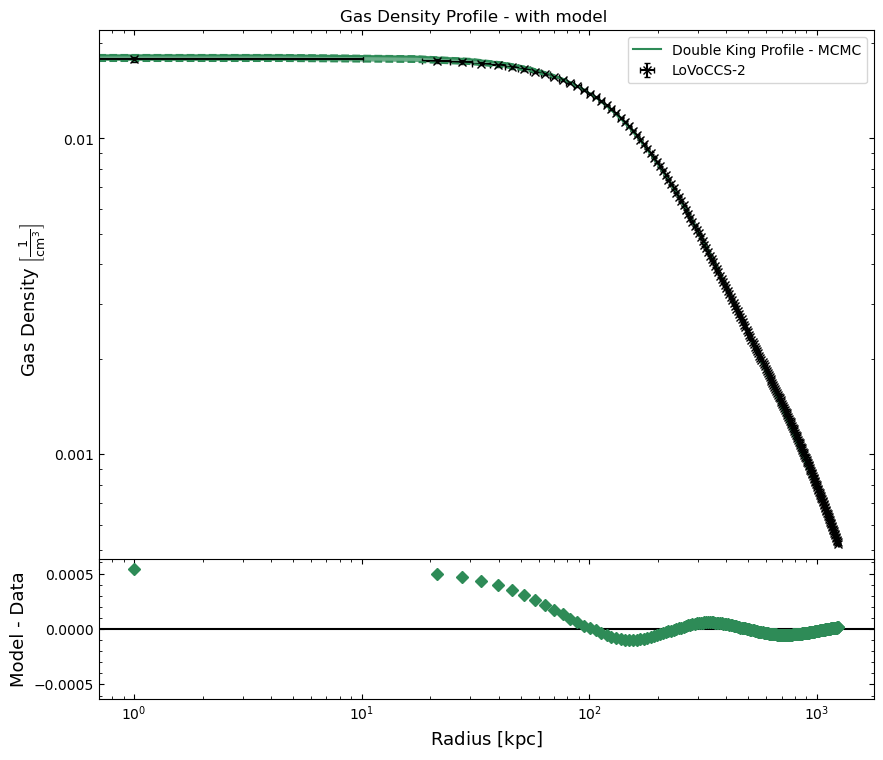

LoVoCCS-3


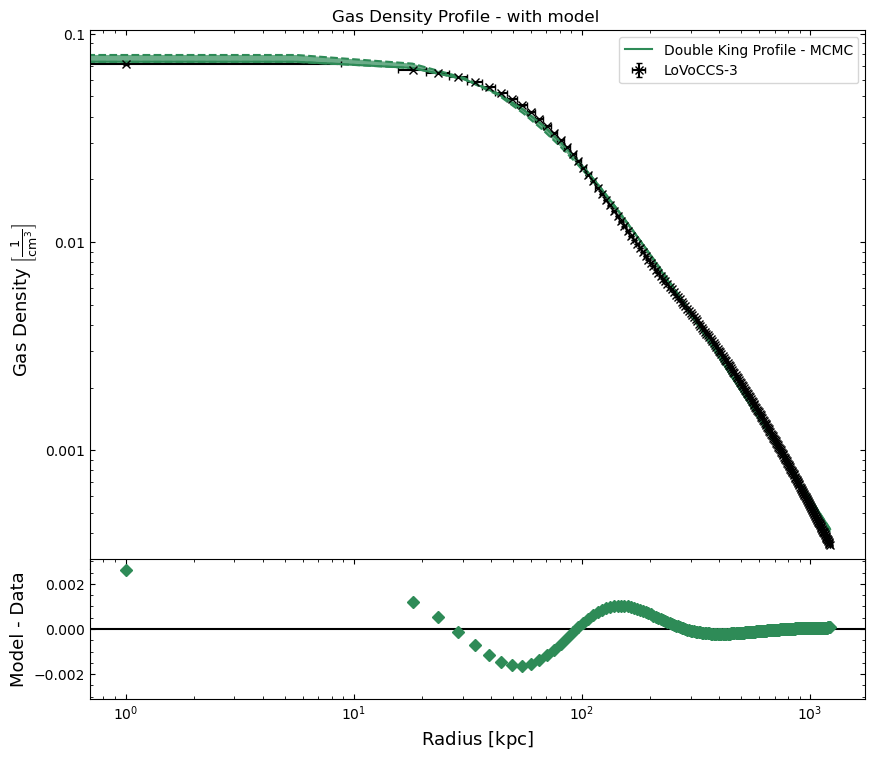

LoVoCCS-5


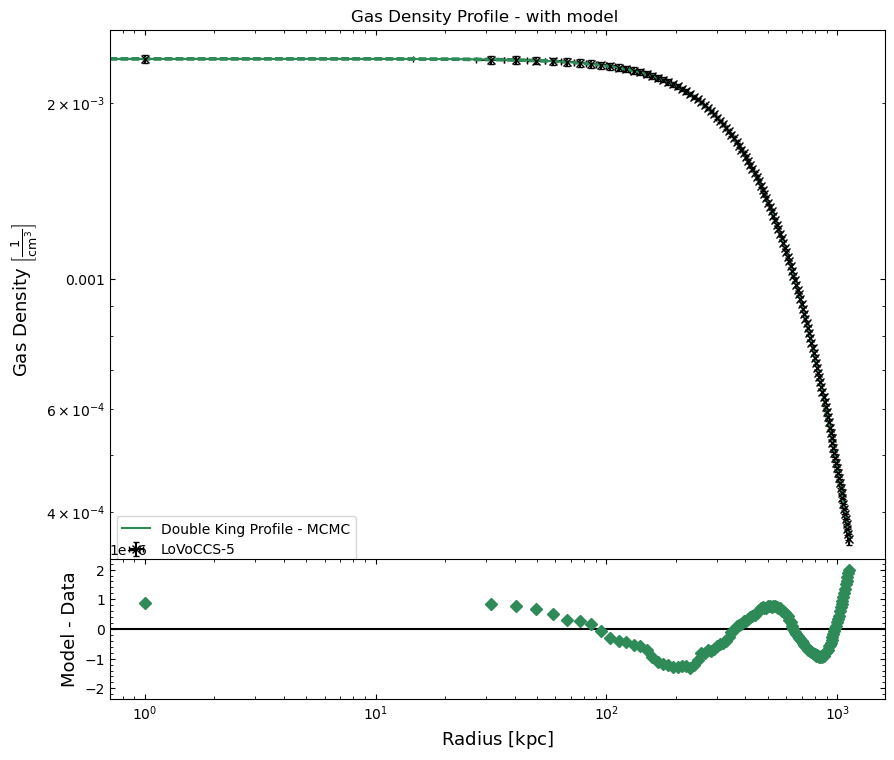

LoVoCCS-6


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
100%|██████████| 30000/30000 [00:39<00:00, 759.12it/s]


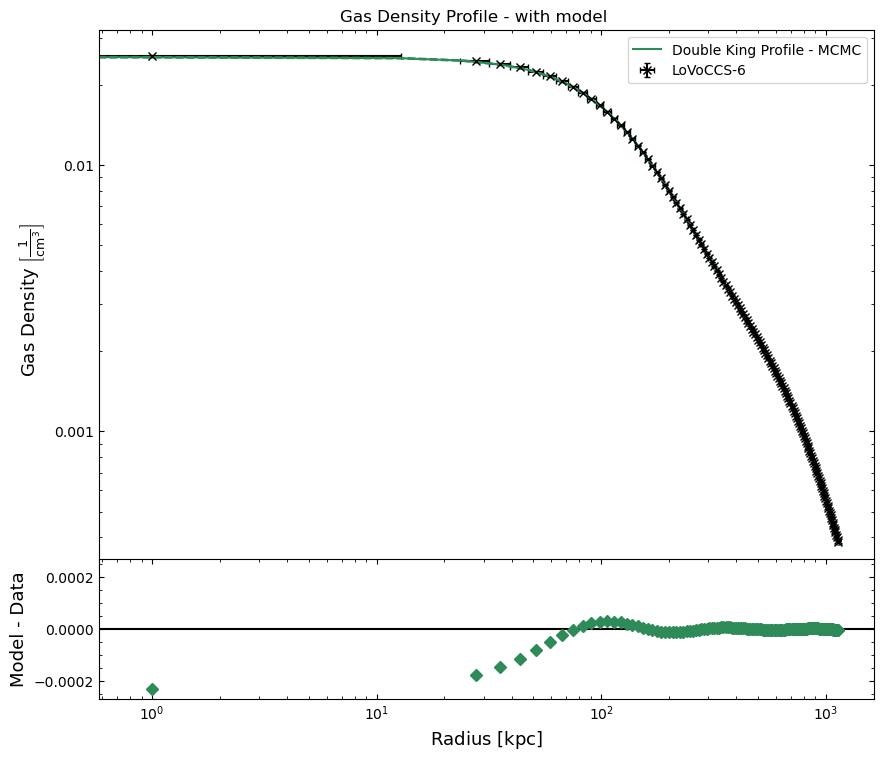

LoVoCCS-7


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
100%|██████████| 30000/30000 [00:35<00:00, 839.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2617.47408724  630.72740767  353.55986198 1119.52837677 1633.36447828
 2418.85746916]


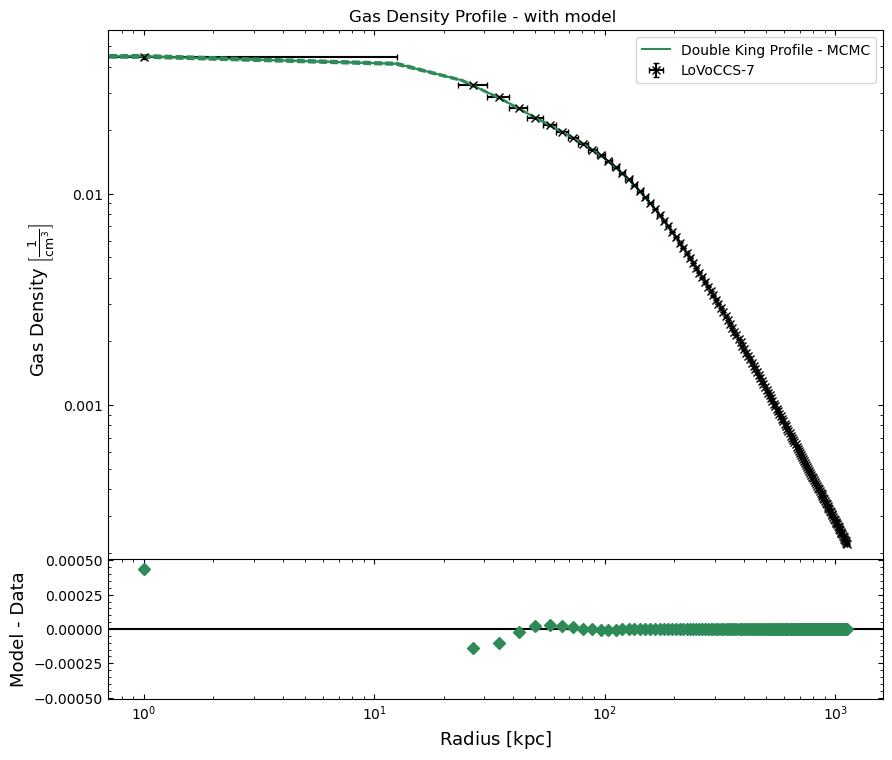

LoVoCCS-8


100%|██████████| 30000/30000 [00:40<00:00, 735.38it/s]


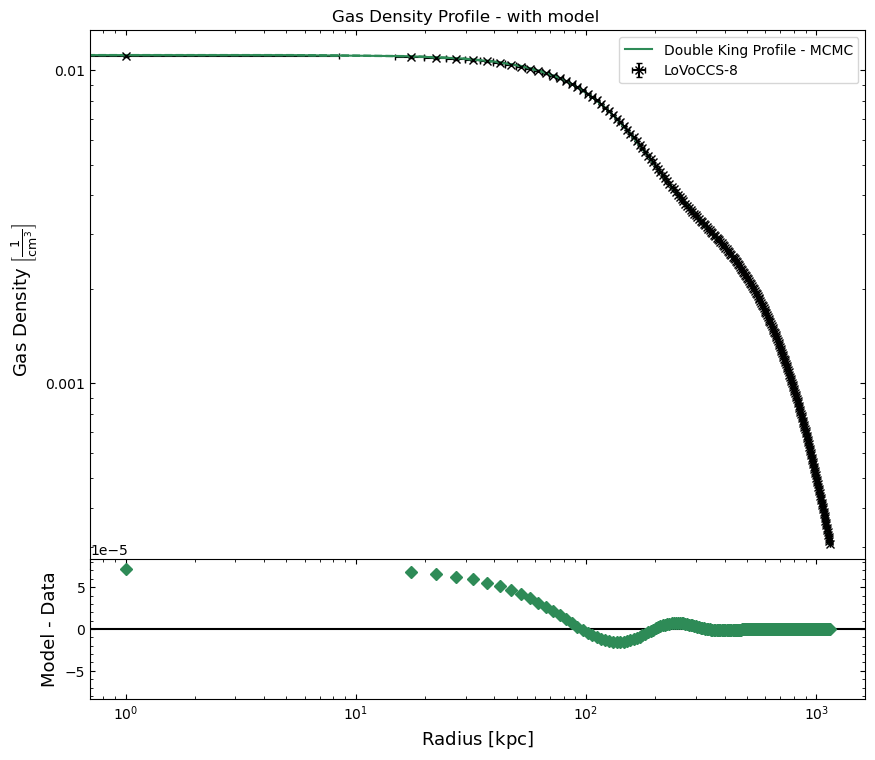

LoVoCCS-9


100%|██████████| 30000/30000 [00:39<00:00, 754.60it/s]


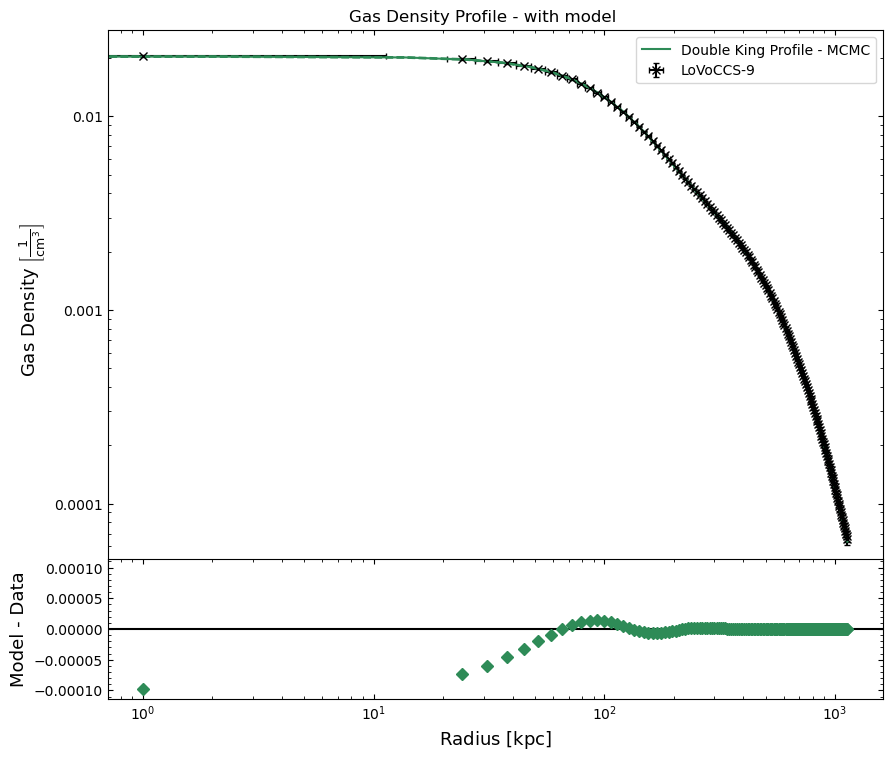

LoVoCCS-11


100%|██████████| 30000/30000 [00:48<00:00, 621.32it/s]


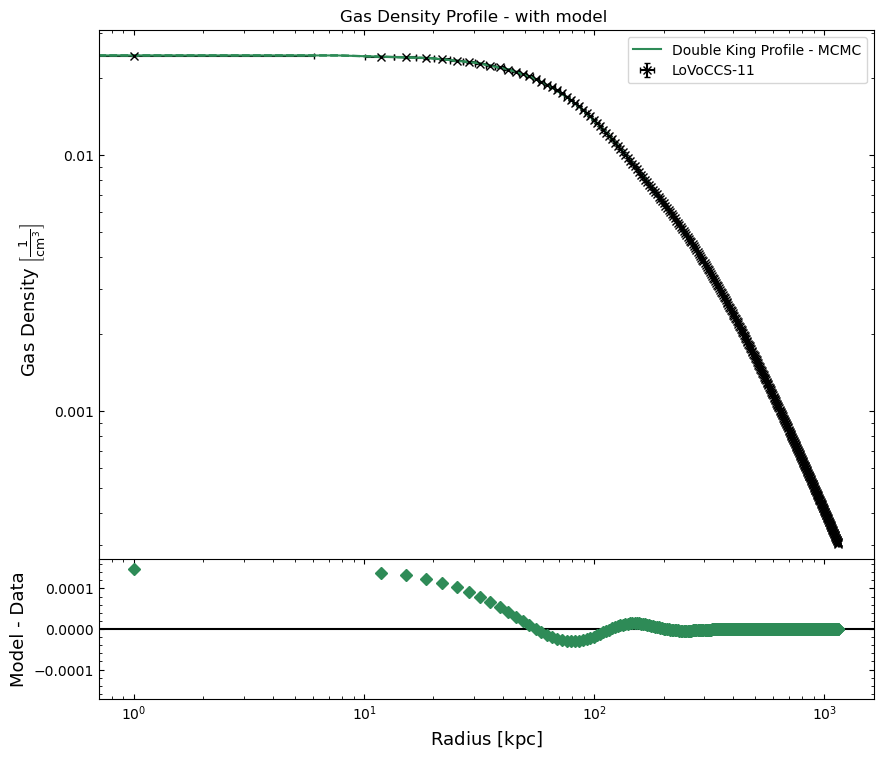

LoVoCCS-12


100%|██████████| 30000/30000 [00:41<00:00, 724.84it/s]


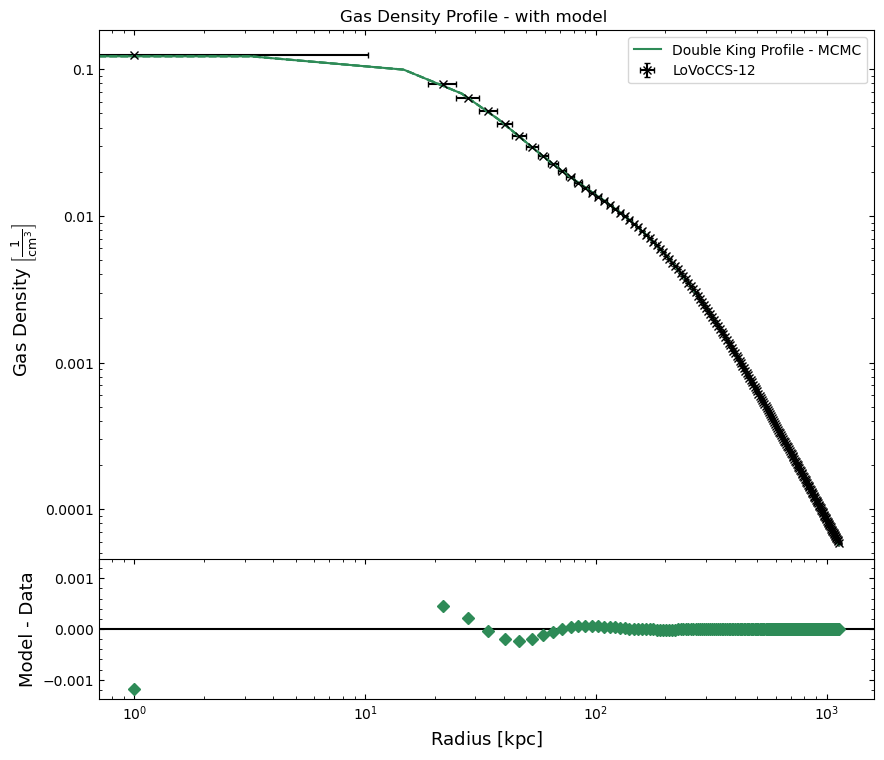

LoVoCCS-13


100%|██████████| 30000/30000 [00:33<00:00, 883.33it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2771.69608738 2797.77713753 3300.34904245 3200.46573871 3206.21105241
 3294.5018583 ]


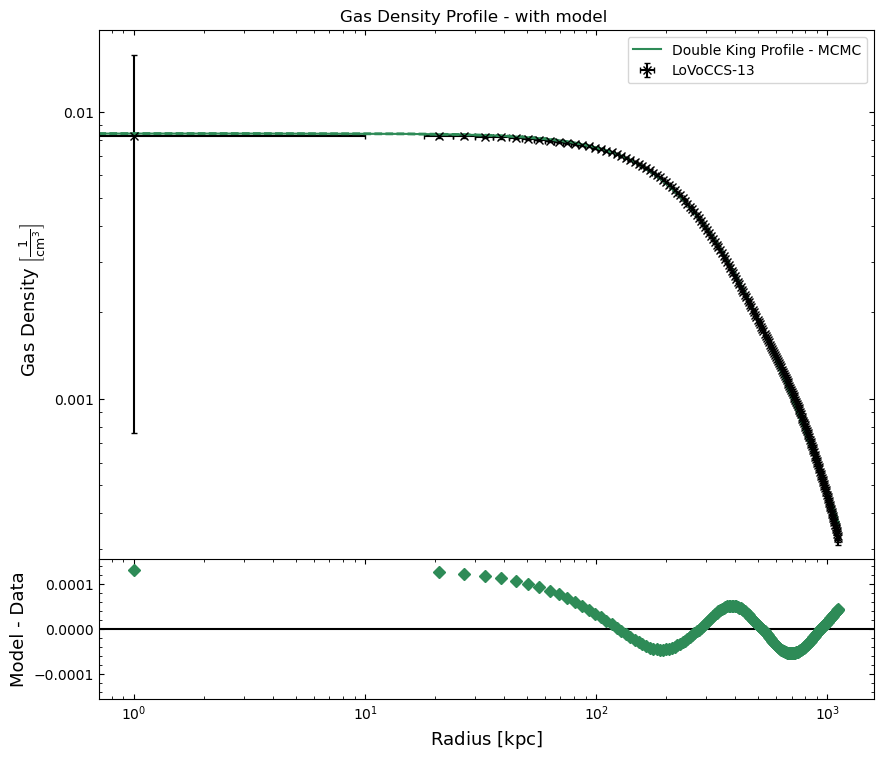

LoVoCCS-14


100%|██████████| 30000/30000 [00:40<00:00, 749.69it/s]


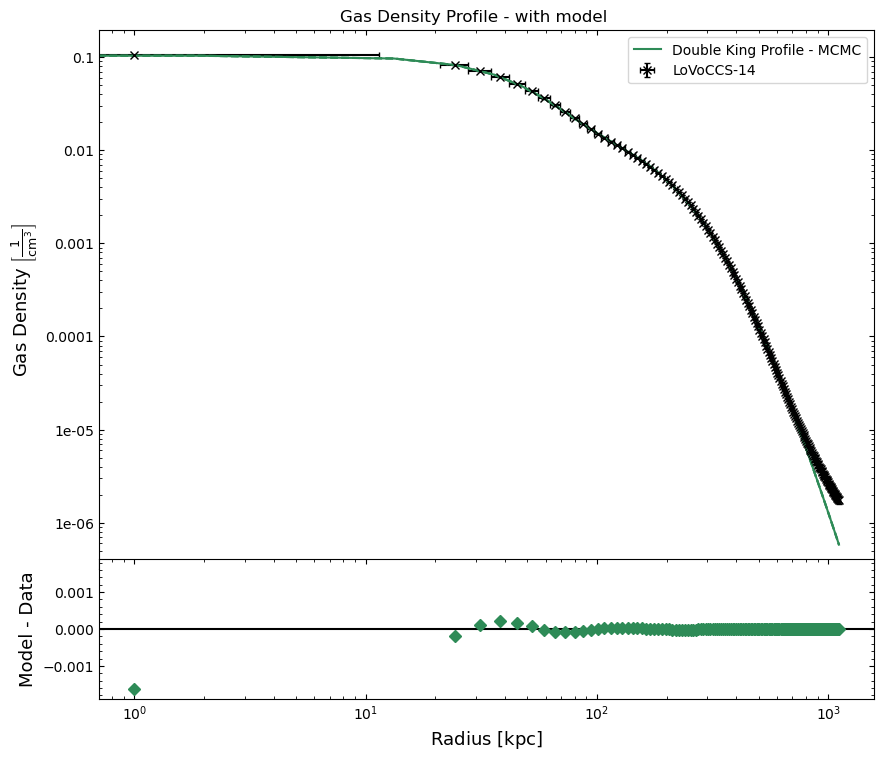

LoVoCCS-15


100%|██████████| 30000/30000 [00:38<00:00, 773.09it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2631.23660859 2461.16373064 3012.28417627 2598.20060509 2672.32144913
 3012.69523255]


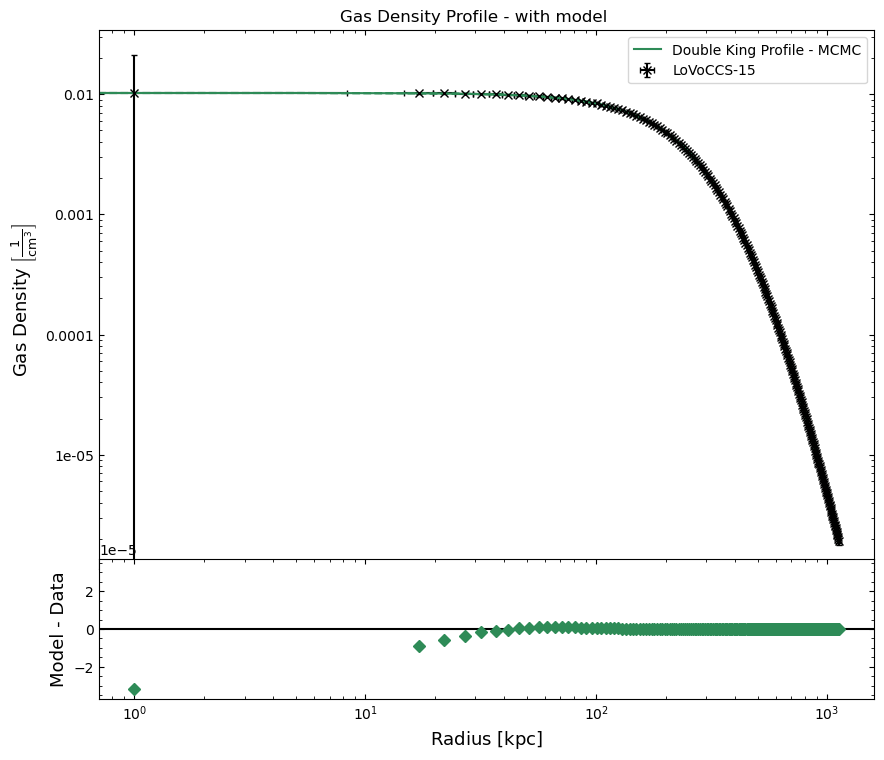

LoVoCCS-16


100%|██████████| 30000/30000 [00:31<00:00, 947.92it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2604.4395788  2408.66133989 2696.78653689 2069.32021355 2718.3743099
 2696.73971919]


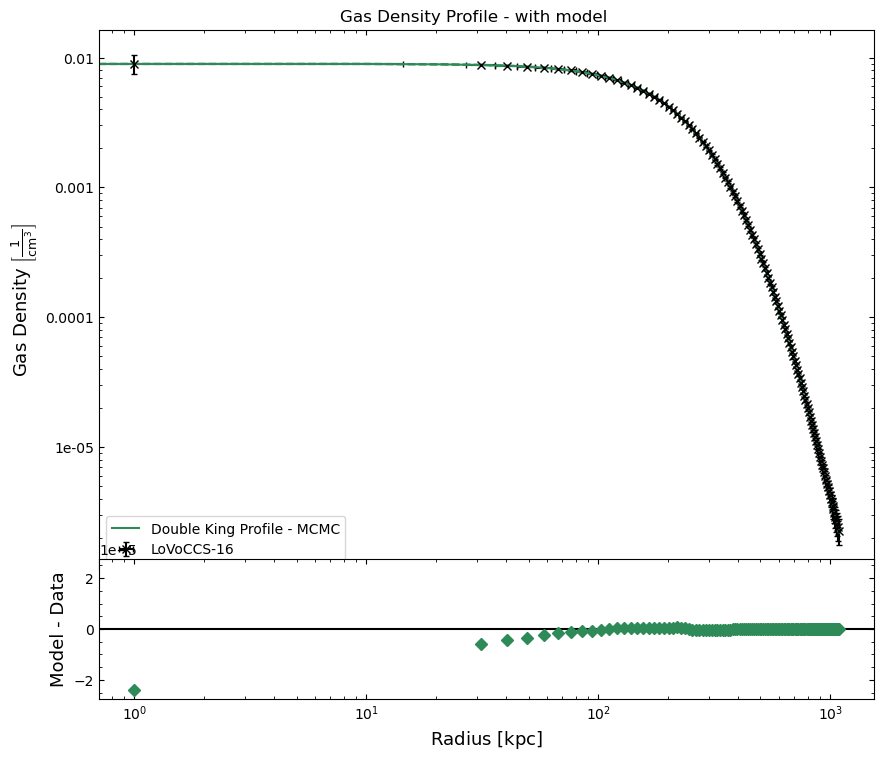

LoVoCCS-17


100%|██████████| 30000/30000 [00:39<00:00, 759.05it/s]


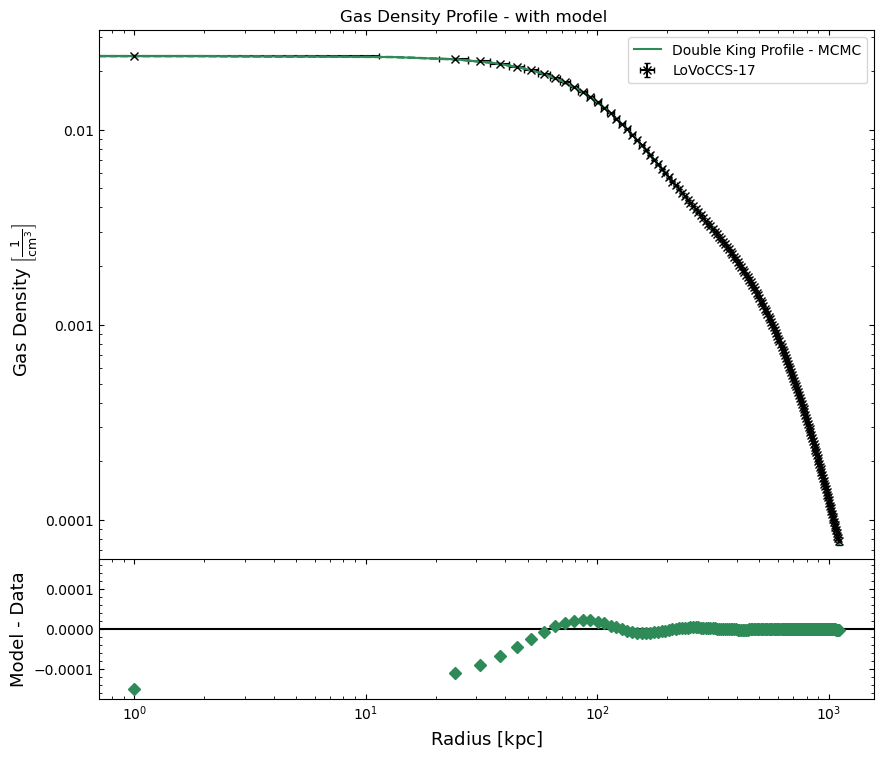

LoVoCCS-19


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
100%|██████████| 30000/30000 [00:34<00:00, 865.91it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 784.79630477 1378.87102128 1958.56232071 1875.39111561  256.74982279
  651.85278462]


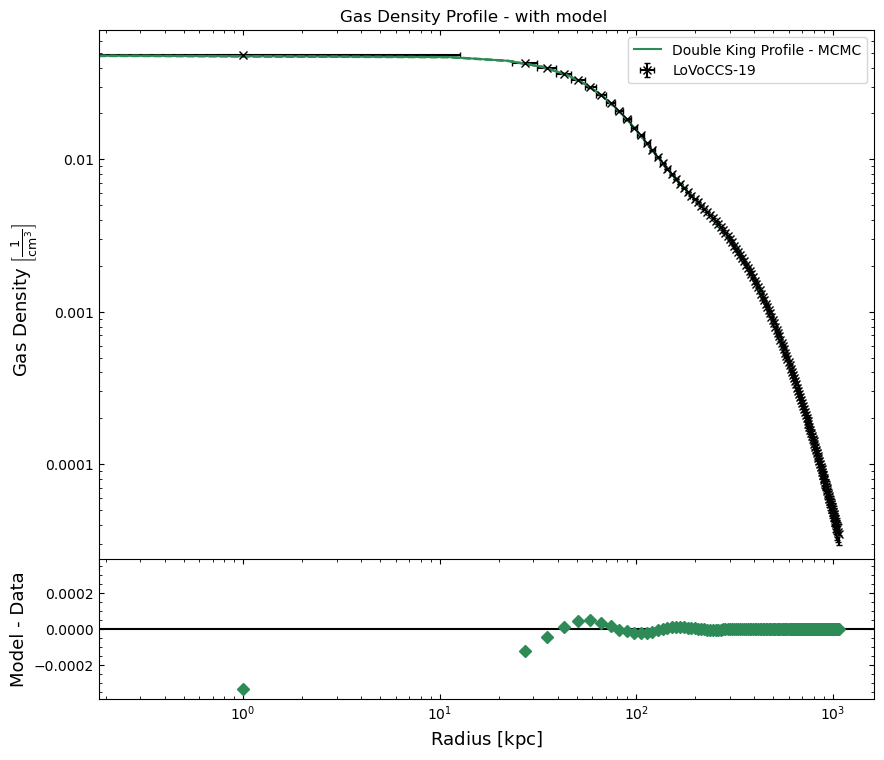

LoVoCCS-20


100%|██████████| 30000/30000 [00:42<00:00, 698.93it/s]


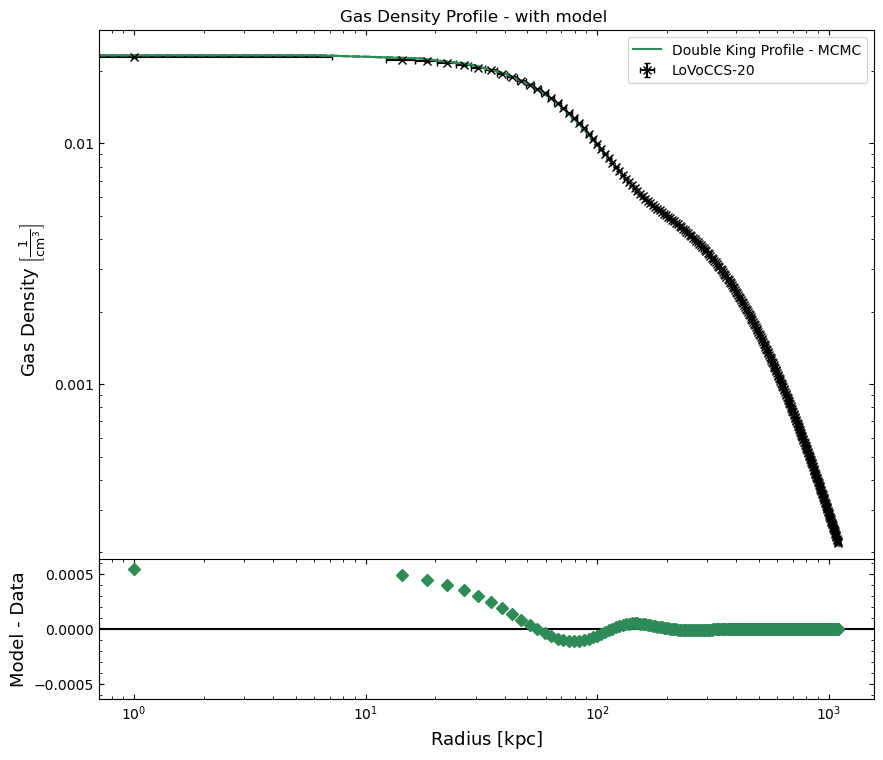

LoVoCCS-21


100%|██████████| 30000/30000 [00:36<00:00, 831.44it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 964.55033503 1029.1851784  1214.62664702 1180.48454919 1196.73939494
 1243.86152278]


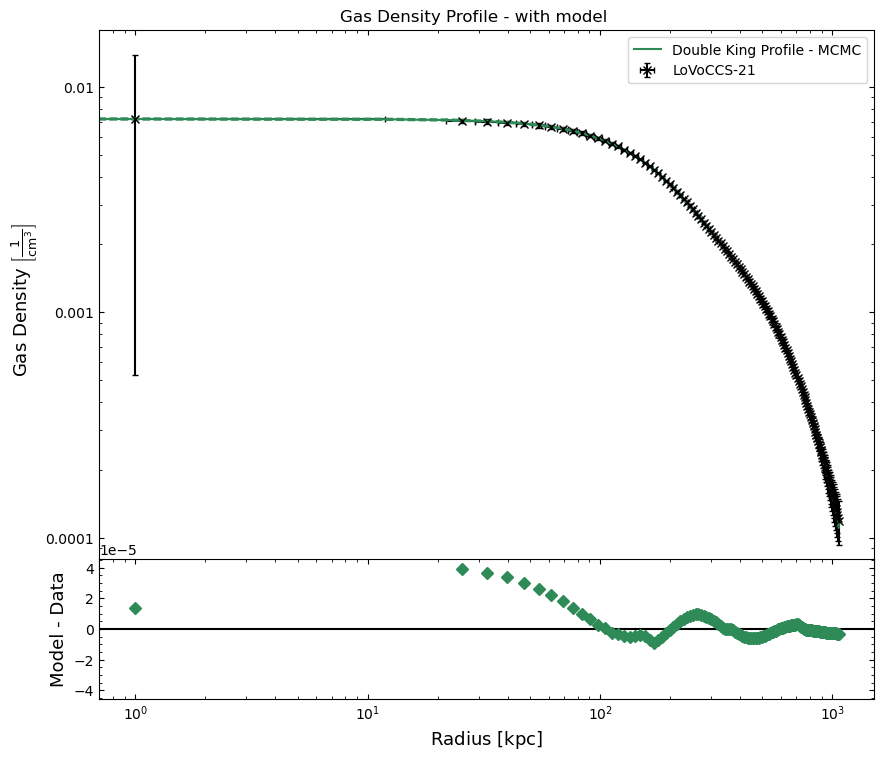

LoVoCCS-22


100%|██████████| 30000/30000 [00:35<00:00, 856.67it/s]


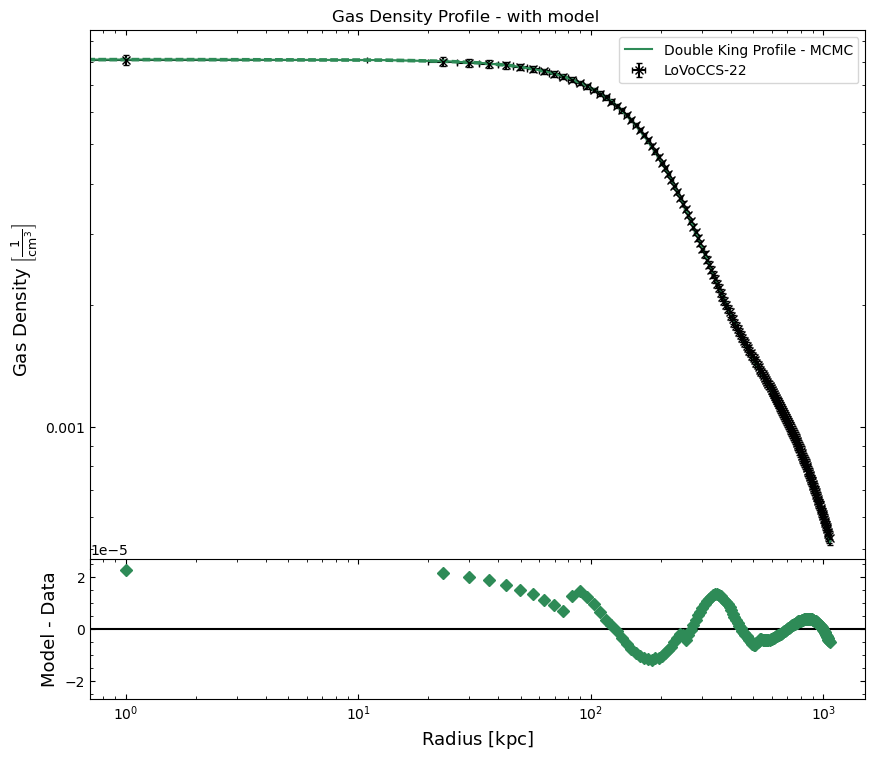

LoVoCCS-23


100%|██████████| 30000/30000 [00:35<00:00, 843.84it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1684.95277156 1841.4594561  2609.85188055 3180.28035951 2528.76814227
  729.54991651]


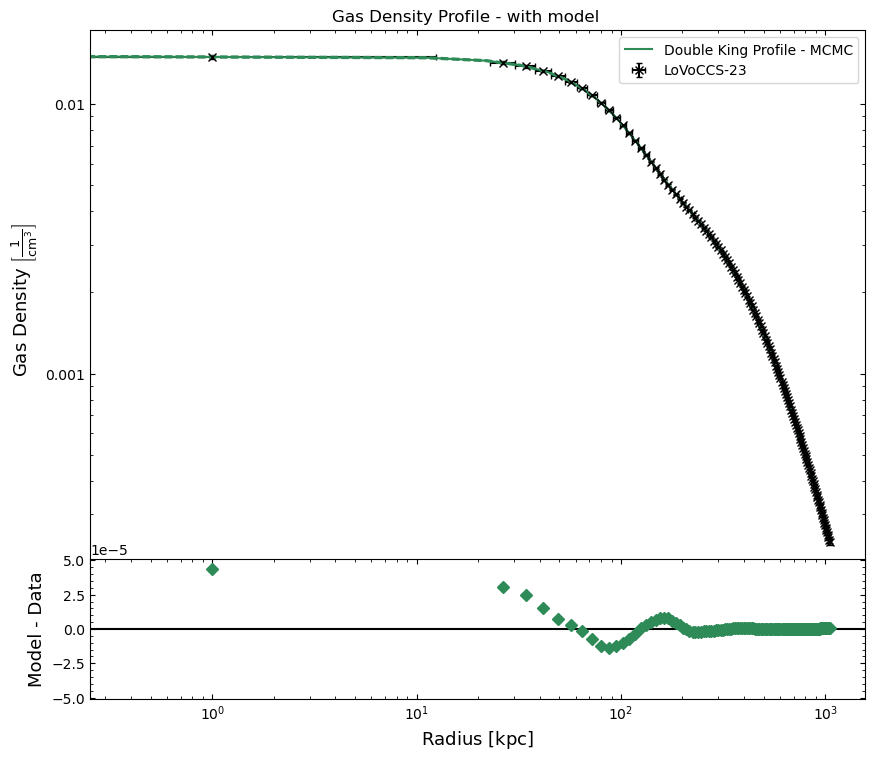

LoVoCCS-25


100%|██████████| 30000/30000 [00:35<00:00, 849.29it/s]


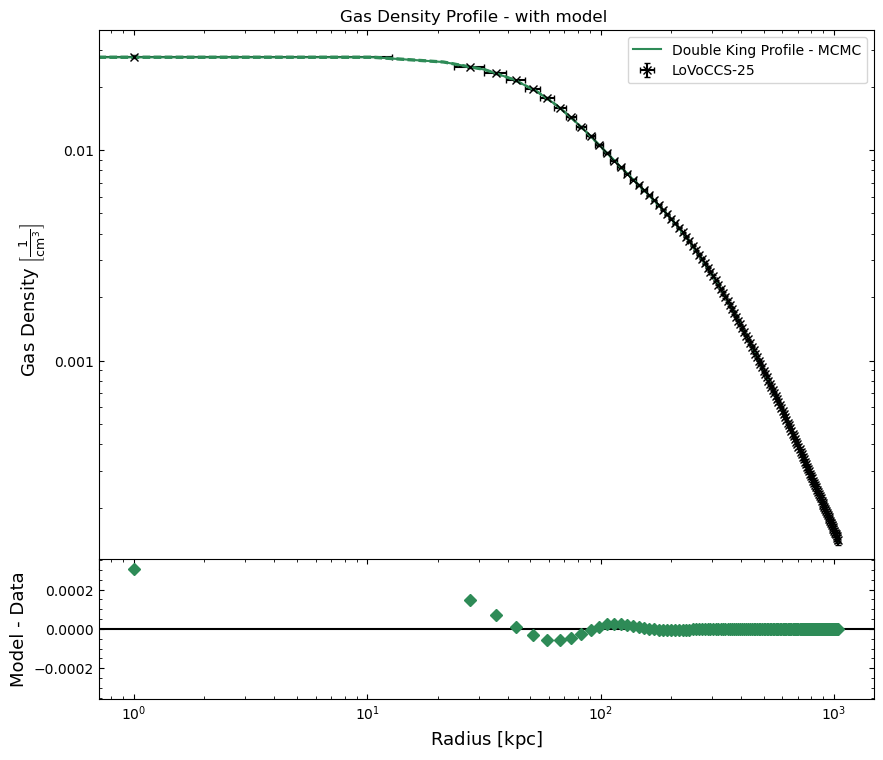

LoVoCCS-26


100%|██████████| 30000/30000 [00:35<00:00, 834.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2895.12651912 2453.84303554 2470.62112725 2336.98308887 2781.72752722
 2977.20675844]


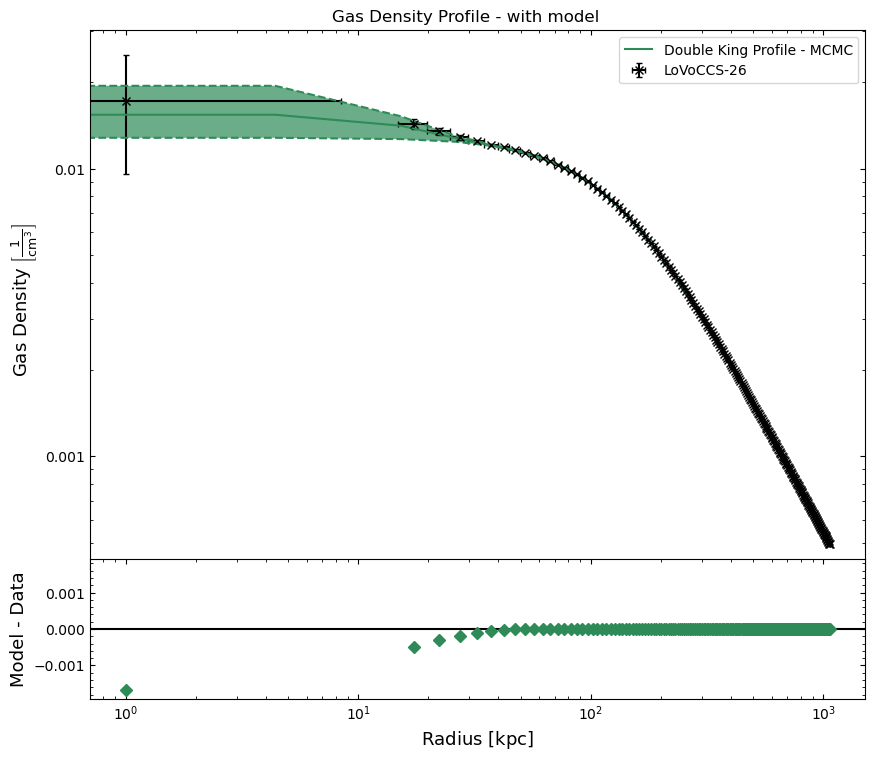

LoVoCCS-27


100%|██████████| 30000/30000 [00:36<00:00, 823.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2127.48838837 2187.06788197 2865.81836036 2994.74759601 3040.43325472
 2876.55959751]


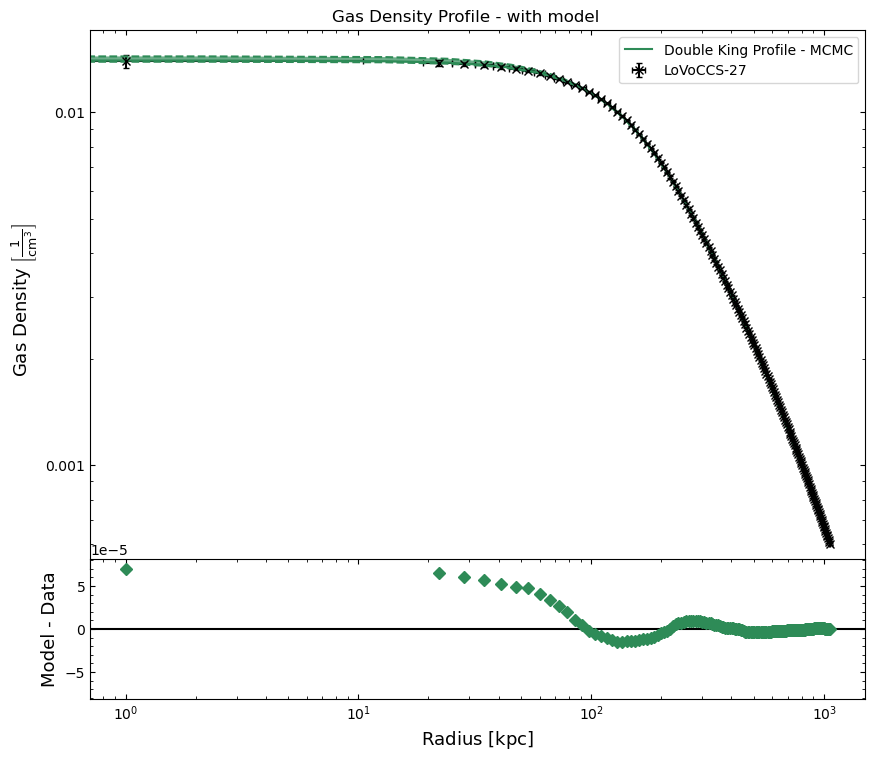

LoVoCCS-28


100%|██████████| 30000/30000 [00:33<00:00, 895.97it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [371.2397537  384.60865577 544.25438277 673.63100436 701.23904183
 613.18924218]


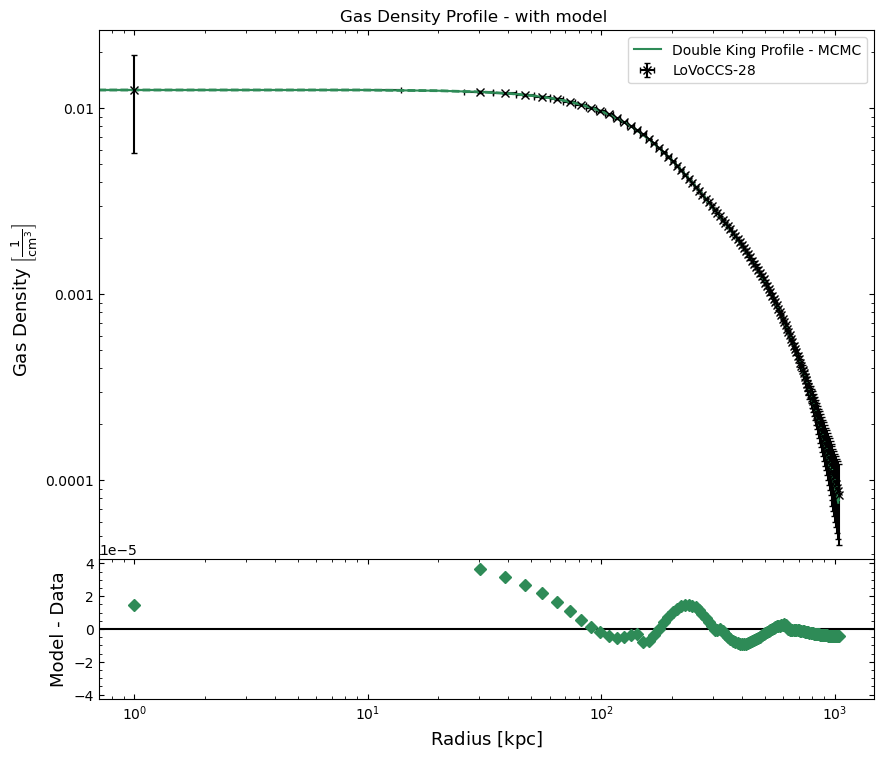

LoVoCCS-30


100%|██████████| 30000/30000 [00:36<00:00, 815.20it/s]


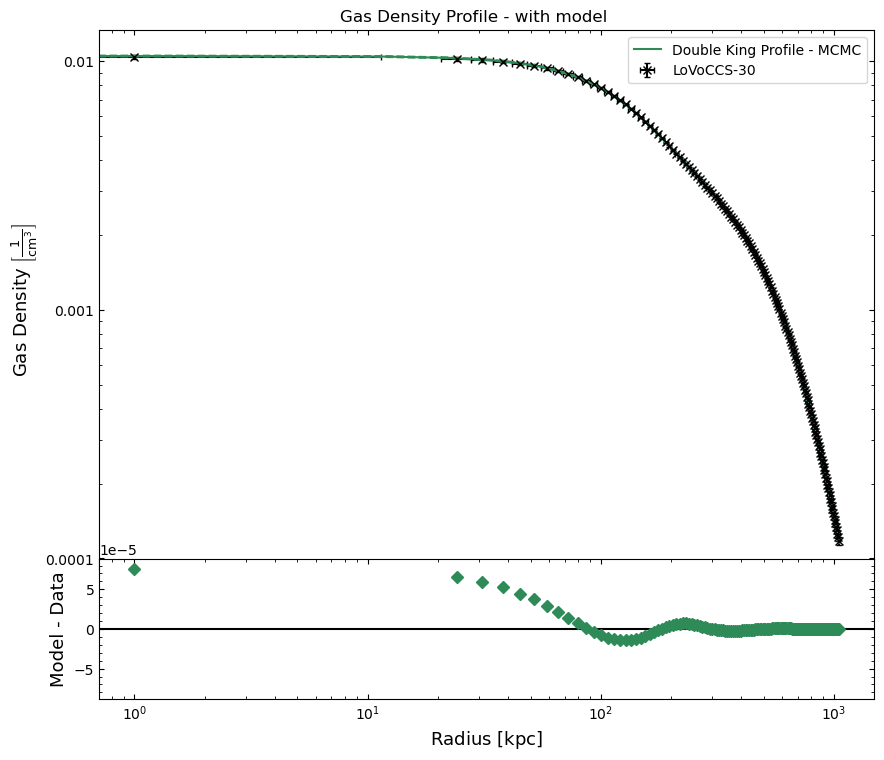

LoVoCCS-31


100%|██████████| 30000/30000 [00:37<00:00, 797.54it/s]


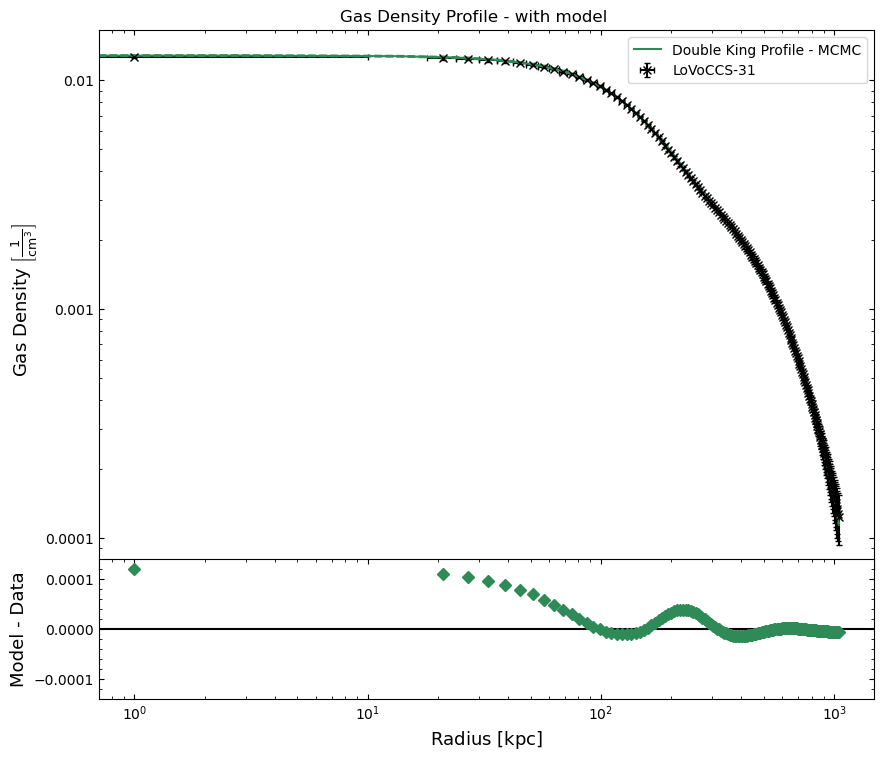

LoVoCCS-33


100%|██████████| 30000/30000 [00:34<00:00, 875.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1840.71519331 1890.54986598 2123.18122588 1673.17409413 1849.37825193
 2111.3733963 ]


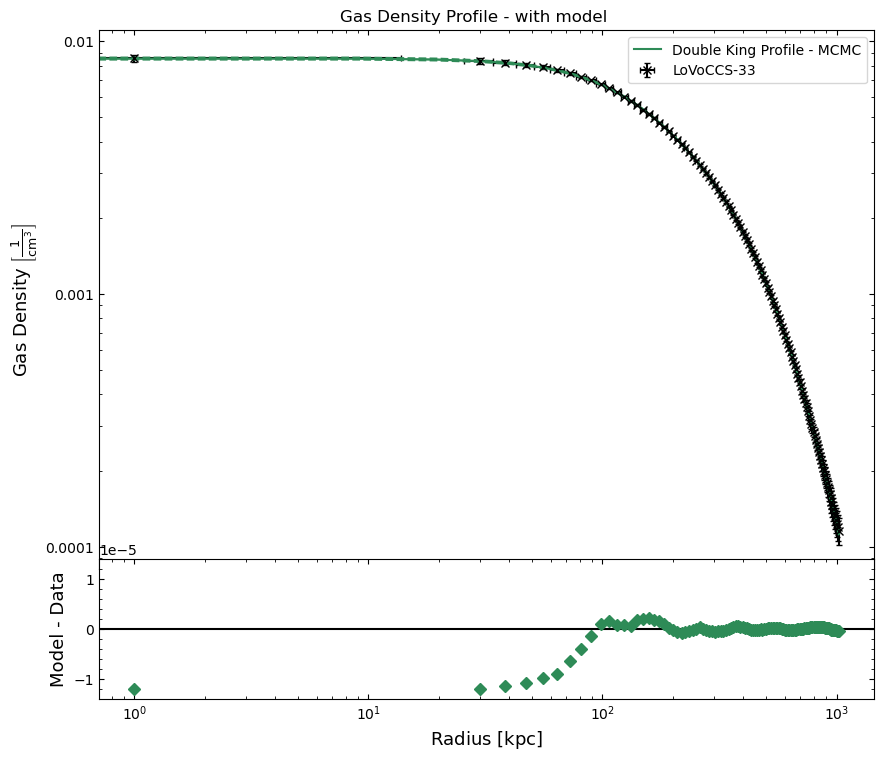

LoVoCCS-34


100%|██████████| 30000/30000 [00:35<00:00, 851.30it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 781.56131566  862.15385233 1159.19070723  925.29746532  972.39324381
  951.73214039]


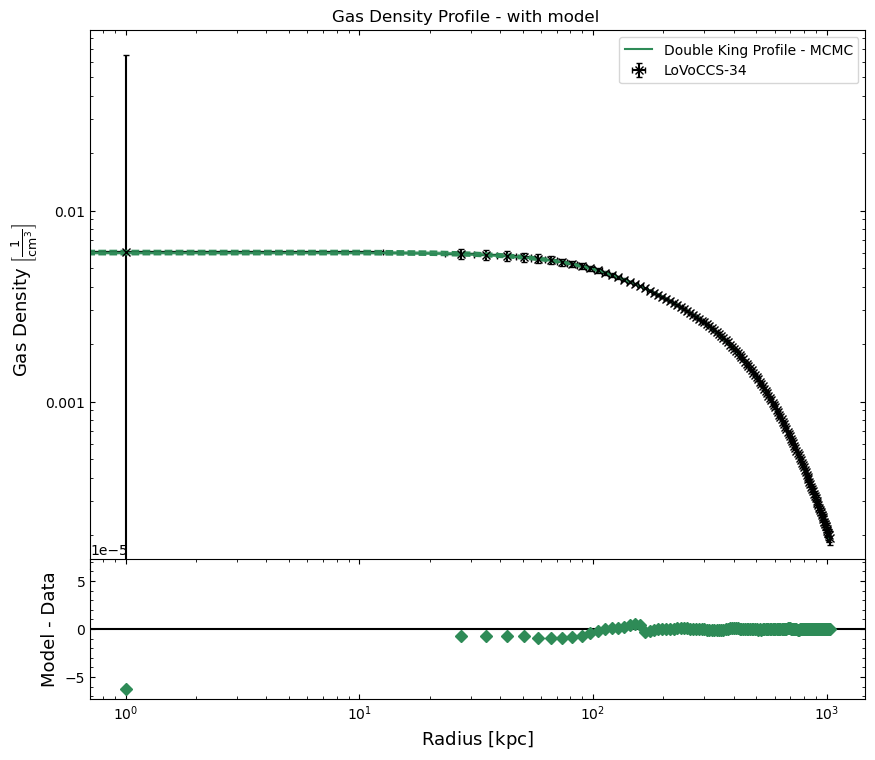

LoVoCCS-35


100%|██████████| 30000/30000 [00:32<00:00, 920.06it/s]


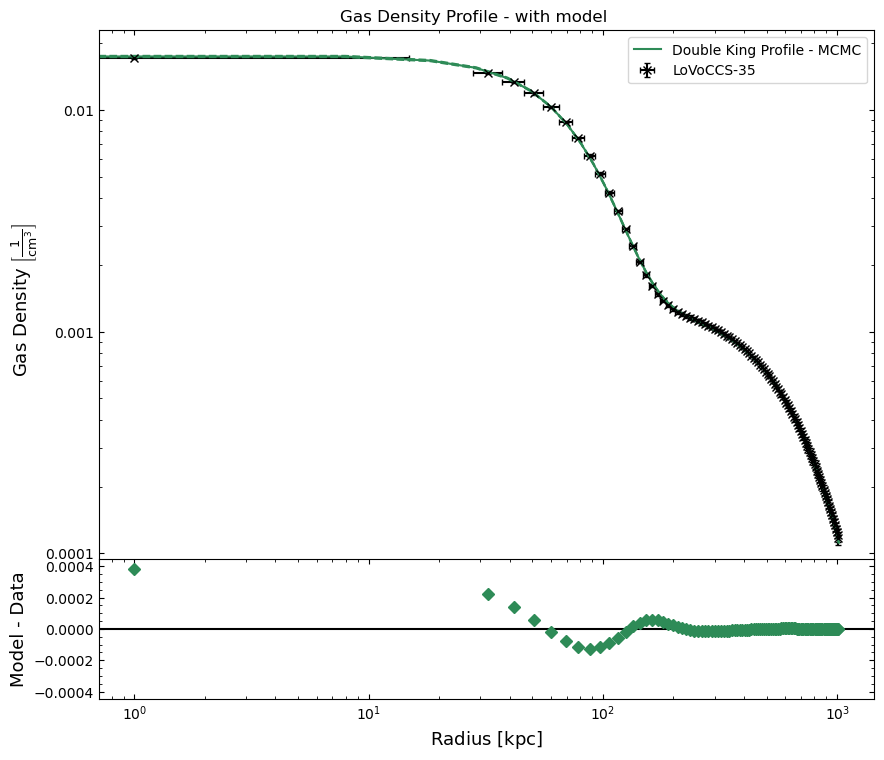

LoVoCCS-36


100%|██████████| 30000/30000 [00:34<00:00, 862.17it/s]


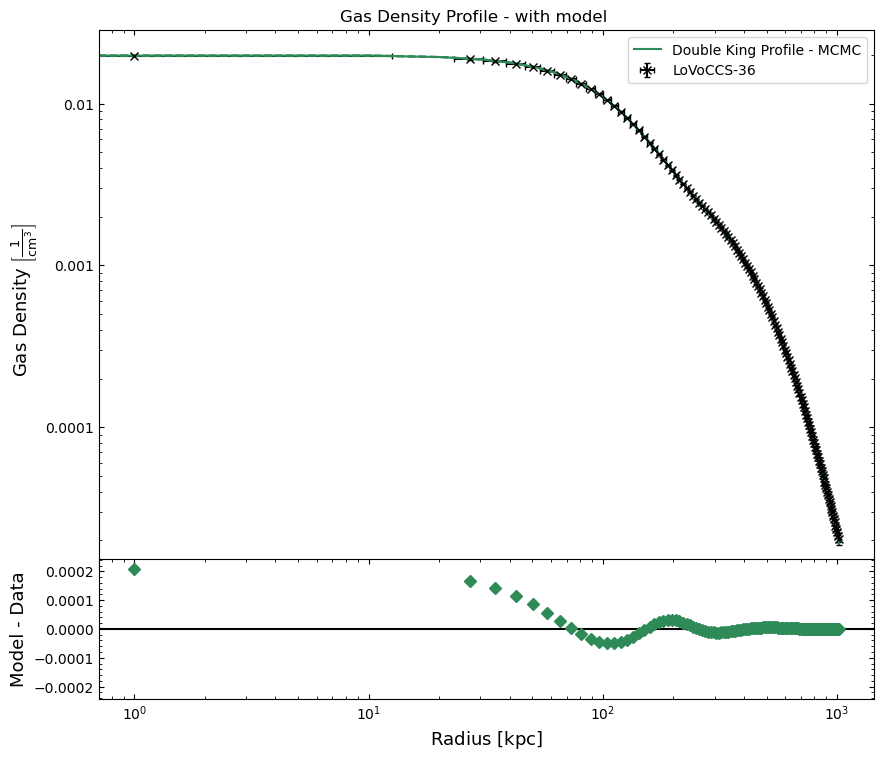

LoVoCCS-38


100%|██████████| 30000/30000 [00:34<00:00, 881.80it/s]


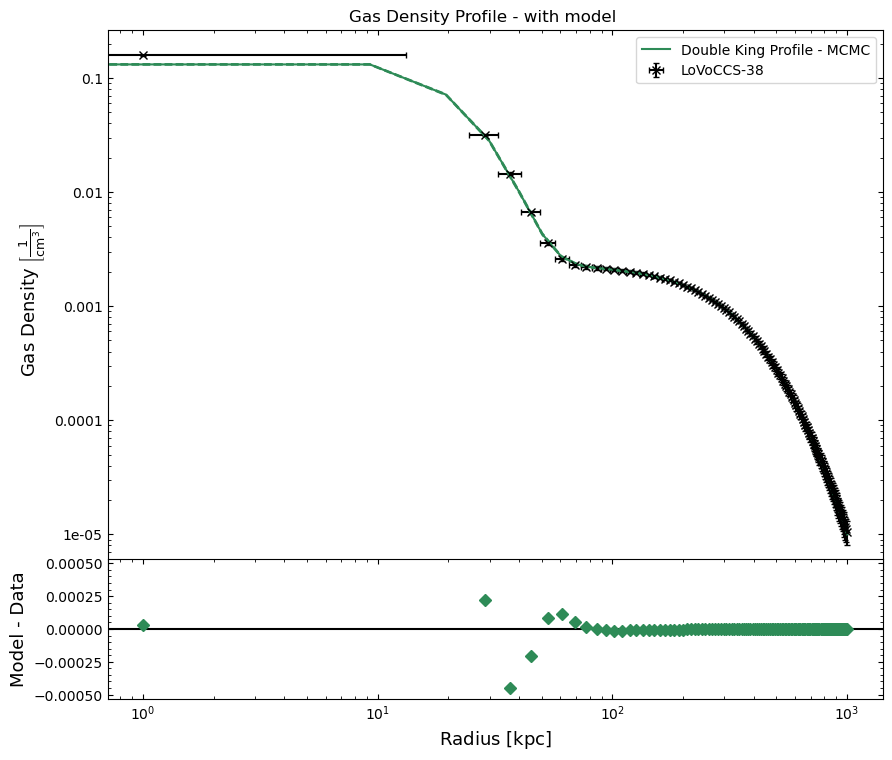

LoVoCCS-39


100%|██████████| 30000/30000 [00:37<00:00, 800.01it/s]


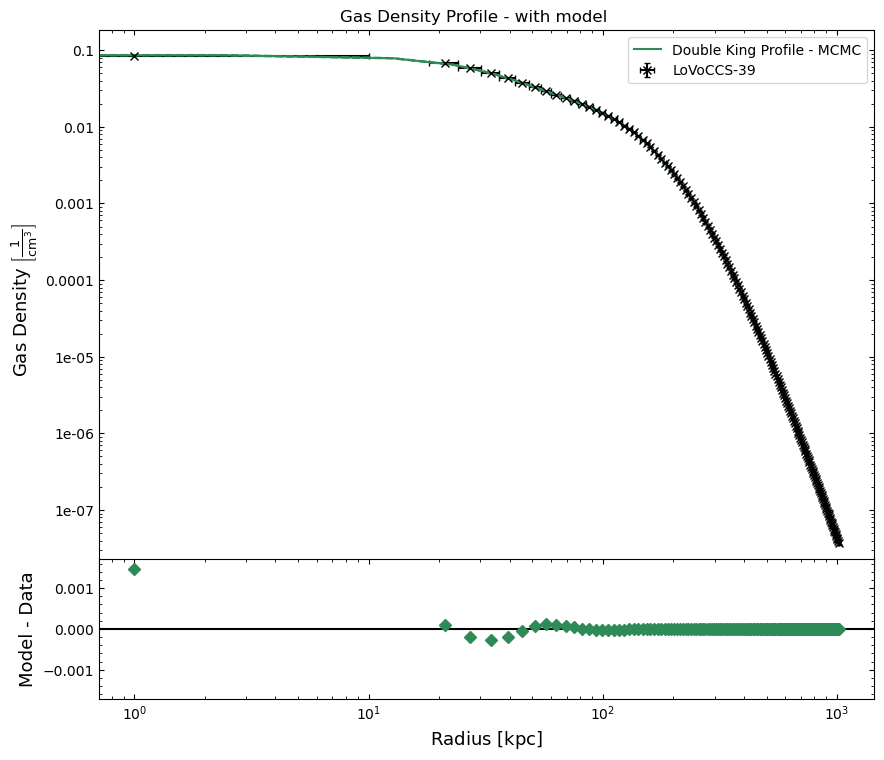

LoVoCCS-40


100%|██████████| 30000/30000 [00:36<00:00, 821.83it/s]


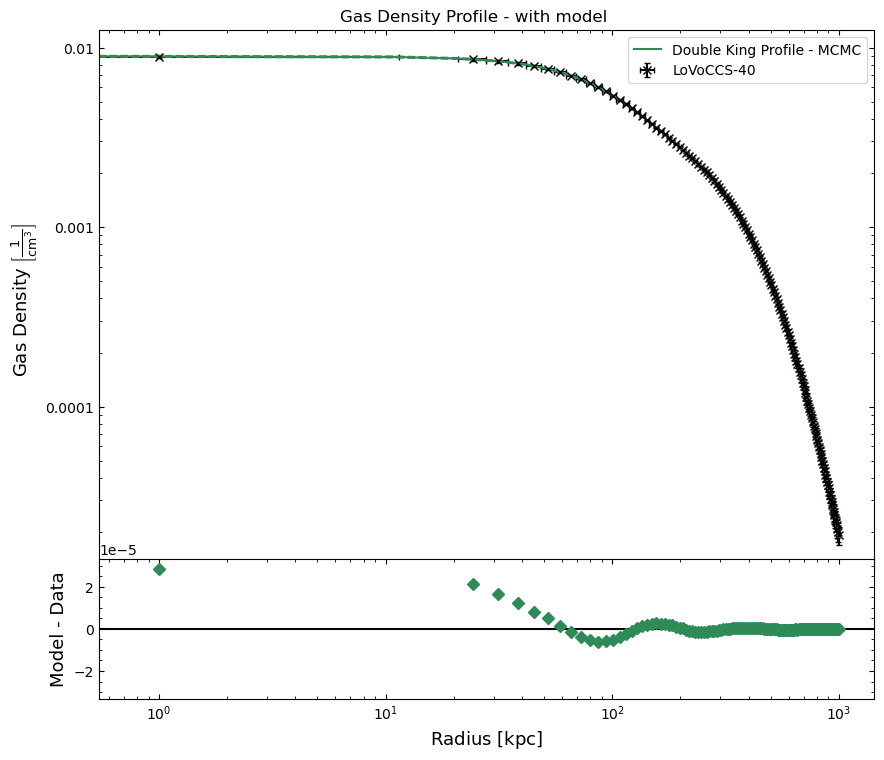

LoVoCCS-41


100%|██████████| 30000/30000 [00:36<00:00, 815.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [721.58193962 708.32731784 790.21886879 882.01326892 846.68537655
 898.34593025]


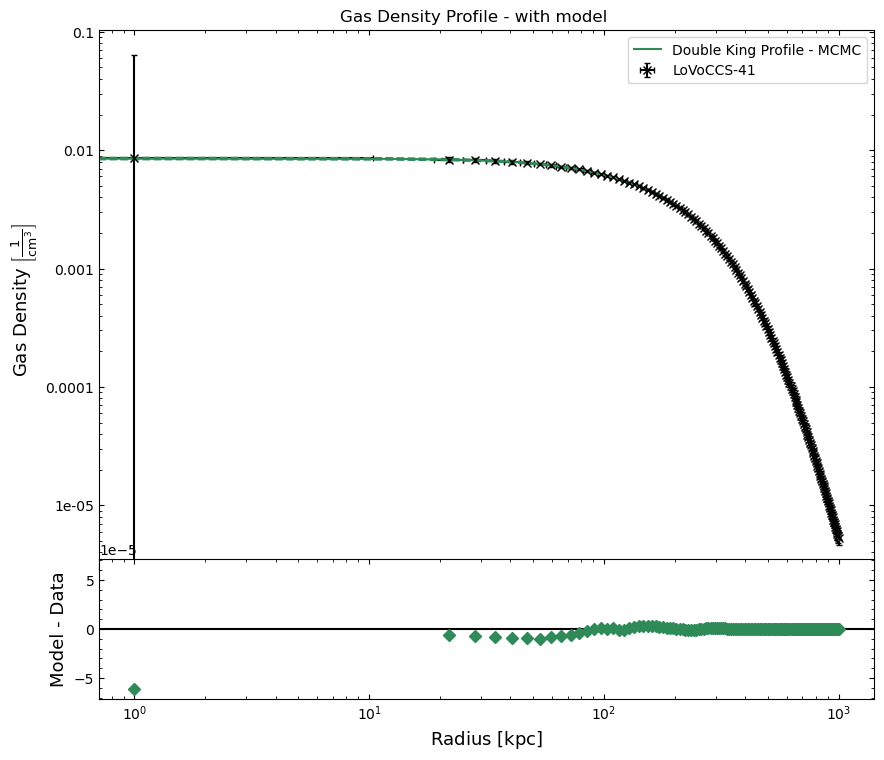

LoVoCCS-42


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
100%|██████████| 30000/30000 [00:26<00:00, 1115.12it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 539.37613922 1562.0814996  2505.10539611 2021.80324016 2151.81026685
 2956.97870969]


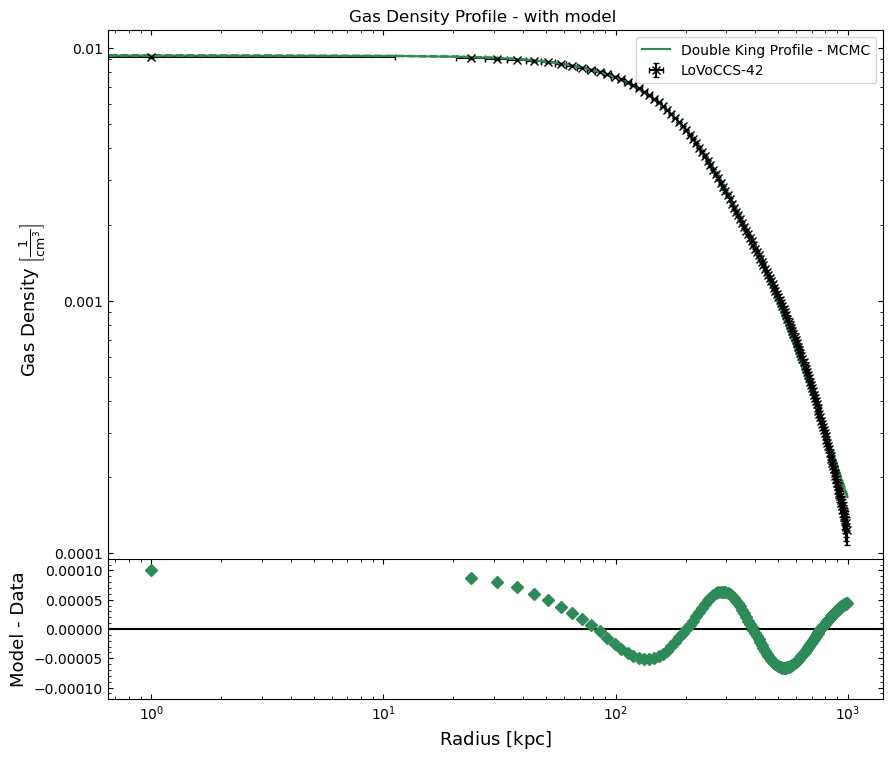

LoVoCCS-43


100%|██████████| 30000/30000 [00:28<00:00, 1062.06it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2768.16767595 2814.45430811 1217.24262477 1196.64755937 1352.77046311
  931.97217616]


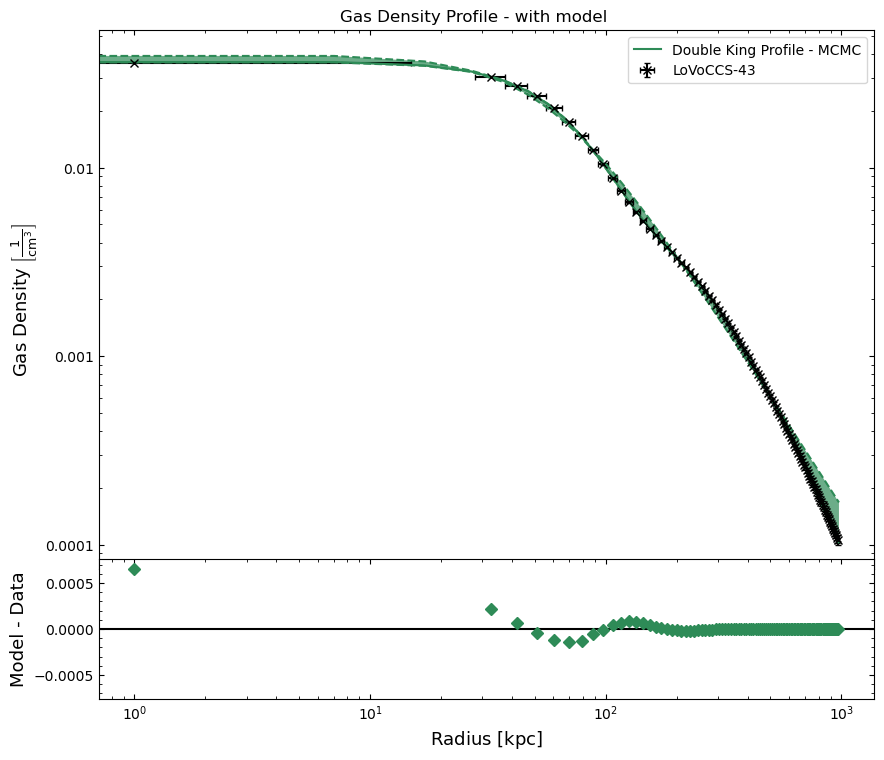

LoVoCCS-44


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
100%|██████████| 30000/30000 [00:25<00:00, 1199.95it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1269.02482772 1723.04982246 2656.41176015 1298.38308832 1941.74156431
 1919.25915999]


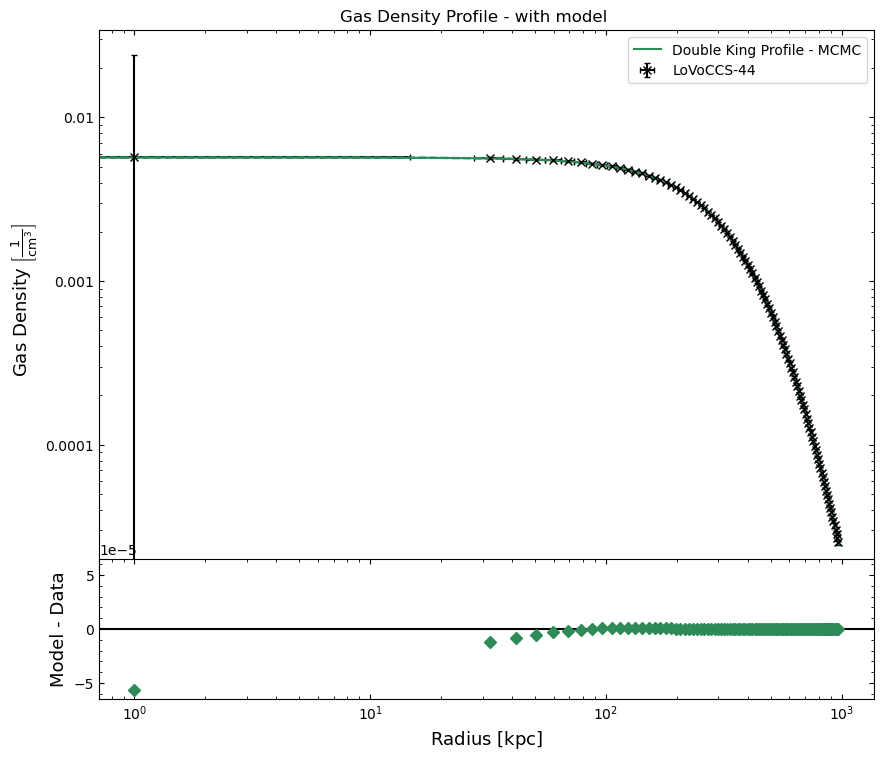

LoVoCCS-45


100%|██████████| 30000/30000 [00:35<00:00, 852.83it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 616.9047801   658.2646466  1172.35669192 1351.54195634 1275.3683956
 1280.34393768]


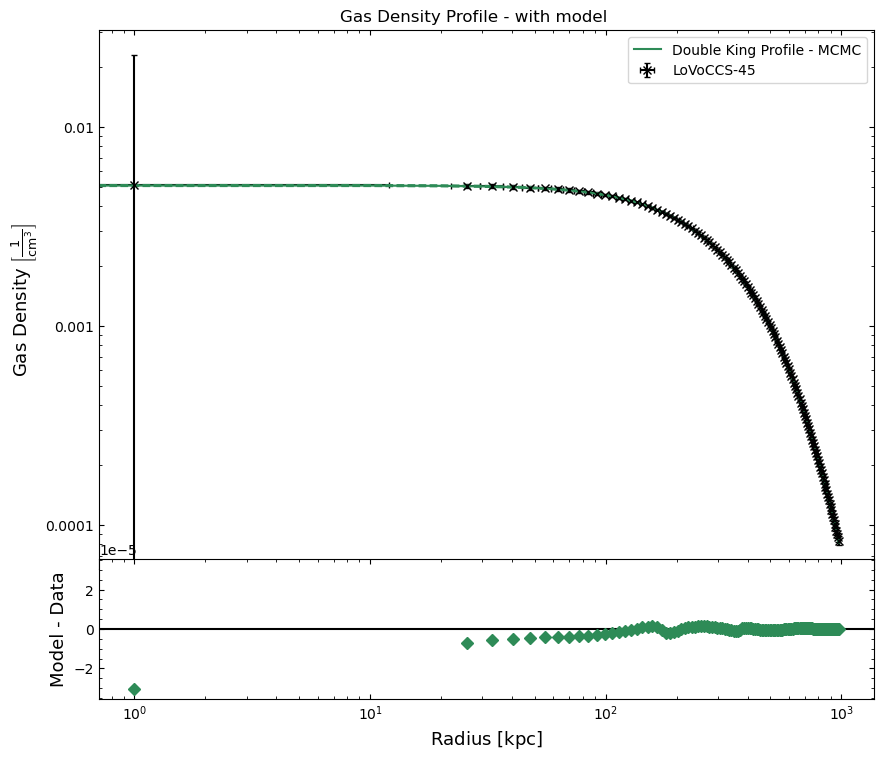

LoVoCCS-47


100%|██████████| 30000/30000 [00:36<00:00, 818.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3432.92760736 3529.47899047 2940.05566064 3097.99955548 3400.91304431
 2892.08794966]


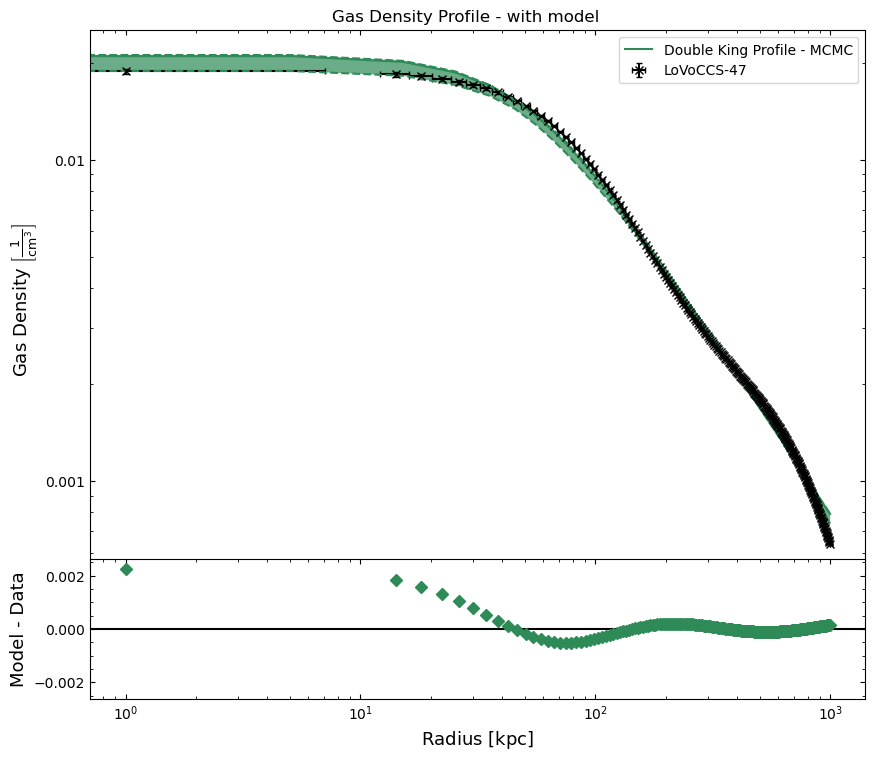

LoVoCCS-48


100%|██████████| 30000/30000 [00:27<00:00, 1105.76it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3435.35830547 3356.87281003 2480.12267784 3296.01078522 3233.69577396
 2566.55064754]


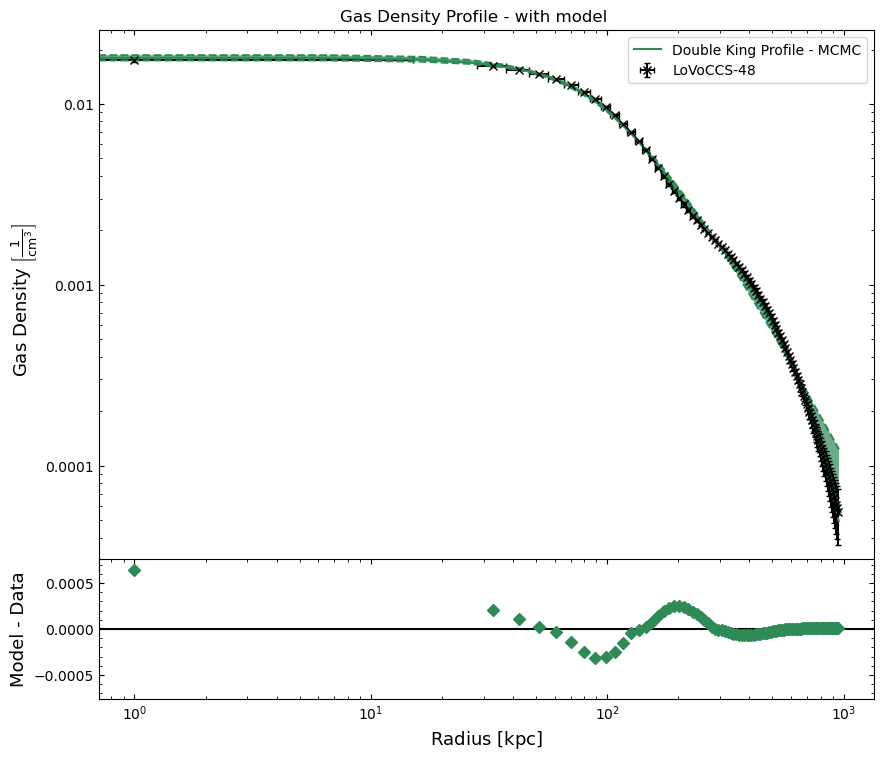

LoVoCCS-50


100%|██████████| 30000/30000 [00:33<00:00, 896.54it/s]


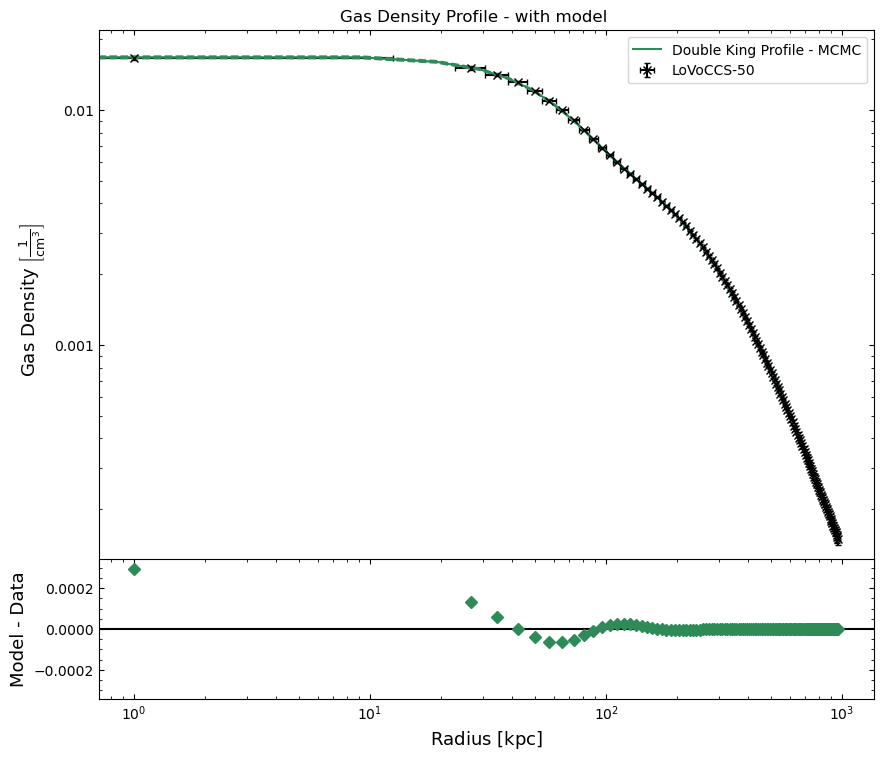

LoVoCCS-52


100%|██████████| 30000/30000 [00:36<00:00, 817.87it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1635.63863257 1789.86004641 2090.17313363 1982.51328779 1955.53640608
 2097.15892217]


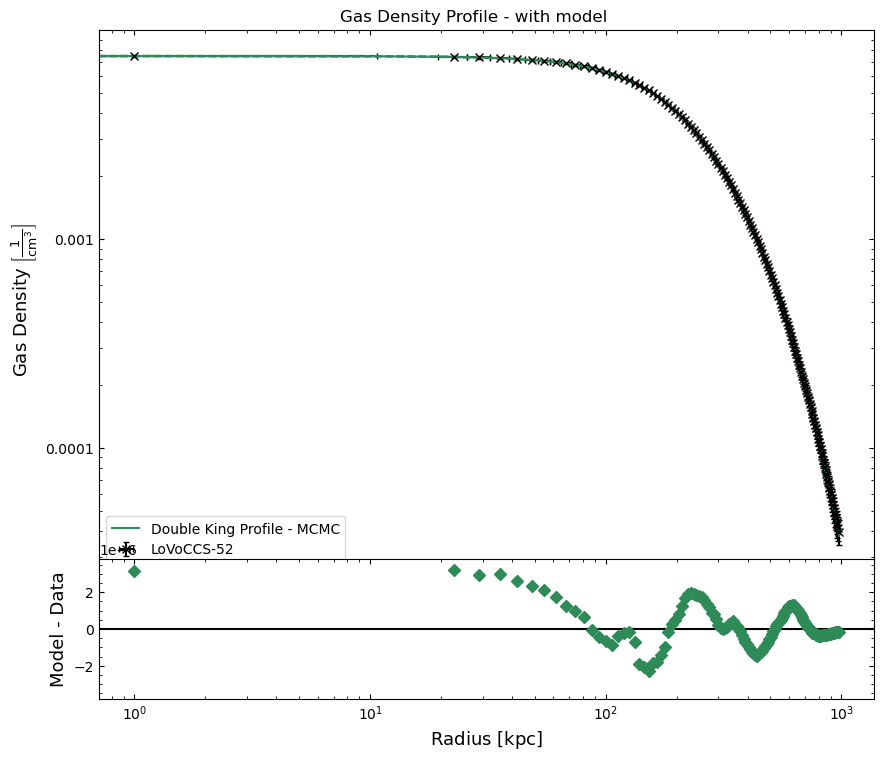

LoVoCCS-55


100%|██████████| 30000/30000 [00:39<00:00, 767.47it/s]


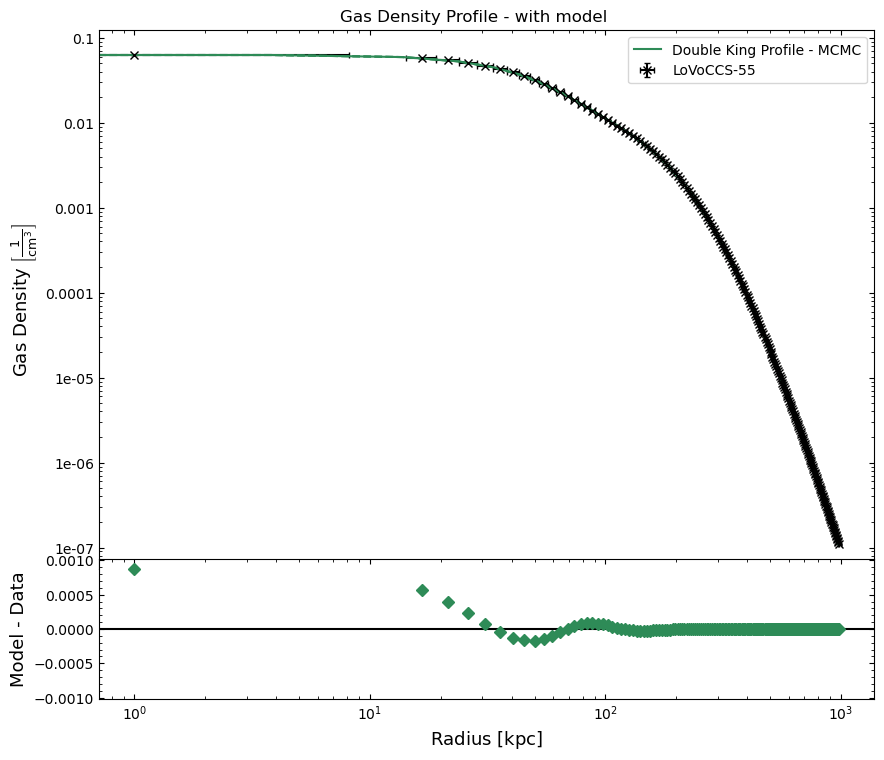

LoVoCCS-56


100%|██████████| 30000/30000 [00:25<00:00, 1194.64it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1176.68311523 2679.880025   2167.78555585 1559.75519521 1489.10382987
 1829.7532244 ]


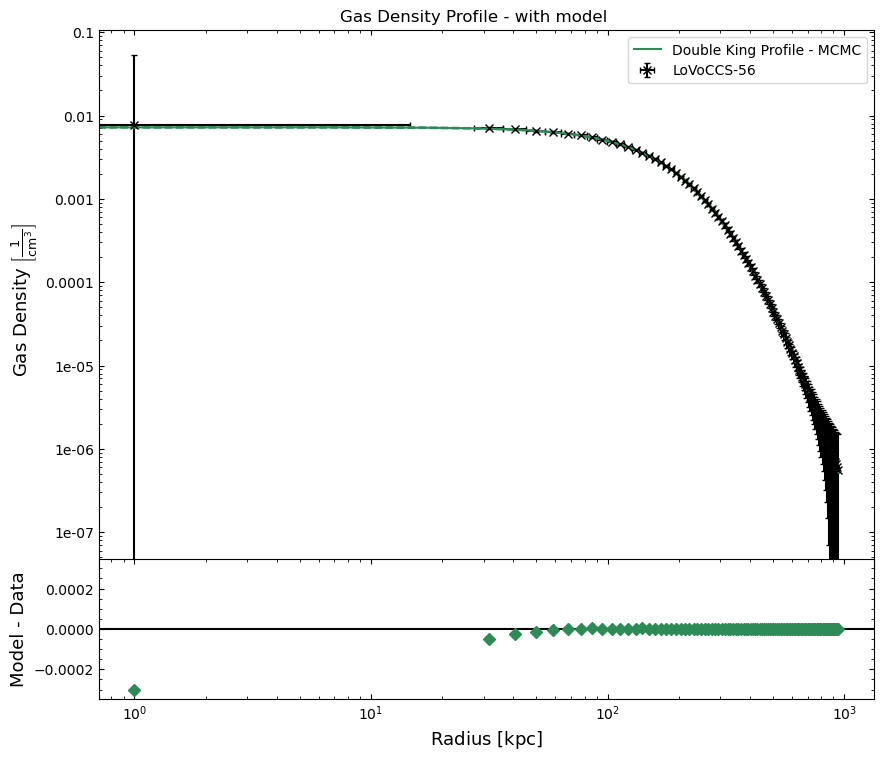

LoVoCCS-57


100%|██████████| 30000/30000 [00:35<00:00, 855.21it/s]


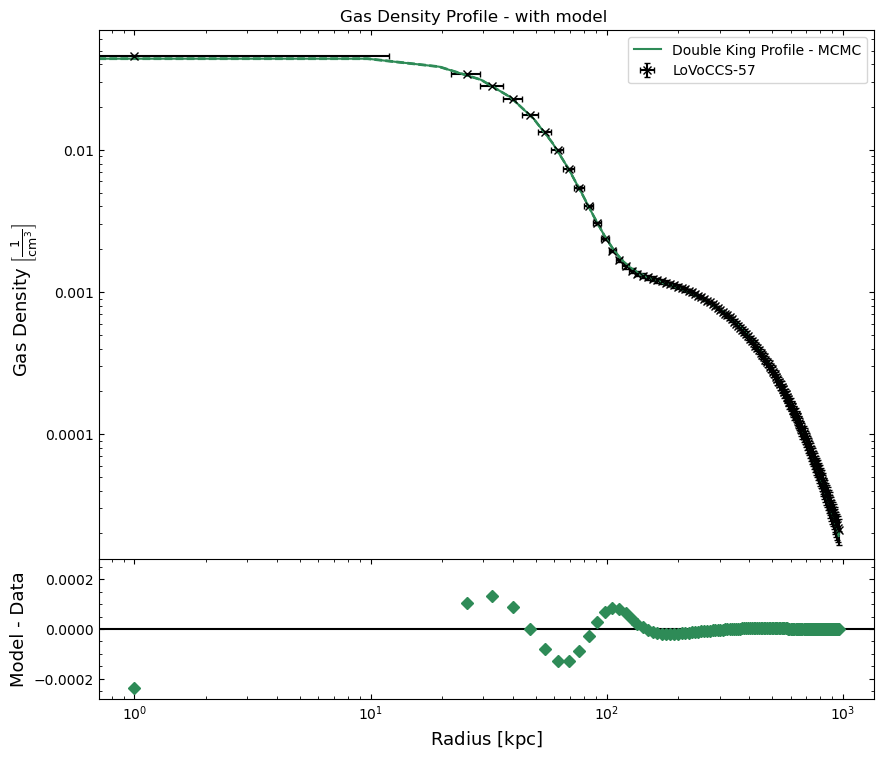

LoVoCCS-58


100%|██████████| 30000/30000 [00:36<00:00, 824.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1474.89990339 1479.01541106 1455.36564299  842.15061387  876.65100213
 1395.98553931]


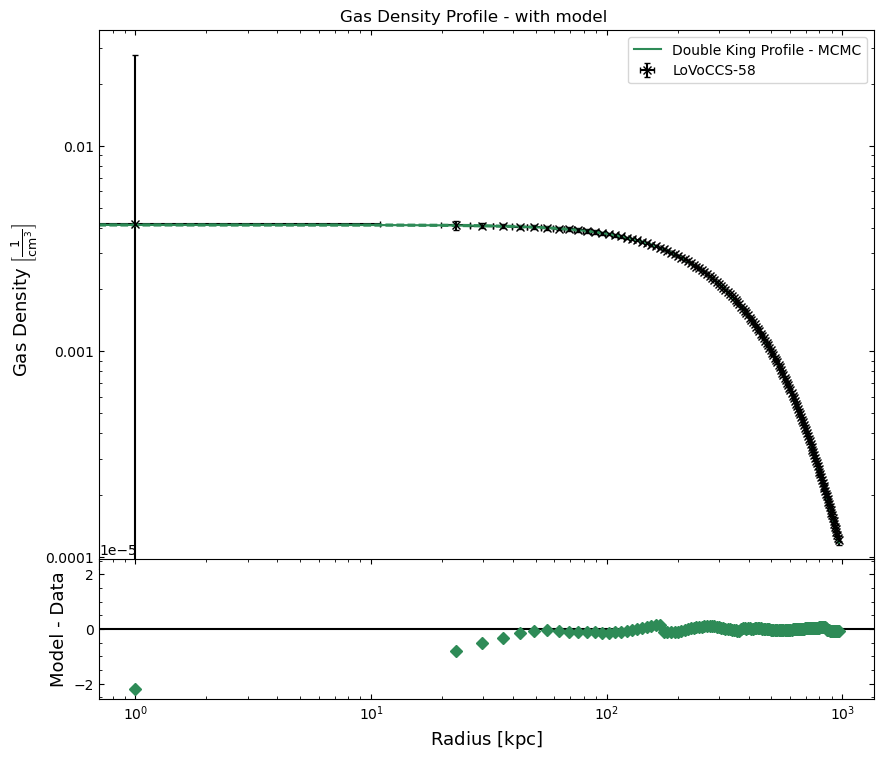

LoVoCCS-60


100%|██████████| 30000/30000 [00:32<00:00, 936.02it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 693.13764475  682.53041745  960.63679128 1021.2625742  1049.04145971
  978.5345598 ]


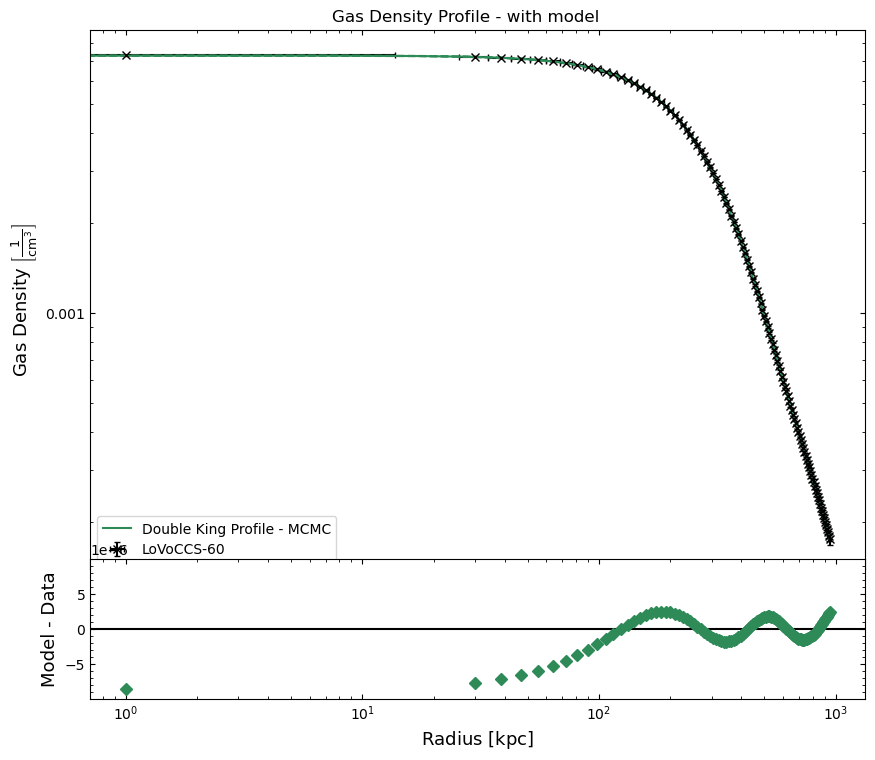

LoVoCCS-62


100%|██████████| 30000/30000 [00:29<00:00, 1015.90it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3499.30200689 3687.38990276 2713.42707112 3747.84144239 3783.2878619
 2675.98517213]


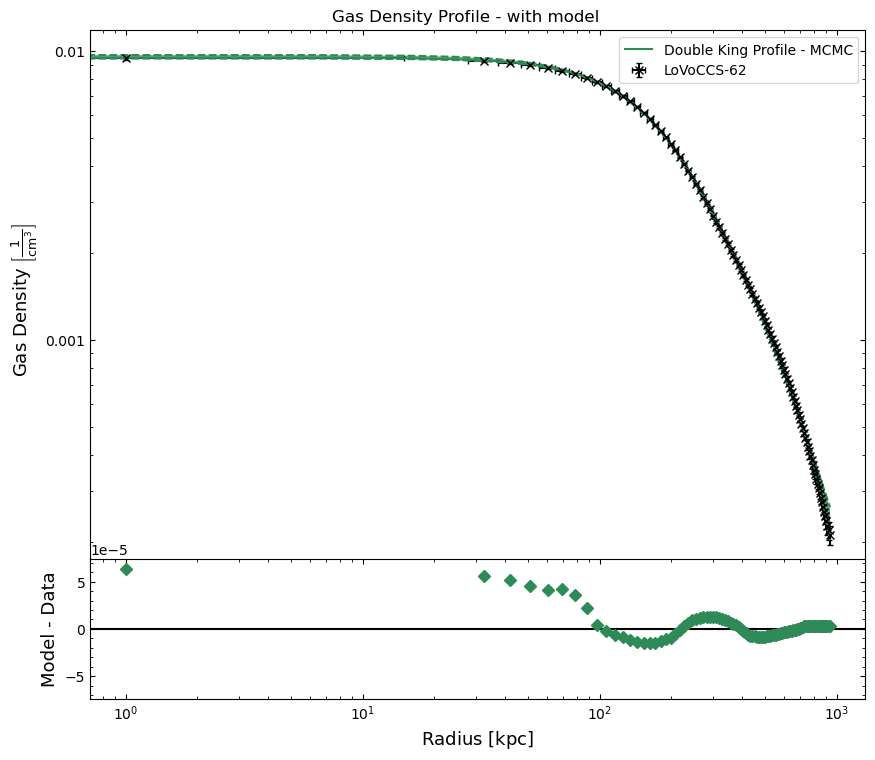

LoVoCCS-63


100%|██████████| 30000/30000 [00:38<00:00, 779.67it/s]


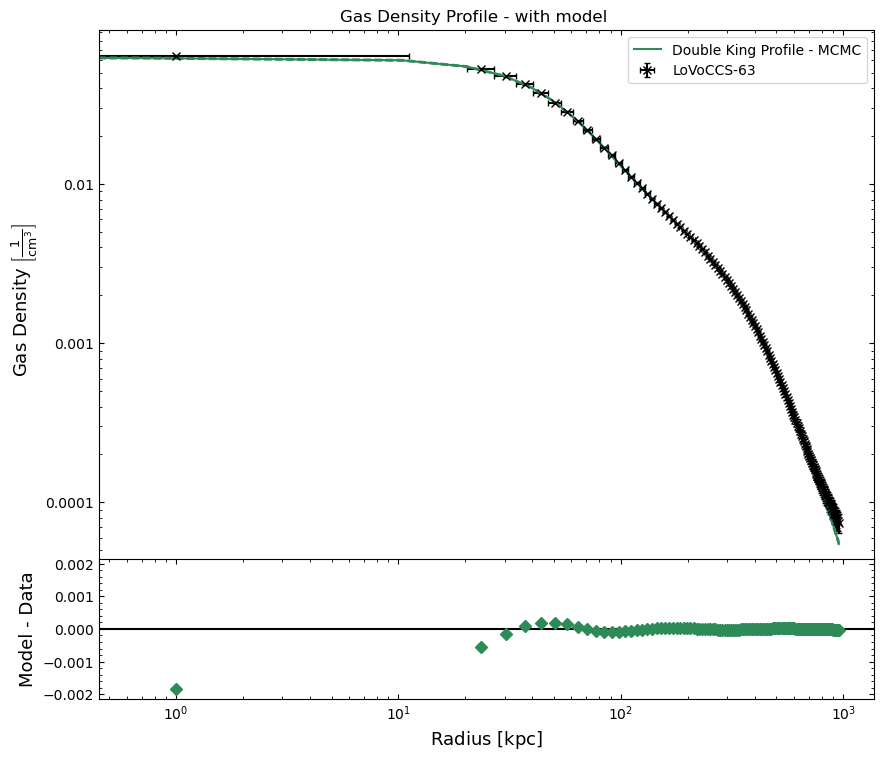

LoVoCCS-65


100%|██████████| 30000/30000 [00:31<00:00, 947.95it/s]


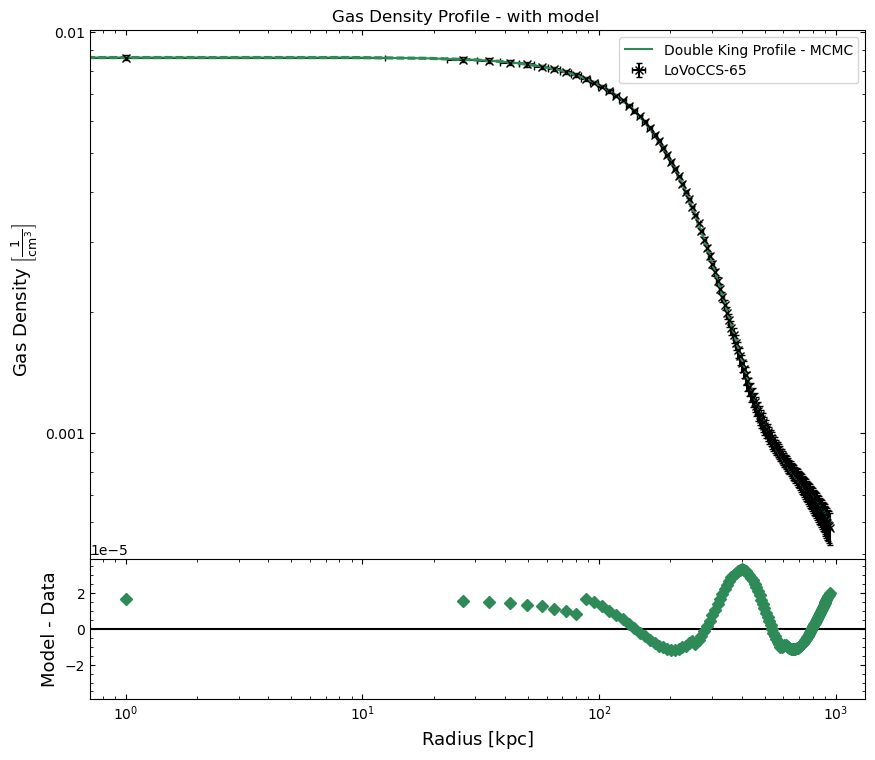

LoVoCCS-67


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
100%|██████████| 30000/30000 [00:34<00:00, 876.18it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1453.40549611 1503.07111402 1673.64781186 1811.67810557 1994.34010949
 1426.20756587]


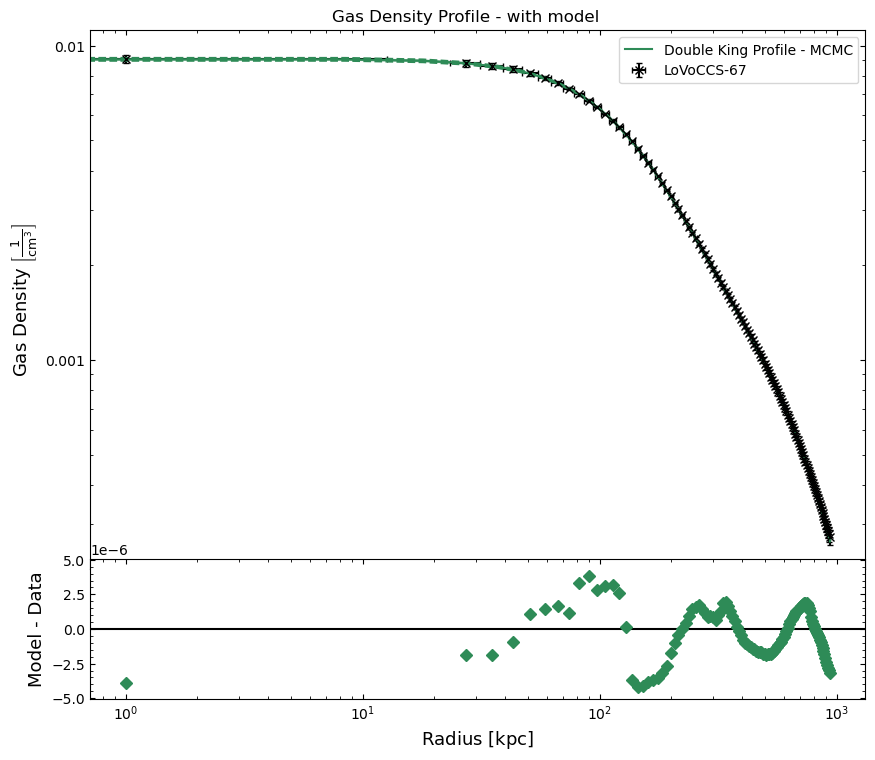

LoVoCCS-68


100%|██████████| 30000/30000 [00:33<00:00, 882.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [406.14144487 425.33422971 532.40172612 580.03706193 601.71747248
 556.12710237]


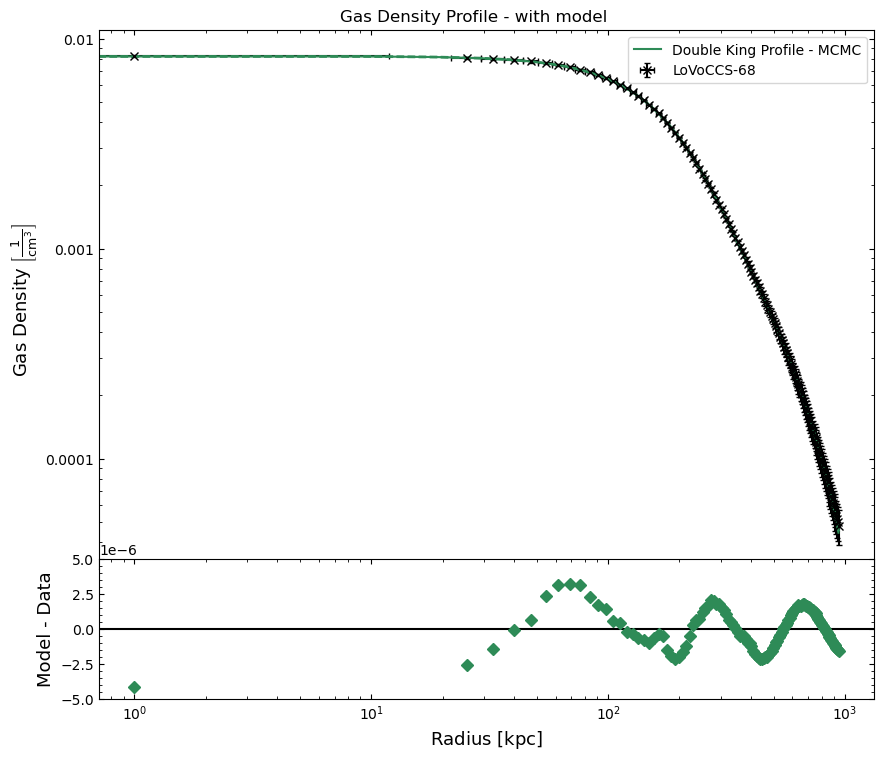

LoVoCCS-70


100%|██████████| 30000/30000 [00:31<00:00, 941.40it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2778.49429387 2610.14170806 2804.27166173 1647.90959491 1369.78440321
 2526.10477914]


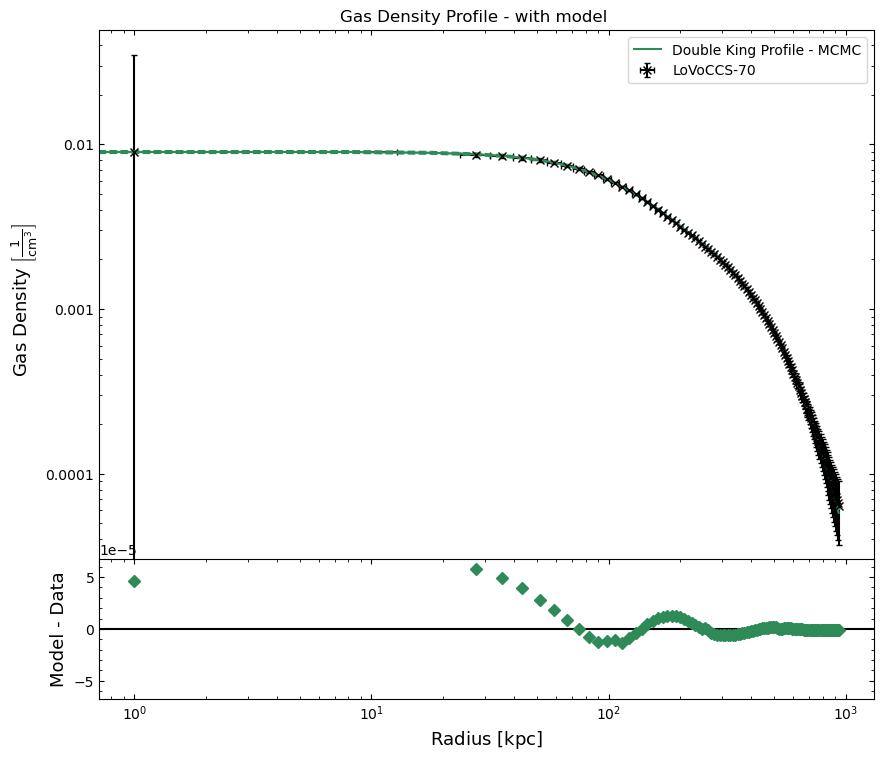

LoVoCCS-71


100%|██████████| 30000/30000 [00:30<00:00, 983.96it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1508.28358652 1513.2661024   814.07696377 1223.00933941 1190.06637824
  684.26217367]


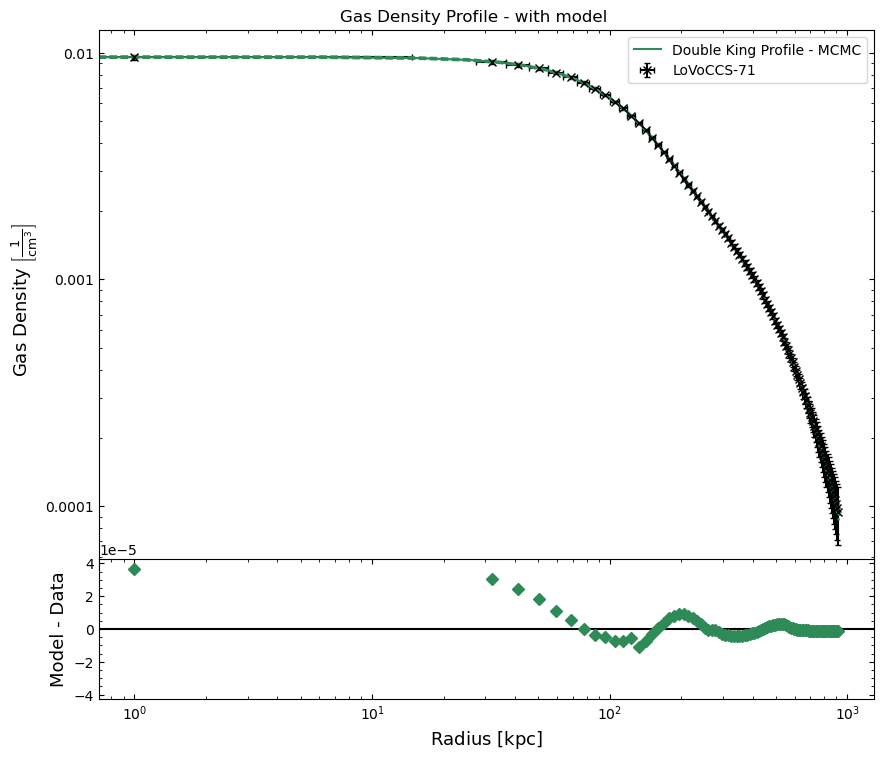

LoVoCCS-73


100%|██████████| 30000/30000 [00:32<00:00, 910.47it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [543.7976632  582.11881834 482.79394998 479.68190567 521.17709227
 701.86561683]


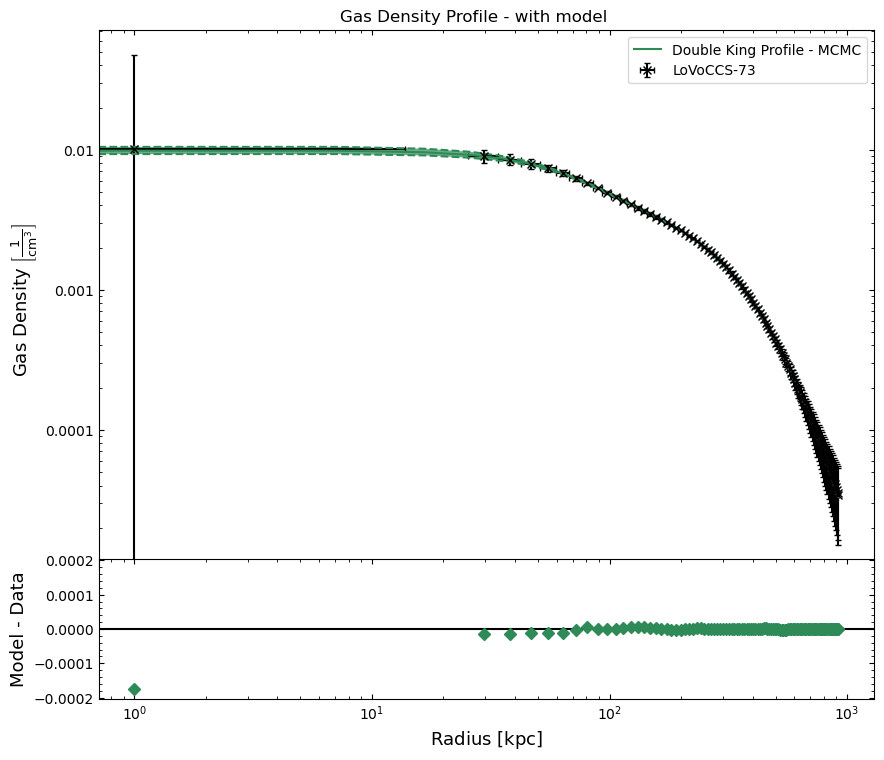

LoVoCCS-74


100%|██████████| 30000/30000 [00:27<00:00, 1101.30it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3076.3788323  1924.41709963 2586.94418287 3651.55361657 3797.93765997
 2632.58711004]


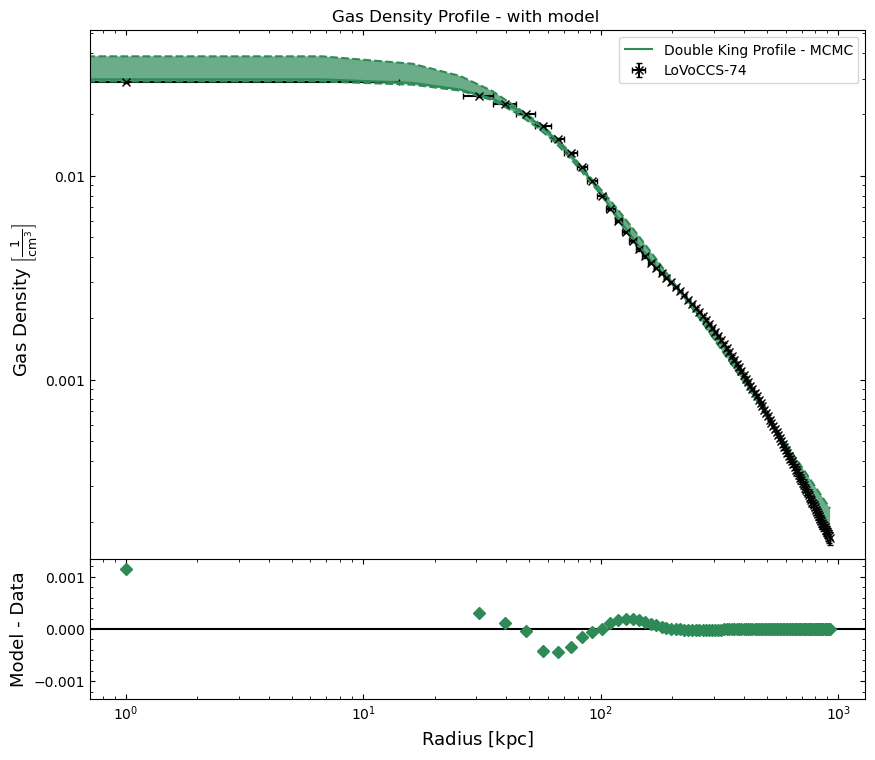

LoVoCCS-75


100%|██████████| 30000/30000 [00:34<00:00, 865.46it/s]


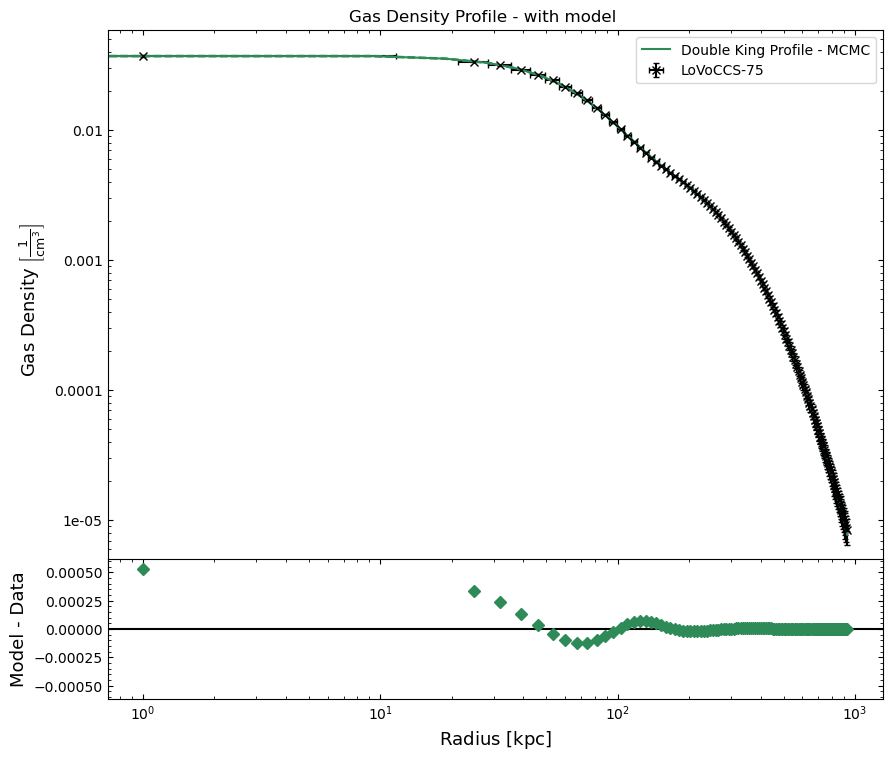

LoVoCCS-76


100%|██████████| 30000/30000 [00:33<00:00, 901.73it/s]


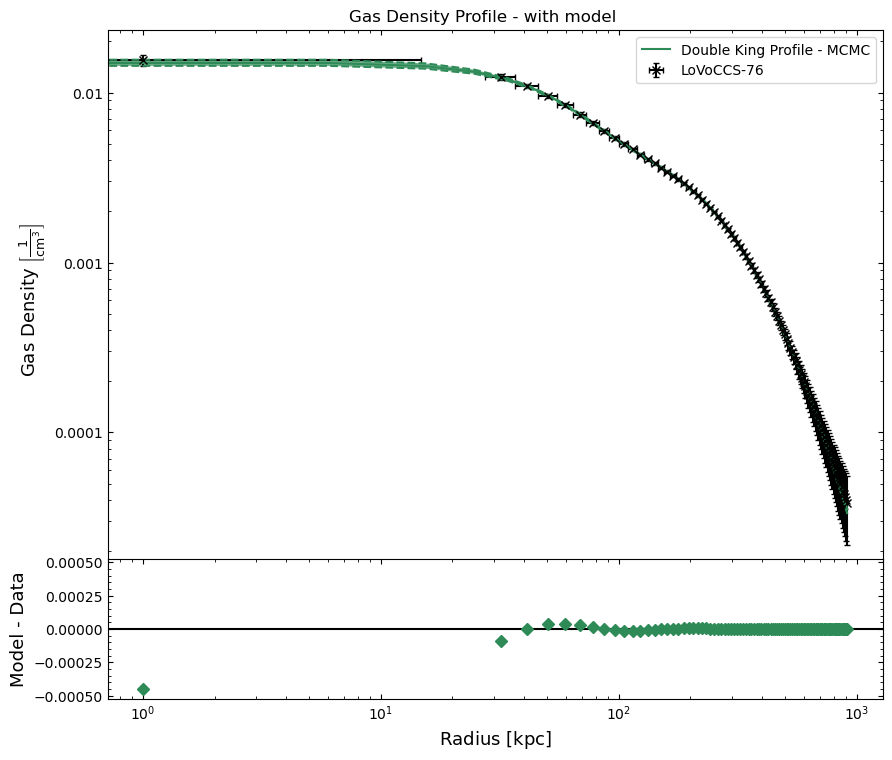

LoVoCCS-77


100%|██████████| 30000/30000 [00:36<00:00, 828.73it/s]


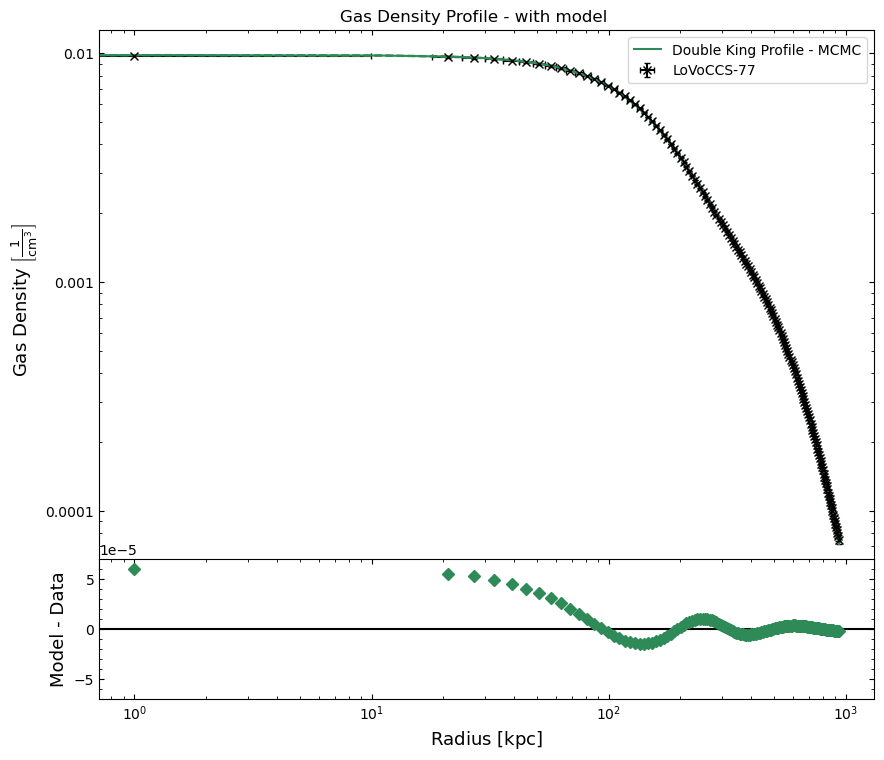

LoVoCCS-78


100%|██████████| 30000/30000 [00:41<00:00, 717.26it/s]


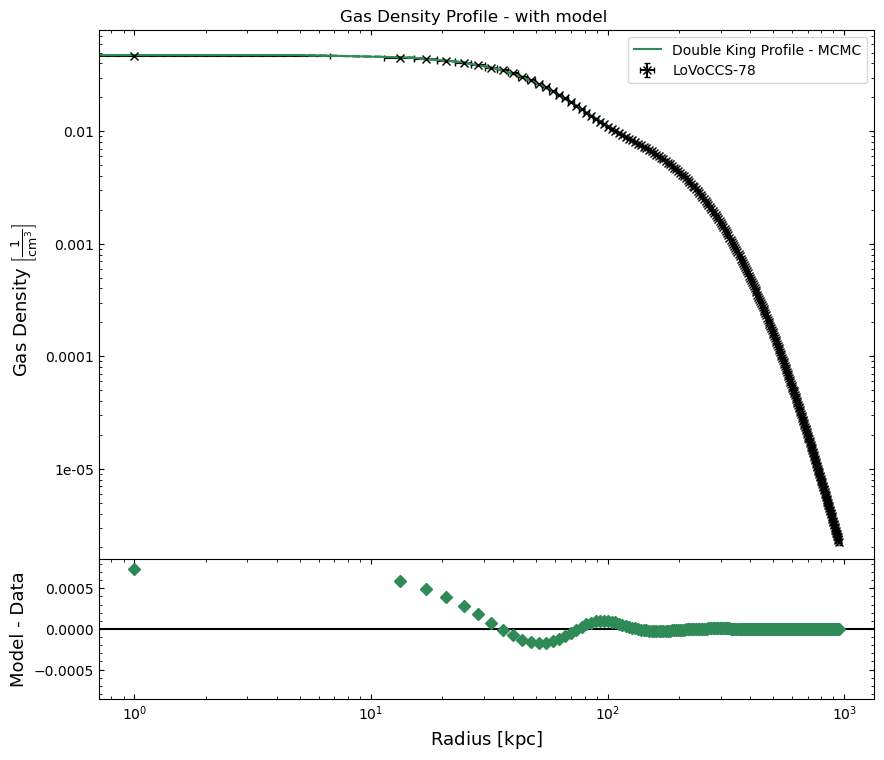

LoVoCCS-79


100%|██████████| 30000/30000 [00:35<00:00, 845.69it/s]


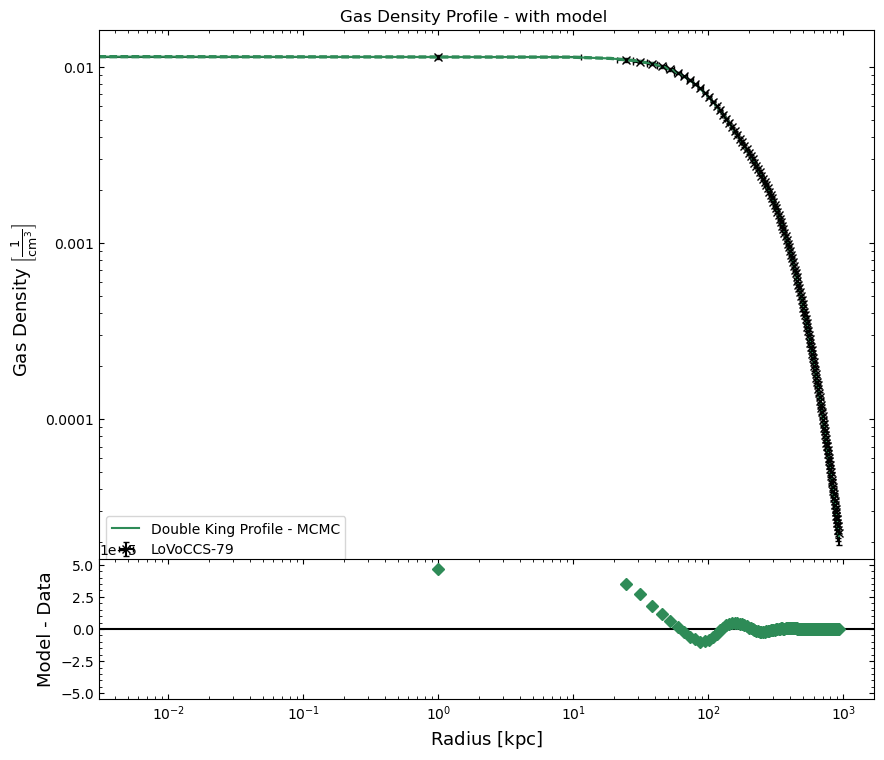

LoVoCCS-81


100%|██████████| 30000/30000 [00:38<00:00, 772.77it/s]


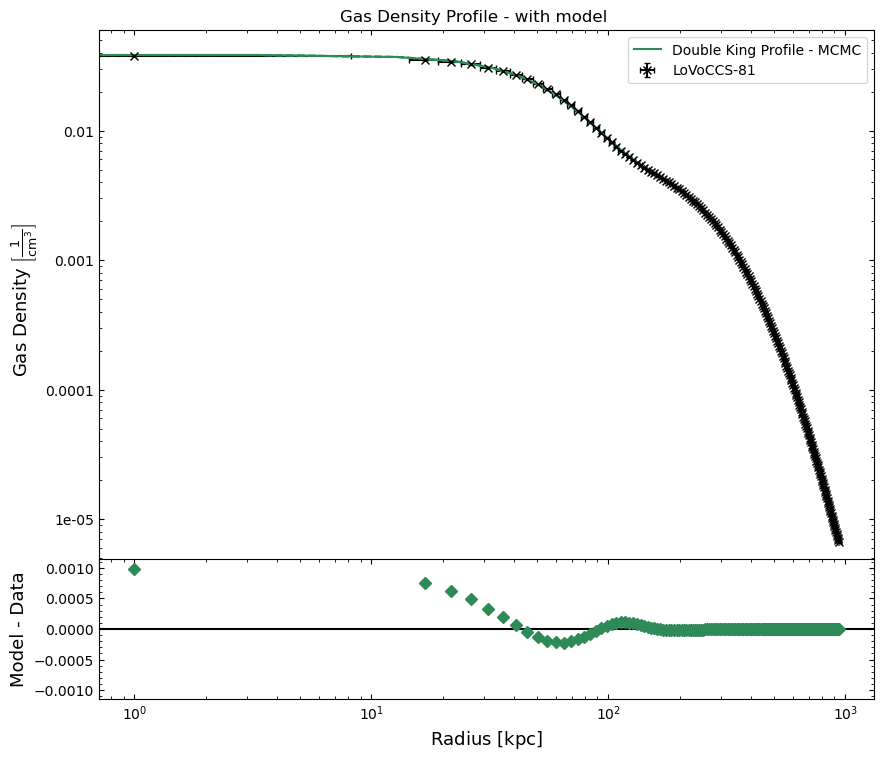

LoVoCCS-83


100%|██████████| 30000/30000 [00:35<00:00, 850.38it/s]


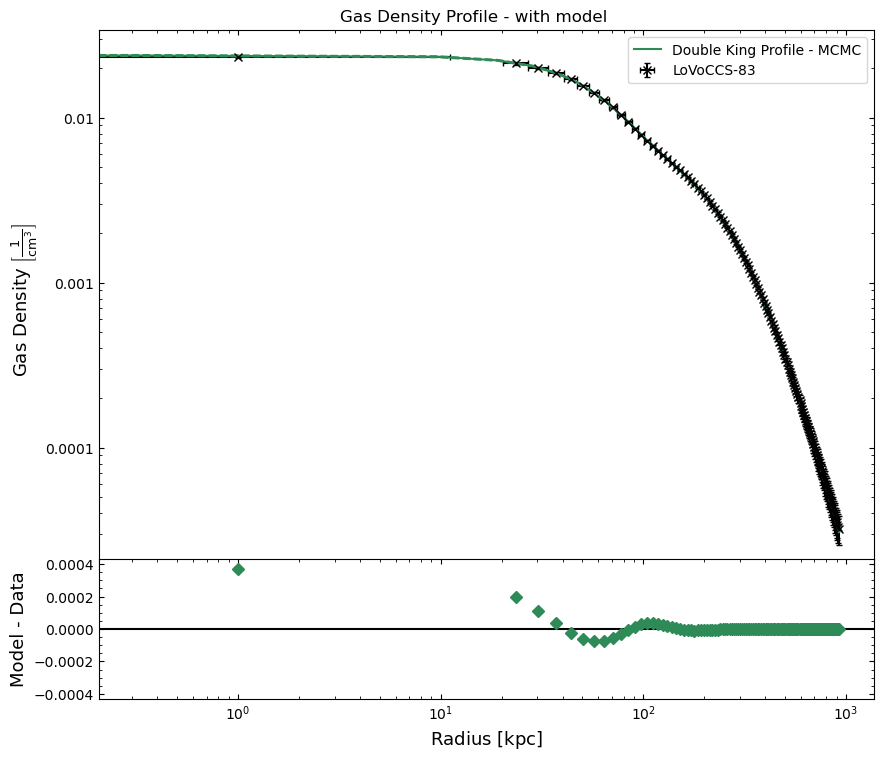

LoVoCCS-84


100%|██████████| 30000/30000 [00:33<00:00, 905.67it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [383.61736069 459.70288976 726.72149402 630.45010269 686.55843208
 576.5766895 ]


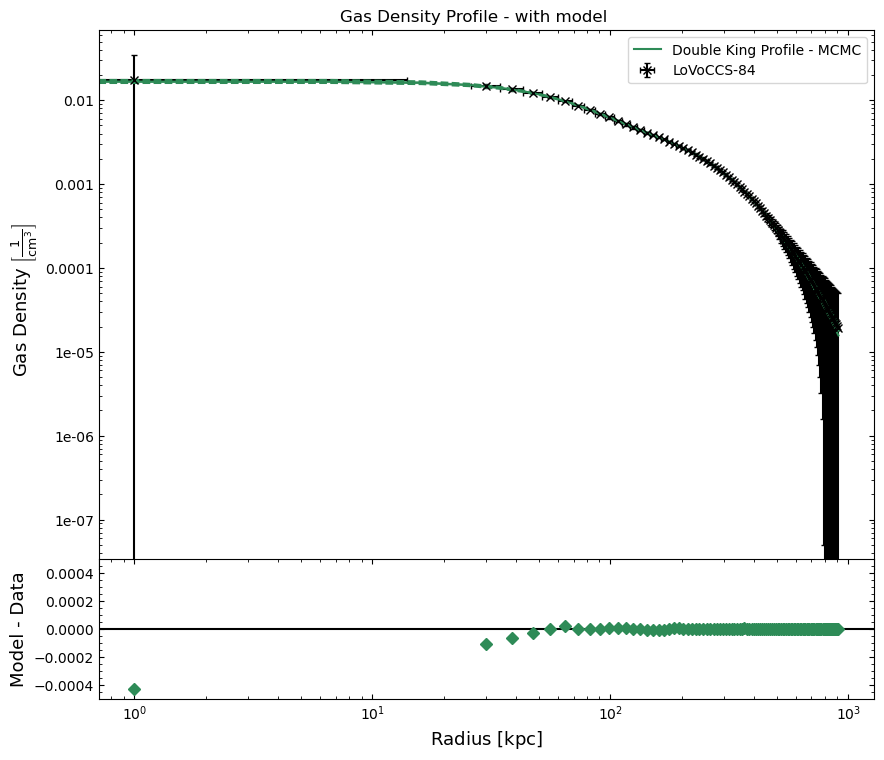

LoVoCCS-85


100%|██████████| 30000/30000 [00:44<00:00, 671.16it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1186.72401514 1188.92648072 1176.55867581  986.70319904 1108.19780047
 1233.74241799]


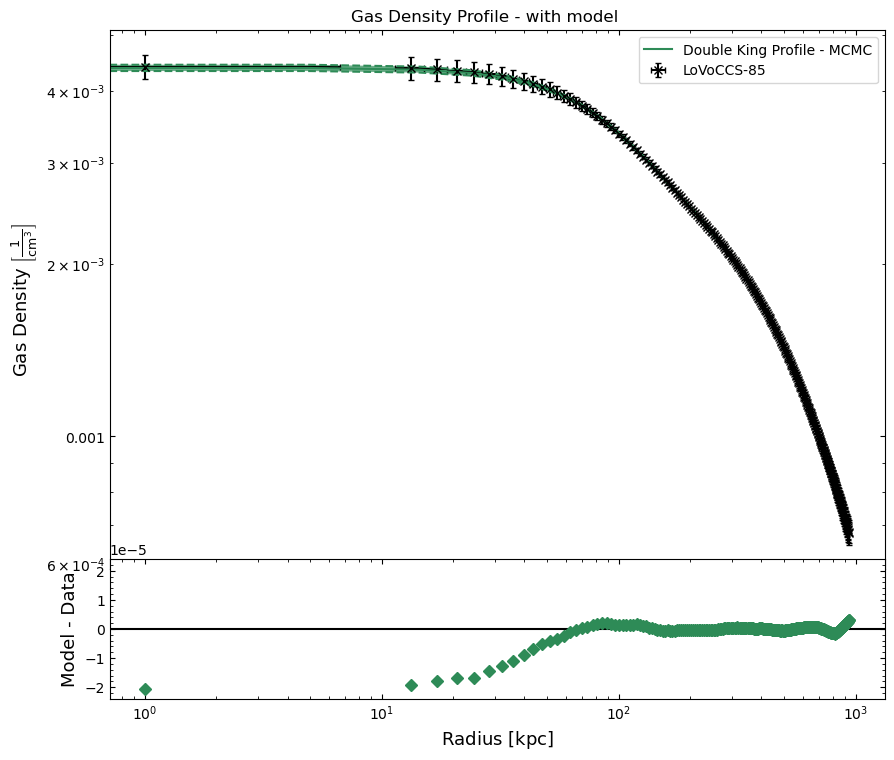

LoVoCCS-86


100%|██████████| 30000/30000 [00:31<00:00, 949.97it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1648.70127073 1655.36757742 1842.18518717 1220.60426954 1315.18830449
 1849.51077545]


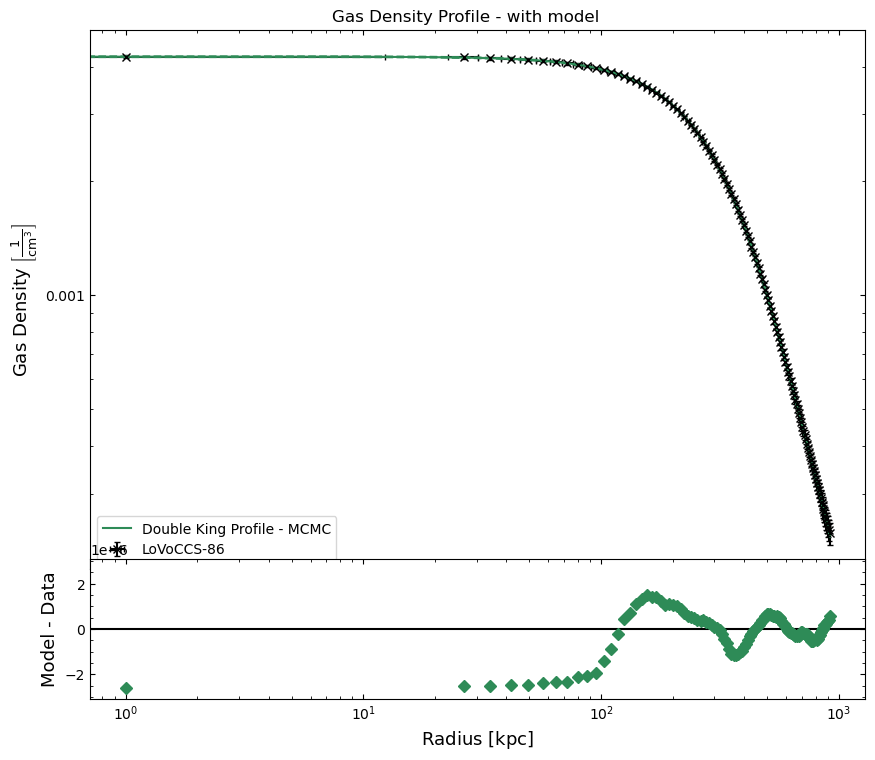

LoVoCCS-88


100%|██████████| 30000/30000 [00:30<00:00, 999.76it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2045.74292182 2038.56554026  761.49032368 1287.05231773 1334.59846665
  860.83854756]


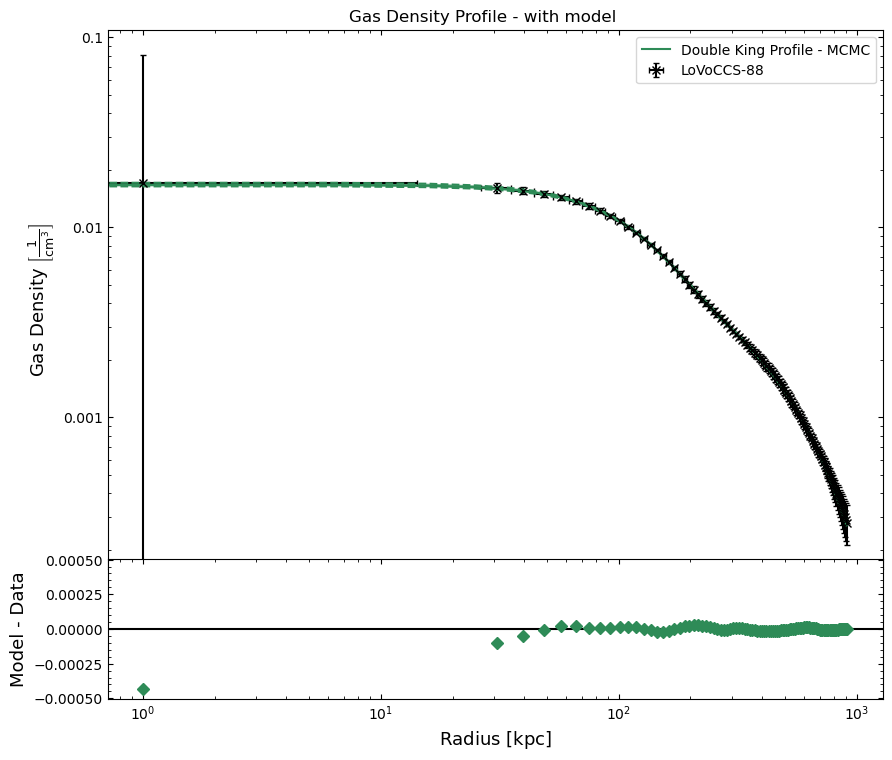

LoVoCCS-94


100%|██████████| 30000/30000 [00:33<00:00, 884.22it/s]


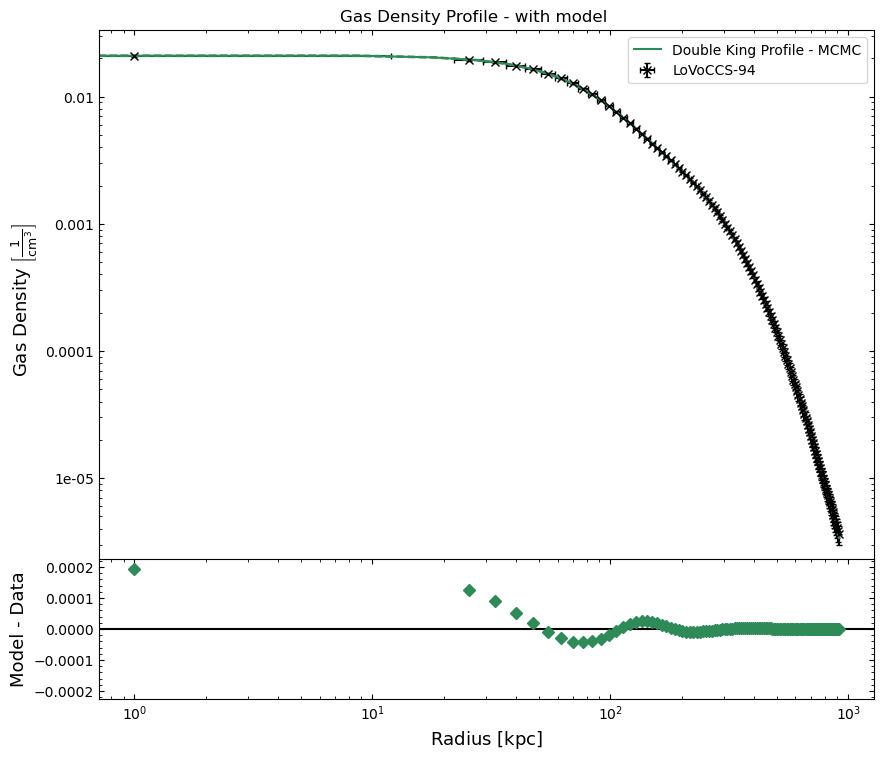

LoVoCCS-96


100%|██████████| 30000/30000 [00:30<00:00, 969.31it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3051.25670433 2815.23152806 1426.13391821 3298.23681475 2988.27576181
 1189.41570093]


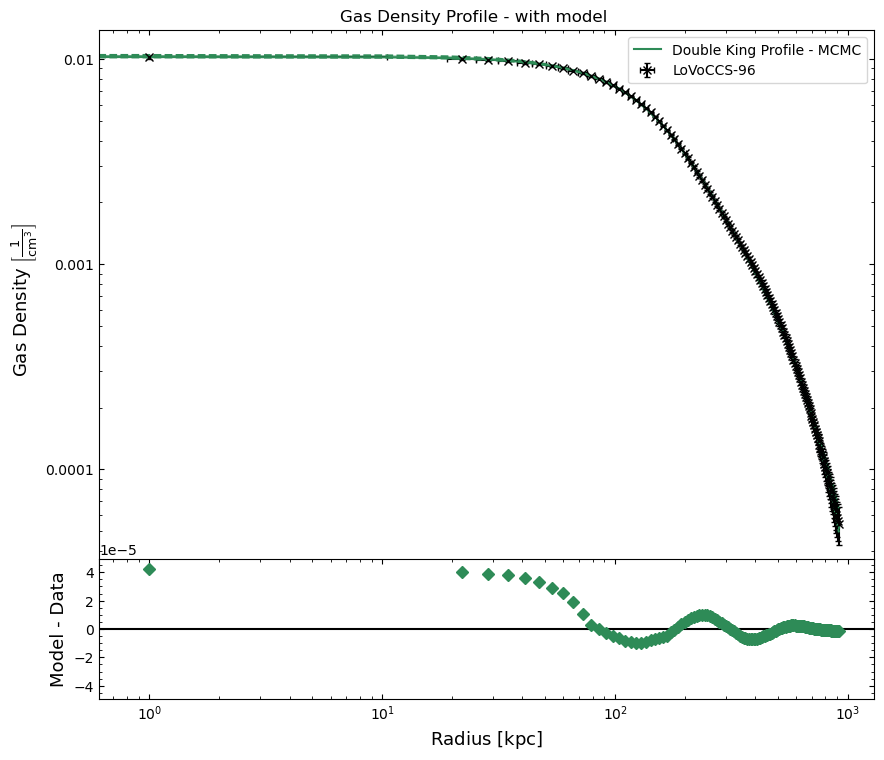

LoVoCCS-97


100%|██████████| 30000/30000 [00:39<00:00, 763.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [609.57583601 641.41686463 789.70438907 800.73742483 819.02458839
 836.49914441]


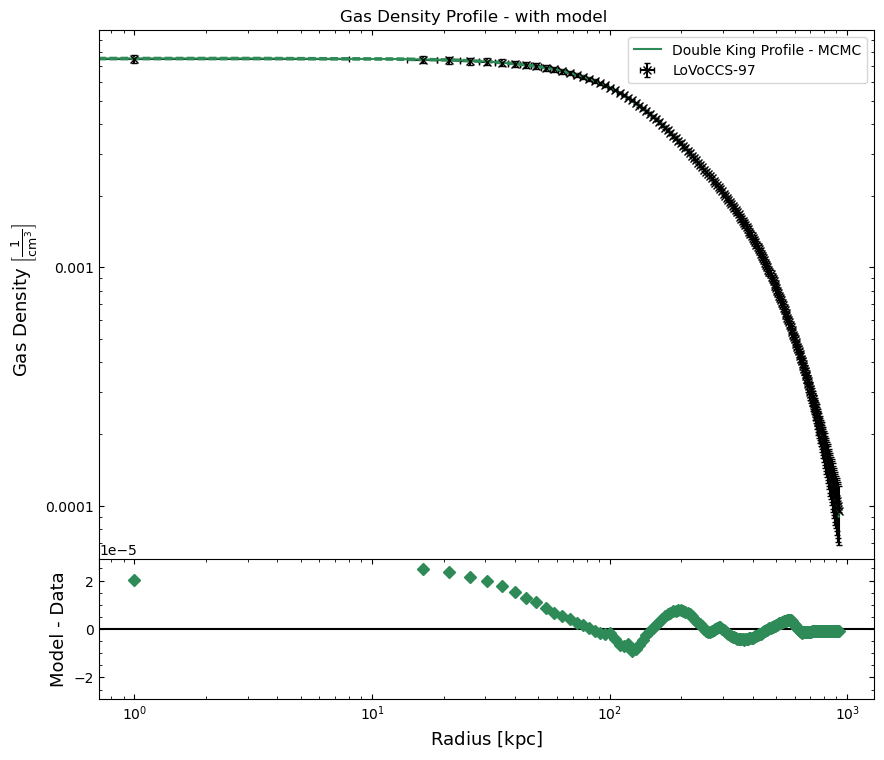

LoVoCCS-100


100%|██████████| 30000/30000 [00:36<00:00, 831.22it/s]


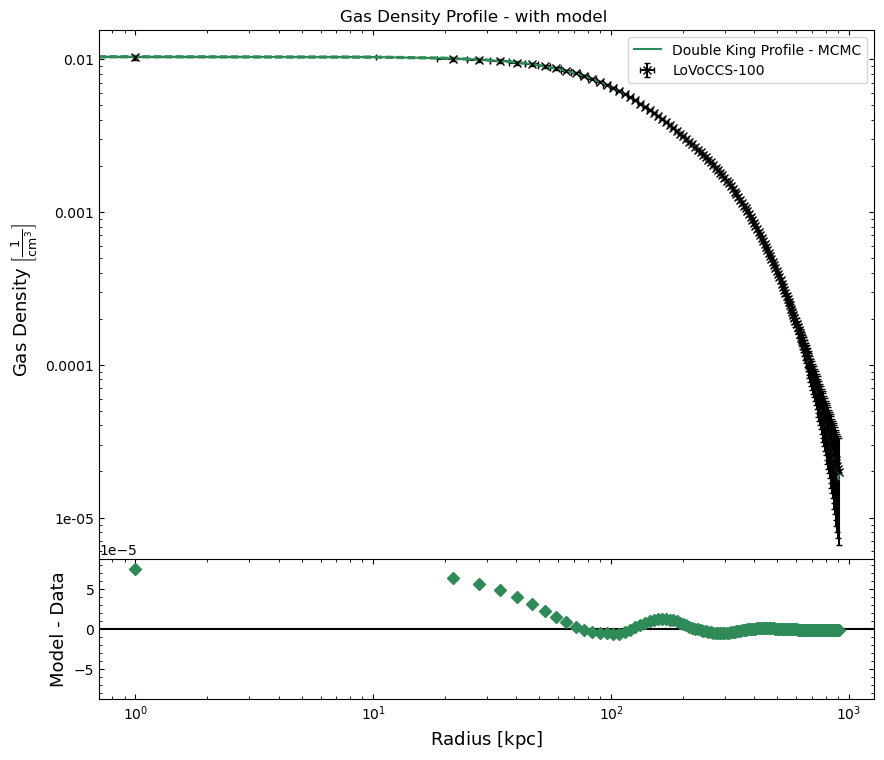

LoVoCCS-103


100%|██████████| 30000/30000 [00:33<00:00, 883.88it/s]


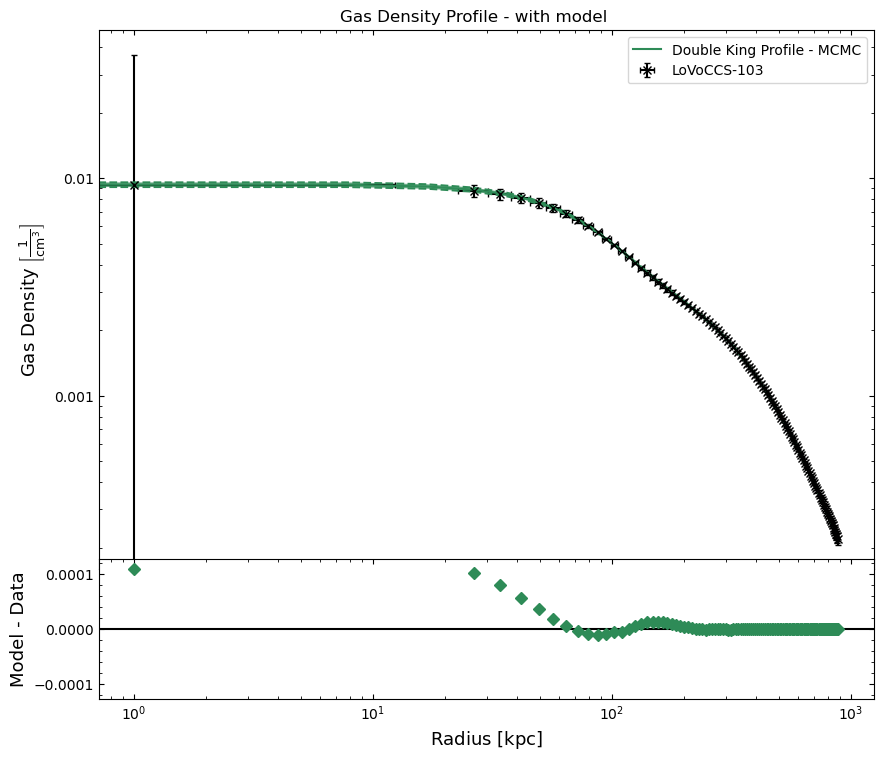

LoVoCCS-104


100%|██████████| 30000/30000 [00:27<00:00, 1096.41it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 335.8525829  1170.29145038  887.08860916  472.82516538  466.22059966
  438.09785754]


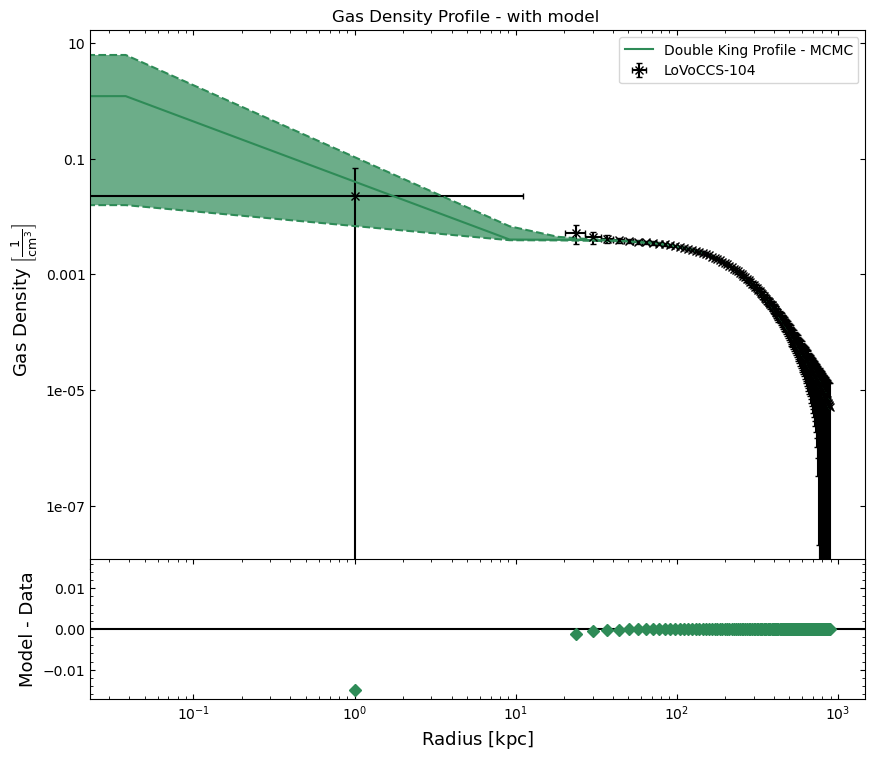

LoVoCCS-107


100%|██████████| 30000/30000 [00:35<00:00, 856.13it/s]


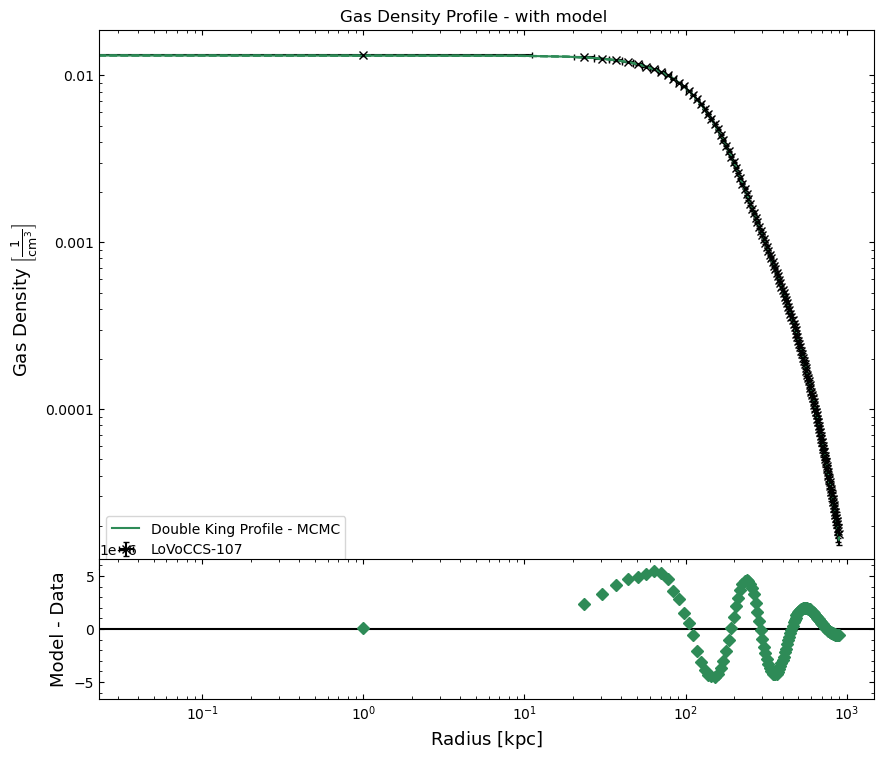

LoVoCCS-114


100%|██████████| 30000/30000 [00:48<00:00, 619.57it/s]


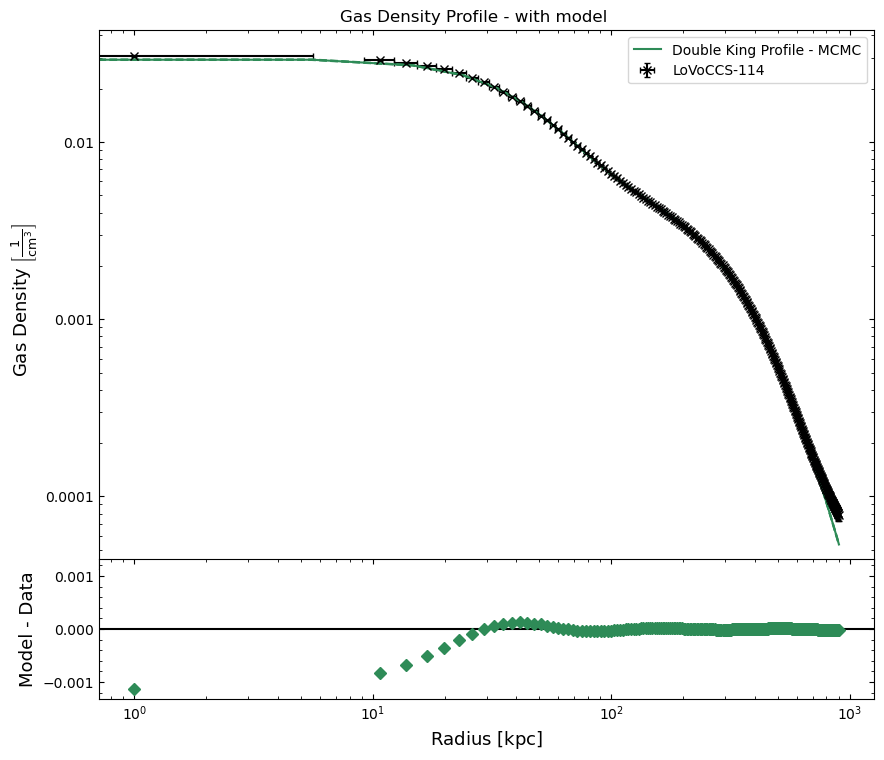

LoVoCCS-115


100%|██████████| 30000/30000 [00:33<00:00, 909.09it/s]


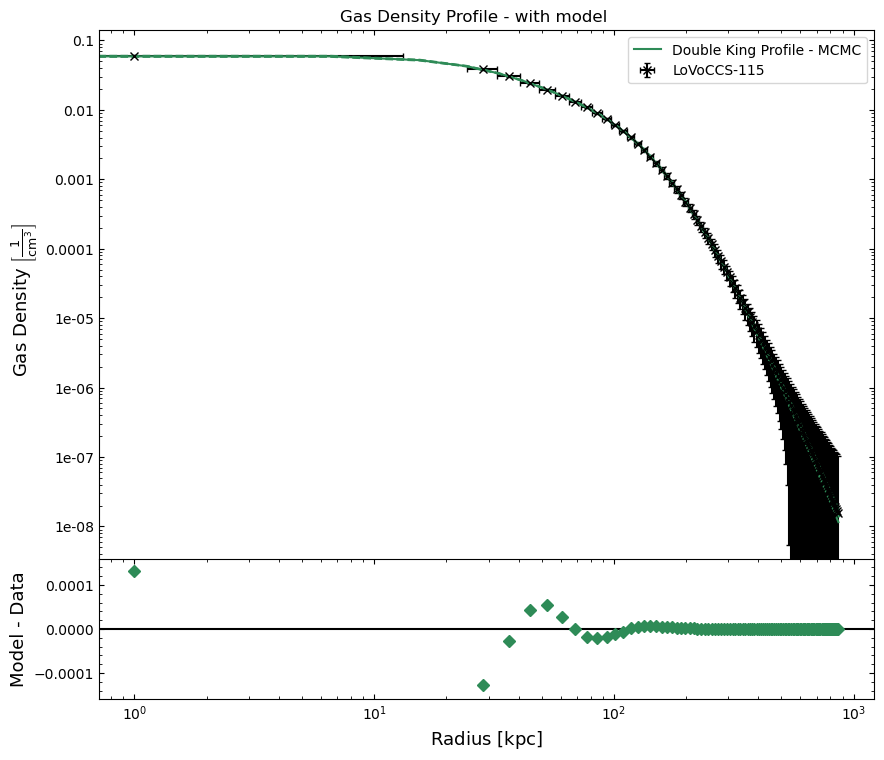

LoVoCCS-116


100%|██████████| 30000/30000 [00:32<00:00, 933.62it/s]


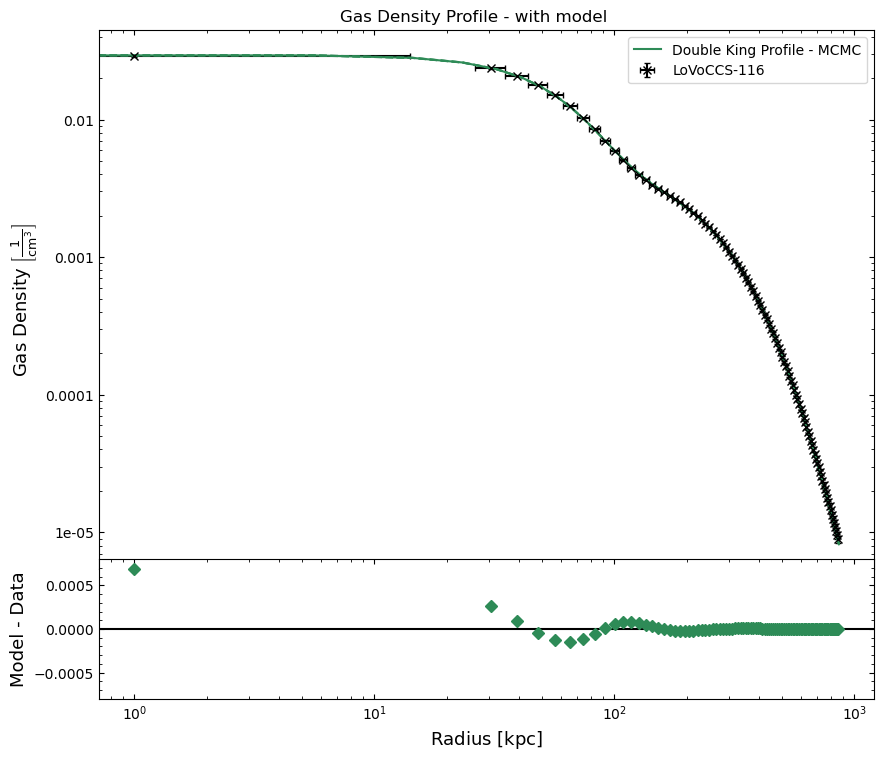

LoVoCCS-117


100%|██████████| 30000/30000 [00:38<00:00, 789.00it/s]


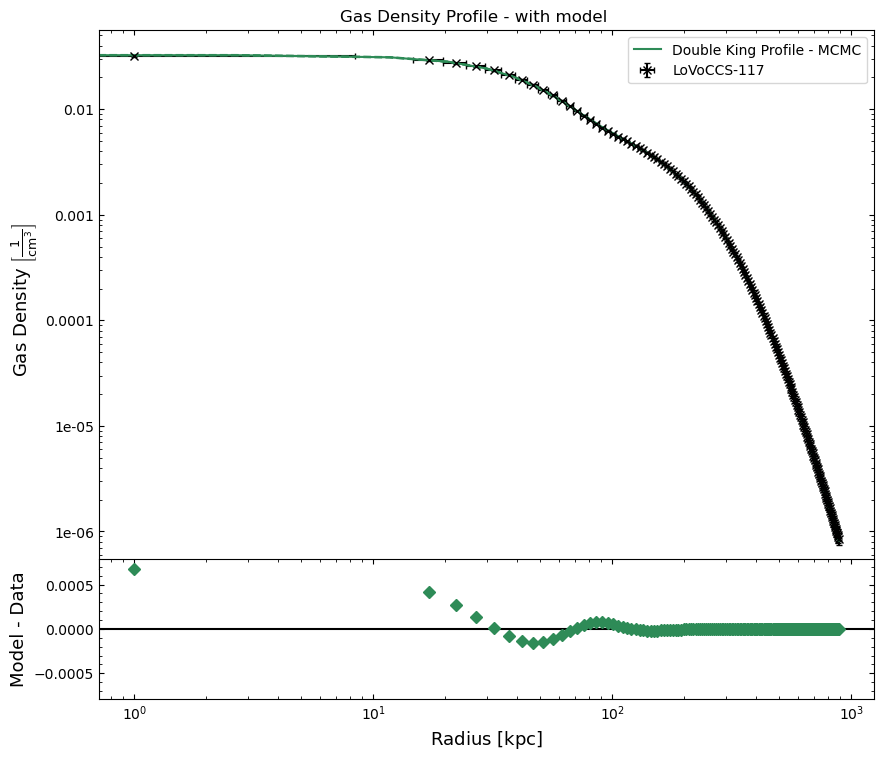

LoVoCCS-118


100%|██████████| 30000/30000 [00:34<00:00, 859.37it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [4004.11677539 3898.16725934 2829.72632372 3206.54172372 3191.77505825
 2800.4363039 ]


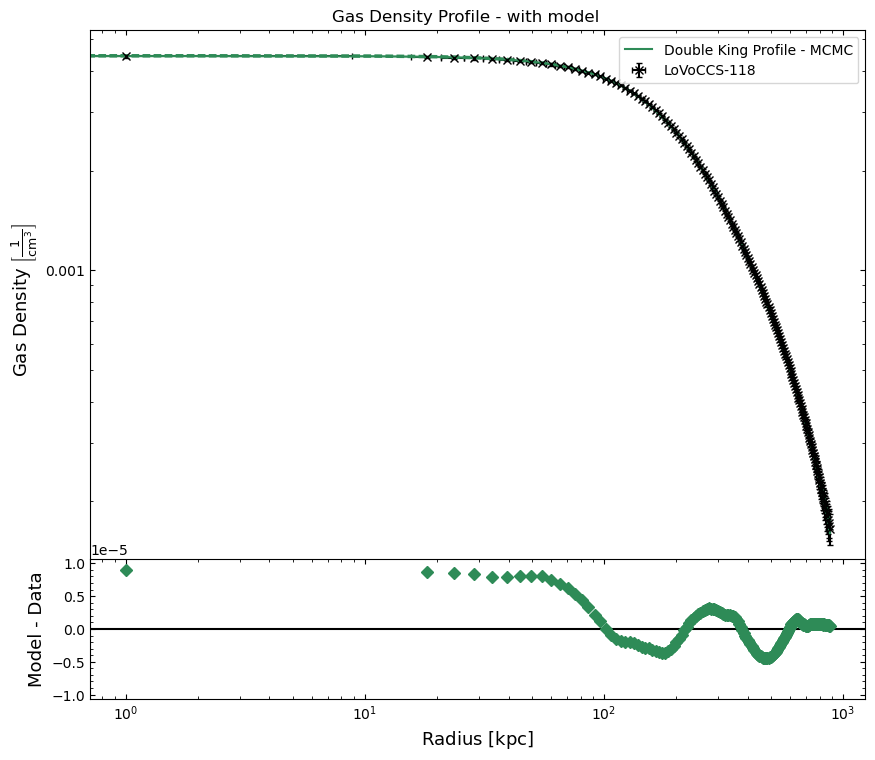

LoVoCCS-120


100%|██████████| 30000/30000 [00:37<00:00, 809.93it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3032.5101528  3030.17146268 1729.26285435 2020.66412069 1400.6726397
 2416.54196583]


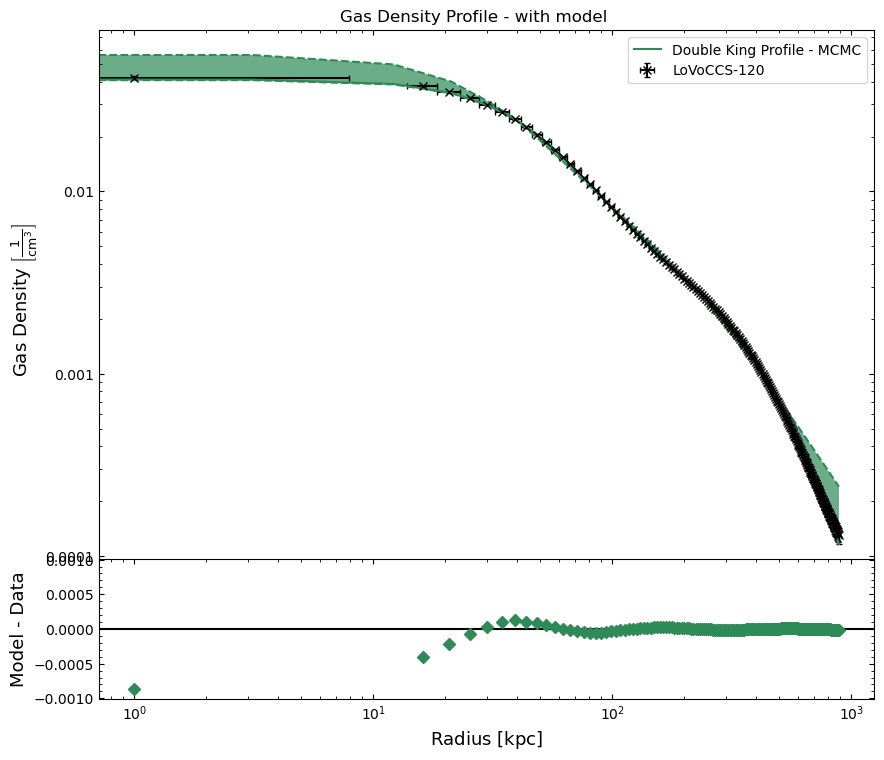

LoVoCCS-121


100%|██████████| 30000/30000 [00:35<00:00, 851.02it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [403.02496009 420.85528594 666.24024513 714.40373815 750.5521076
 689.65967684]


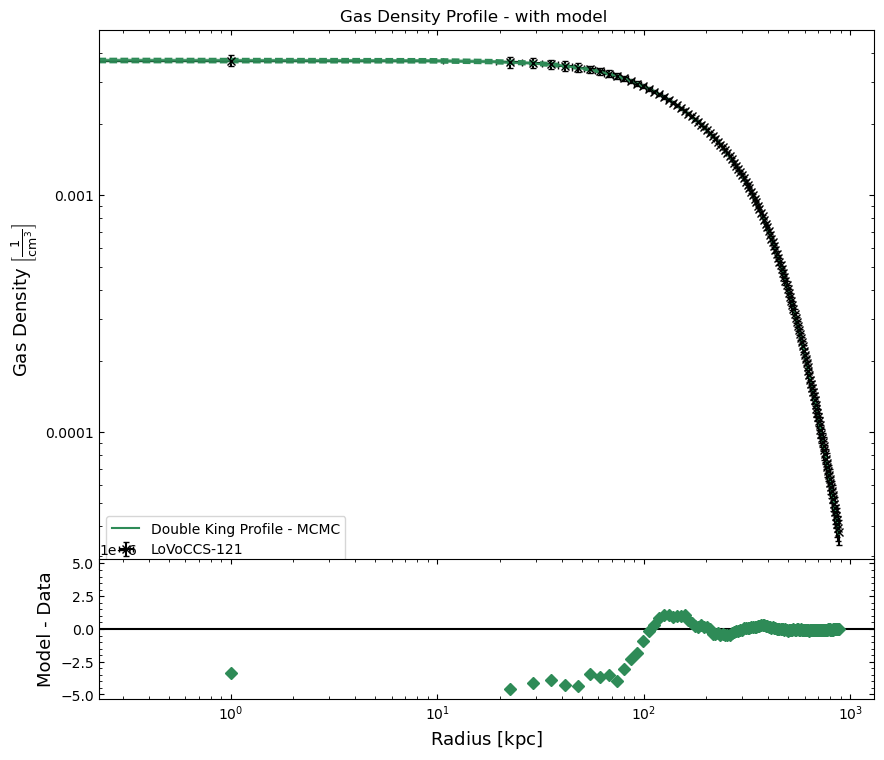

LoVoCCS-123


100%|██████████| 30000/30000 [00:40<00:00, 734.43it/s]


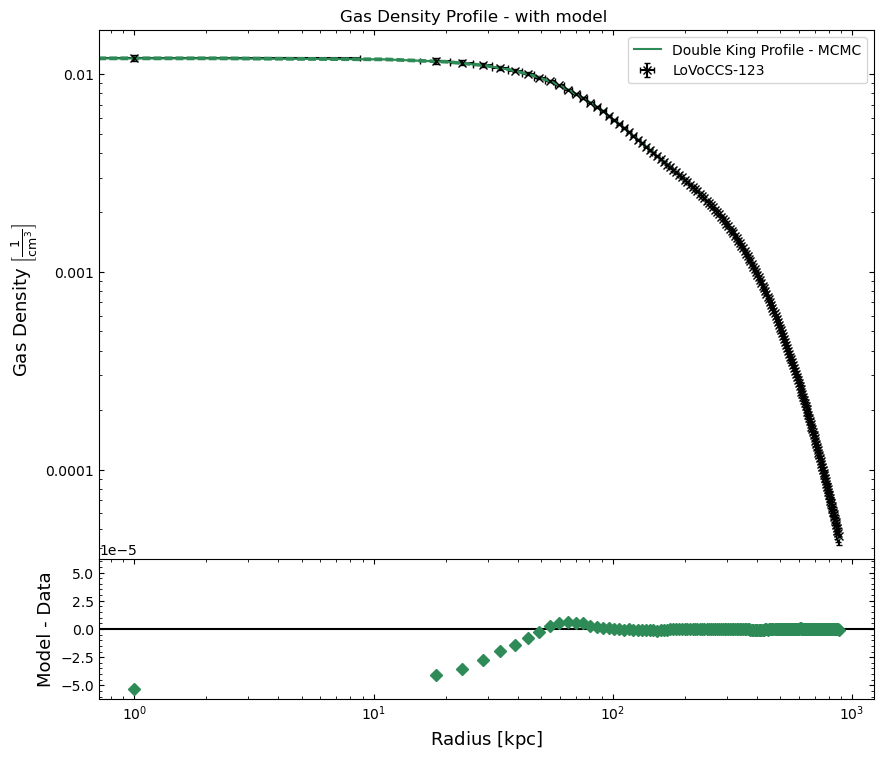

LoVoCCS-124


100%|██████████| 30000/30000 [00:34<00:00, 857.37it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2213.22659724  934.52312148 2582.18266356 2256.15198267 2270.34890199
 2567.66809934]


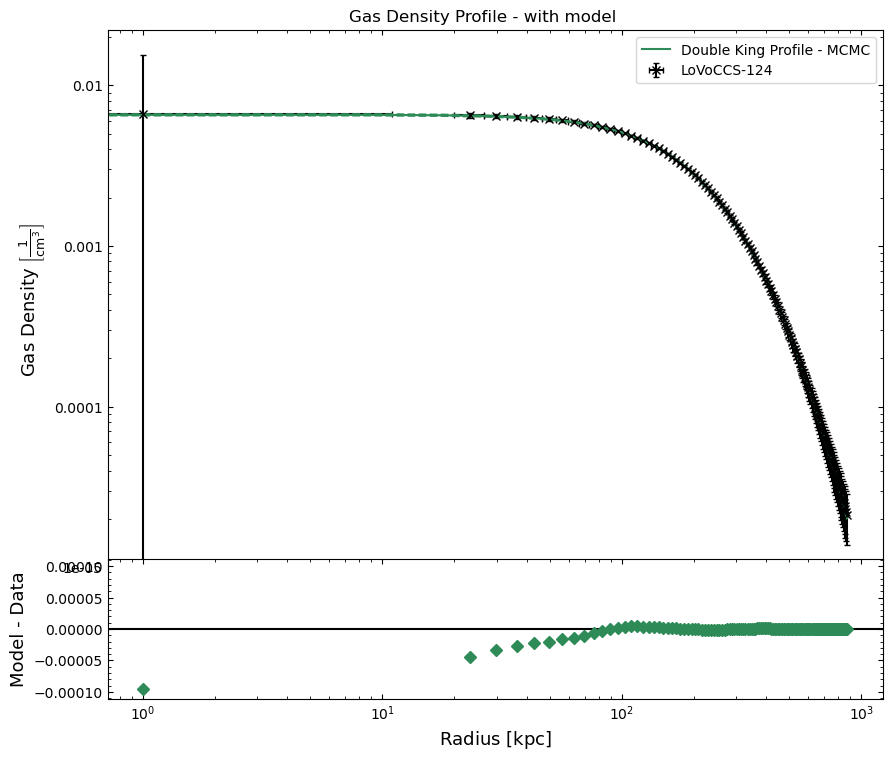

LoVoCCS-127


100%|██████████| 30000/30000 [00:34<00:00, 863.60it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 781.33407454  846.78711614 1063.51587569  965.82109455  887.82619744
 1015.73016079]


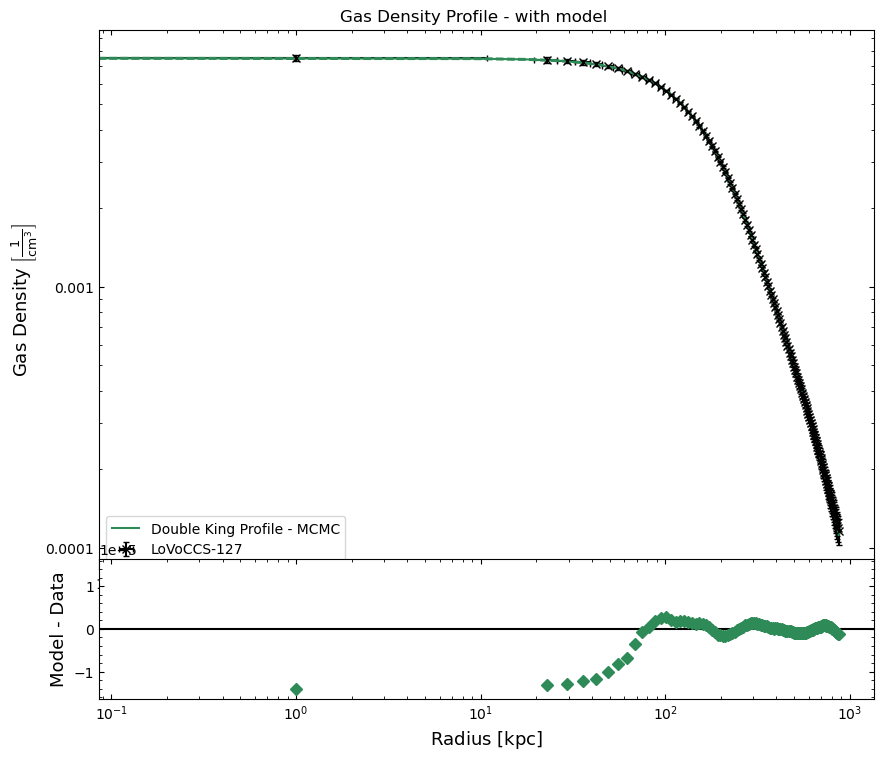

LoVoCCS-128


100%|██████████| 30000/30000 [00:33<00:00, 906.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1086.23531408 1194.39742742 1526.14344409 1330.31843303 1412.96851466
 1544.43488857]


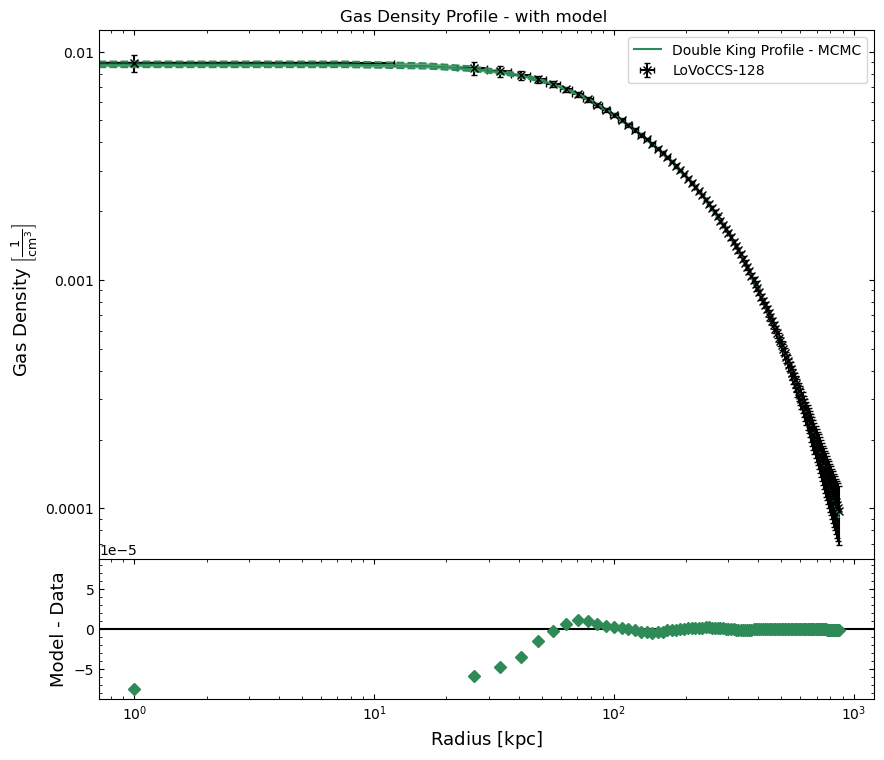

LoVoCCS-129


100%|██████████| 30000/30000 [00:29<00:00, 1019.37it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3323.18368042 3395.2574138  2675.26589756 3912.95072527 3899.59730087
 2684.66982423]


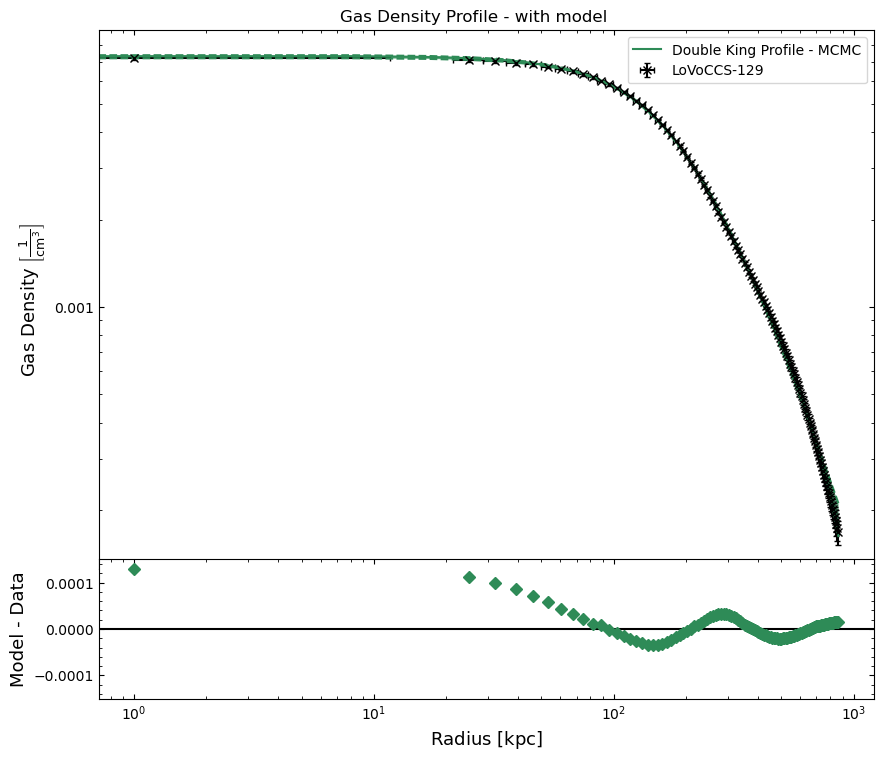

LoVoCCS-130


100%|██████████| 30000/30000 [00:31<00:00, 963.75it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2327.28697588 2268.50302424 2143.79411255 2020.63406164 1946.476425
 2128.6465577 ]


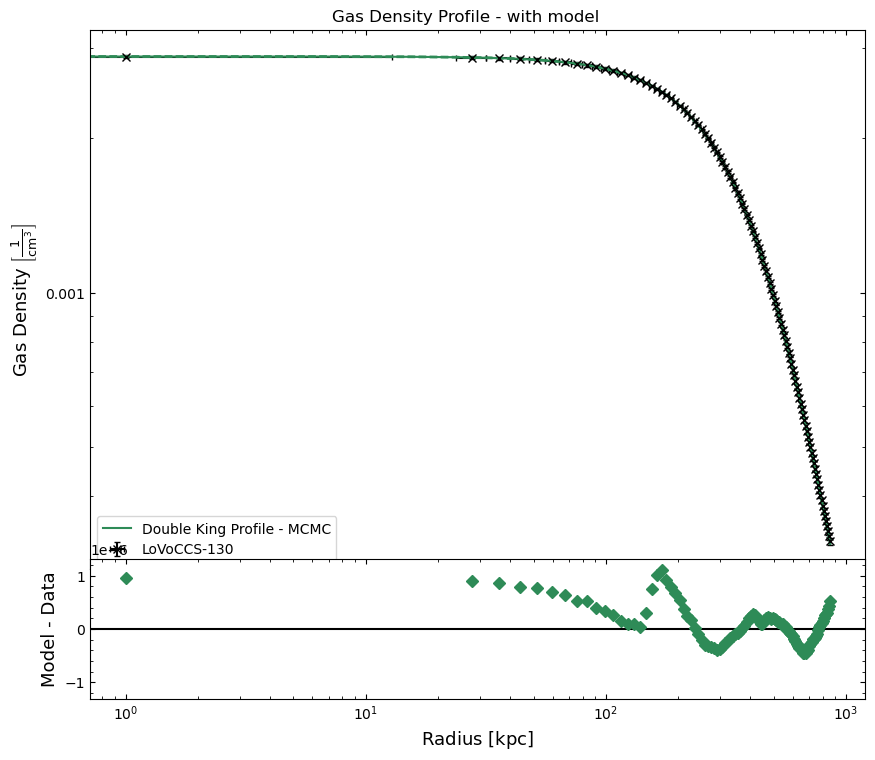

LoVoCCS-131


100%|██████████| 30000/30000 [00:34<00:00, 879.87it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1750.66693941 1696.59092404 2060.78247791 2047.76823999 1725.93915851
 2143.59006656]


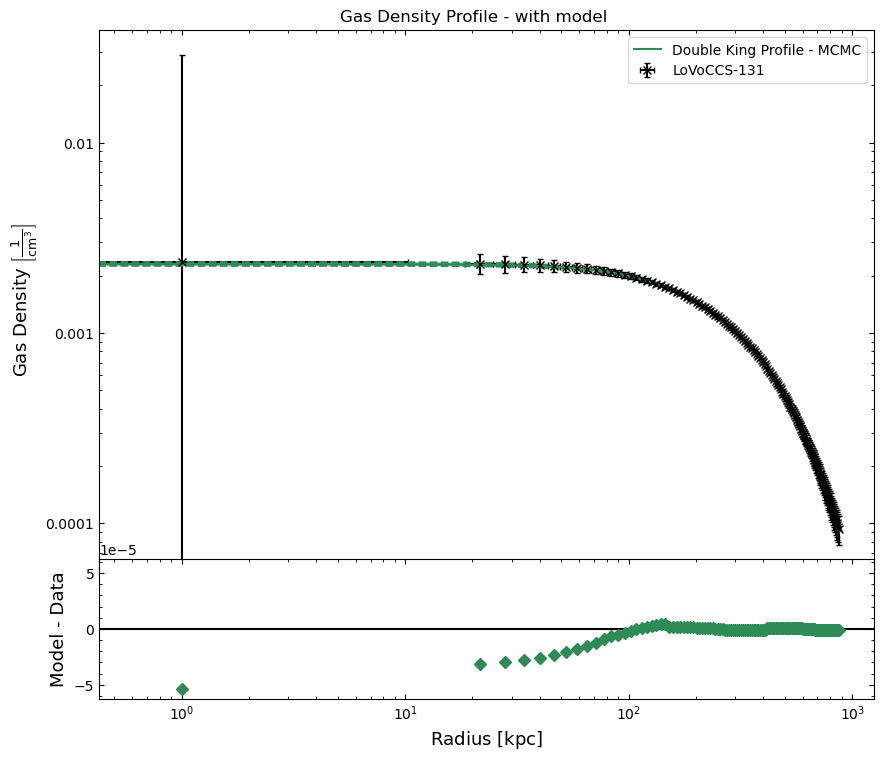

LoVoCCS-132


100%|██████████| 30000/30000 [00:28<00:00, 1055.12it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 291.94584364  303.93941941  330.67587113  323.05742458 1690.34050741
 1036.09627852]


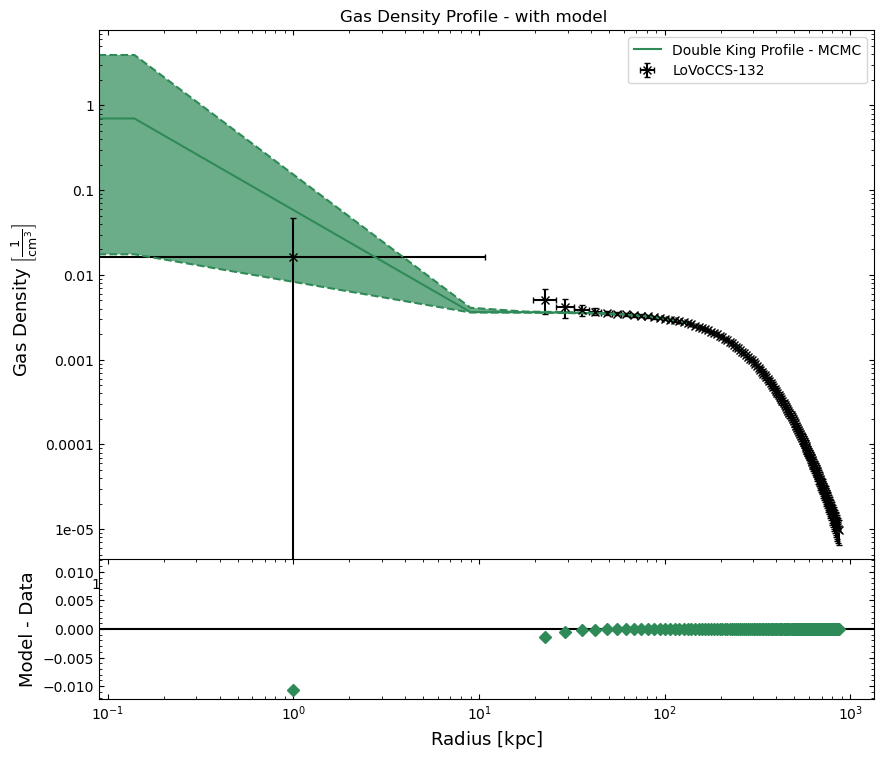

LoVoCCS-135


100%|██████████| 30000/30000 [00:36<00:00, 831.70it/s]


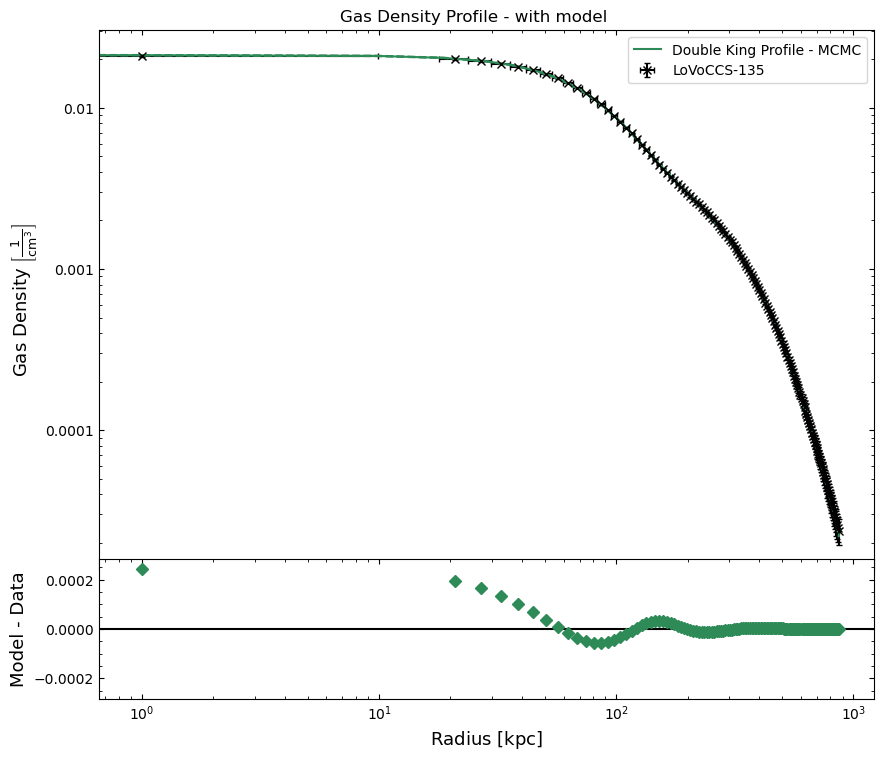

LoVoCCS-136


100%|██████████| 30000/30000 [00:28<00:00, 1037.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2121.19366074 1896.13101508 2294.07750749 1467.52390993 1602.63648064
 2542.18031937]


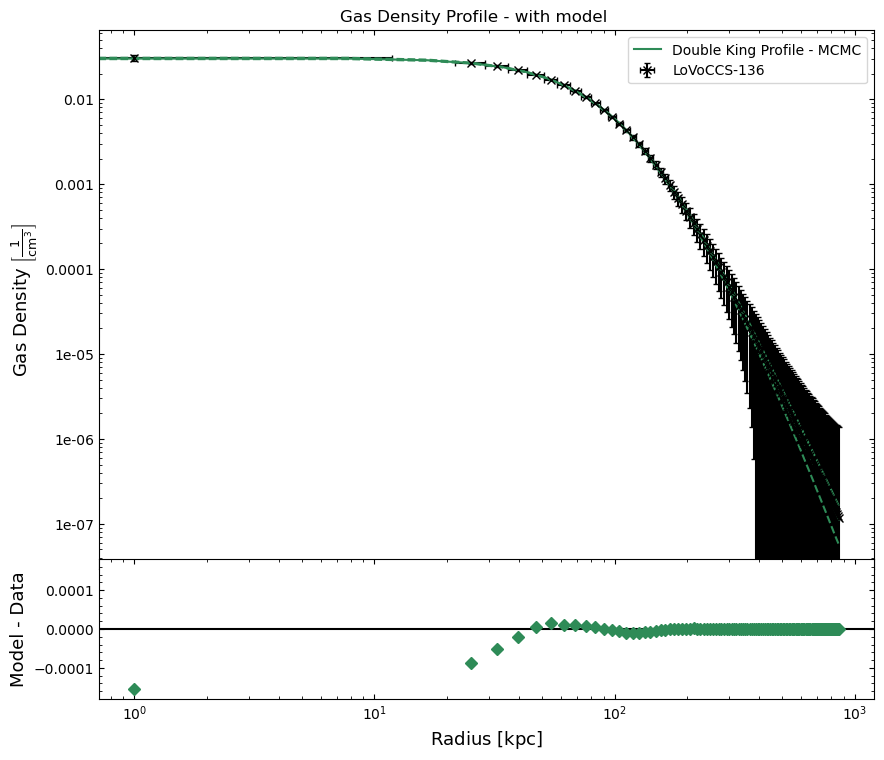

LoVoCCS-138


100%|██████████| 30000/30000 [00:37<00:00, 800.39it/s]


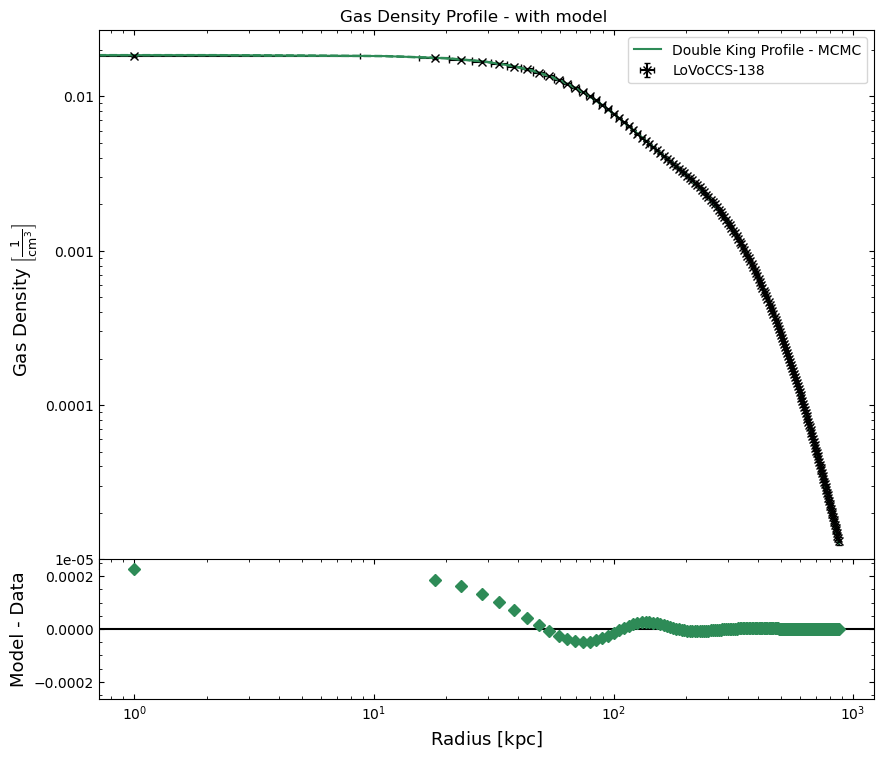

LoVoCCS-140


/mnt/ufs18/home-218/turne540/code/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
100%|██████████| 30000/30000 [00:37<00:00, 795.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1649.34055675 1762.17338911 2353.8912627  1282.448916   1439.41260707
 2414.84303512]


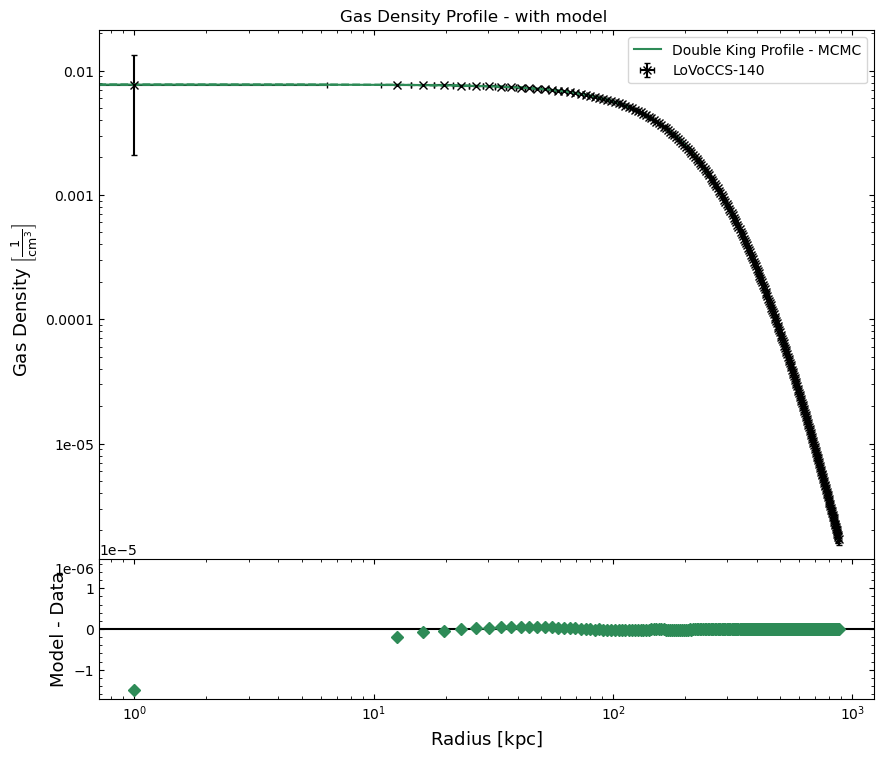

In [12]:
for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        print(rel_src.name)
#         rel_src.get_combined_ratemaps().view(rel_src.ra_dec, rel_src.get_interloper_mask(), zoom_in=True)
        dp.fit('double_king')
        dp.view()

## Measuring and saving gas masses 

Now that the profiles have been fitted with a model, we can integrate with $R_{500}$ as the radius limit and retrieve gas mass measurements. <span style="color:red">This method also supports propagation of $R_{500}$ uncertainties, which can have a large impact on gas mass uncertainties, but they are not available for MCXC $R_{500}$ measurements.</span> 

In [13]:
gms = []
for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        cur_gms = dp.gas_mass('double_king', rel_src.r500)
        gms.append(cur_gms[0])
    else:
        gms.append(Quantity([np.NaN, np.NaN, np.NaN], 'Msun'))

gms = Quantity(gms)

/tmp/local/22421326/ipykernel_112212/3522249417.py:5: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  cur_gms = dp.gas_mass('double_king', rel_src.r500)


<span style="color:red">Change the filename once we actually use XMM derived R500s and coordinates</span> 

In [25]:
data = np.hstack([srcs.names[..., None], gms.to('1e+13 Msun').value])
cols = ['name', 'gm500', 'gm500-', 'gm500+']
gm_df = pd.DataFrame(data, columns=cols)
gm_df.to_csv("../../outputs/results/mcxc_cen_r500_gas_masses.csv", index=False)
gm_df

name                gm500                 gm500-   
0      LoVoCCS-0                  nan                    nan  \
1      LoVoCCS-2   13.710561149353584   0.014321447158846874   
2      LoVoCCS-3   10.870616658822502    0.04482441312932187   
3      LoVoCCS-5    6.647497263098829   0.008472838259010155   
4      LoVoCCS-6   10.160235872484545   0.006218954111551562   
..           ...                  ...                    ...   
102  LoVoCCS-136  0.17409096756216416   0.003441328853134399   
103  LoVoCCS-138   1.1477016831310514  0.0014799591163923826   
104  LoVoCCS-139                  nan                    nan   
105  LoVoCCS-140   0.5790745814994035  0.0003051649334454101   
106  LoVoCCS-143                  nan                    nan   

                    gm500+  
0                      nan  
1     0.053432381540443746  
2    0.0021236413618953122  
3     0.008274976129743749  
4     0.005873672951024999  
..                     ...  
102  0.0035089762392210935  
103  0.0014765194857224609  
104                    nan  
105   0.000301452994812207  
106                    nan  

[107 rows x 4 columns]